# Notes

# Load Modules

In [1]:
library(dplyr)
library(tidyr)
library(scater)
library(Seurat)
library(cowplot)
library(harmony)
library(destiny)
library(monocle3)
library(TSCAN)
library(uwot)
library(slingshot)
library(mclust)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, 

# Load Data

In [ ]:
sim_data = readRDS("simulation_data_with_noise.rds")

In [ ]:
additional_meta_info = read.csv("full_simulation_data_with_noise.csv", row.names=1)
head(additional_meta_info)

Sample     UMAP1    UMAP2    time      lineage Cell_Type r       
cell562 Simulation 3.141247 6.648345 0.3252209 1       A         17.10844
cell779 Simulation 3.083348 6.590264 0.4576187 1       A         20.29426
cell637 Simulation 3.039063 6.706306 0.4598090 1       A         20.34276
cell168 Simulation 2.943072 6.653493 0.4919191 1       A         21.04108
cell393 Simulation 3.054525 6.533715 0.4919191 1       A         21.04108
cell957 Simulation 3.067236 6.607126 0.6072474 1       A         23.37782
        theta     x           y         
cell562  92.38724  -0.7126208  17.093594
cell779 323.01210  16.2102930 -12.209964
cell637 184.81805 -20.2708827  -1.708626
cell168 250.84913  -6.9026702 -19.876627
cell393 162.40476 -20.0566922   6.360523
cell957 141.39118 -18.2680026  14.587760

In [4]:
str(sim_data, 2)

Formal class 'SingleCellExperiment' [package "SingleCellExperiment"] with 9 slots
  ..@ int_elementMetadata:Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ int_colData        :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ int_metadata       :List of 1
  ..@ rowRanges          :Formal class 'CompressedGRangesList' [package "GenomicRanges"] with 5 slots
  ..@ colData            :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ assays             :Formal class 'SimpleAssays' [package "SummarizedExperiment"] with 1 slot
  ..@ NAMES              : NULL
  ..@ elementMetadata    :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ metadata           :List of 3


In [5]:
head(sim_data@colData)

DataFrame with 6 rows and 3 columns
        step_ix simulation_i  sim_time
      <integer>    <integer> <numeric>
cell1      5161            9   990.258
cell2      1337            3   227.543
cell3      2079            4   558.624
cell4      3800            7   573.548
cell5      3767            7   500.117
cell6      1526            3   620.849

In [6]:
additional_meta_info = additional_meta_info[rownames(sim_data@colData),]
head(additional_meta_info)

Sample     UMAP1        UMAP2      time     lineage Cell_Type r       
cell1 Simulation  5.341629762 -4.3809502 990.2580 2       J         783.0981
cell2 Simulation  0.004179019  0.8290913 227.5431 1       D         452.5360
cell3 Simulation -7.408302051 -3.1970012 558.6239 1       F         709.0568
cell4 Simulation -7.239112598 -3.1284845 573.5479 1       F         718.4658
cell5 Simulation -5.224359256 -1.2158221 500.1175 1       F         670.8992
cell6 Simulation -0.683234554  0.2102428 620.8488 1       F         747.5051
      theta     x         y        
cell1 127.50379 -476.7610  621.2420
cell2 139.16547 -342.3892  295.9027
cell3 349.04434  696.1339 -134.7557
cell4 297.28803  329.3906 -638.5099
cell5  24.53285  610.3327  278.5673
cell6 352.23810  740.6564 -100.9556

In [7]:
sim_data@colData$Cell_Type = additional_meta_info$Cell_Type
sim_data@colData$x = additional_meta_info$x
sim_data@colData$y = additional_meta_info$y
sim_data@colData$lineage = additional_meta_info$lineage
sim_data@colData$r = additional_meta_info$r

## raw data output

In [8]:
write.csv(sim_data@assays@data@listData$counts, "simulated_expression.csv")

## Seurat obj

In [9]:
dim(sim_data@assays@data@listData$counts)

[1]  135 1000

In [8]:
ss0 <- CreateSeuratObject(counts = sim_data@assays@data@listData$counts)


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [9]:
head(ss0@meta.data)

orig.ident    nCount_RNA nFeature_RNA
cell1 SeuratProject  395        88         
cell2 SeuratProject  249        74         
cell3 SeuratProject 1023       109         
cell4 SeuratProject  517       102         
cell5 SeuratProject  318        79         
cell6 SeuratProject  263        84

In [10]:
ss0@meta.data$step_ix <- sim_data@colData$step_ix
ss0@meta.data$simulation_i <- sim_data@colData$simulation_i
ss0@meta.data$sim_time <- sim_data@colData$sim_time
ss0@meta.data$Cell_Type <- sim_data@colData$Cell_Type
ss0@meta.data$x <- sim_data@colData$x
ss0@meta.data$y <- sim_data@colData$y
ss0@meta.data$lineage <- sim_data@colData$lineage
ss0@meta.data$r <- sim_data@colData$r

In [11]:
# ss0 <- NormalizeData(ss0)
ss0 <- FindVariableFeatures(ss0)
ss0 <- ScaleData(ss0)

Centering and scaling data matrix



In [14]:
ss0 <- RunPCA(ss0)

PC_ 1 
Positive:  Target10, Target37, Target41, Target19, C2-TF1, C1-TF1, Target40, Target42, Target39, Target11 
	   C3-TF1, B9-TF1, Target20, B10-TF1, B11-TF1, Target32, C4-TF1, B6-TF1, Target38, C5-TF1 
	   B2-TF1, Target36, Target47, Target34, Target35, Target21, Target5, Target14, B8-TF1, Target15 
Negative:  Target48, B4-TF1, Target23, Target45, B7-TF1, Target43, Target44, B3-TF1, B13-TF1, B14-TF1 
	   B12-TF1, Target27, D1-TF1, D4-TF1, D6-TF1, D2-TF1, D3-TF1, D5-TF1, Target30, Target29 
	   Target9, HK19, Target24, HK39, HK13, HK24, HK8, HK48, Target8, Target33 
PC_ 2 
Positive:  Target4, B5-TF1, Target2, Target22, Target23, Target24, Target49, Target46, Target1, Target28 
	   B2-TF1, Target47, B6-TF1, HK48, HK10, B9-TF1, Target42, B10-TF1, B11-TF1, Target38 
	   Target37, Target41, Target40, Target39, Target10, Target11, C1-TF1, C2-TF1, C3-TF1, Target19 
Negative:  B7-TF1, B13-TF1, Target44, D2-TF1, D1-TF1, B12-TF1, Target43, Target27, B14-TF1, B3-TF1 
	   Target45, D3-TF1, D4-

In [15]:
ss0 <- FindNeighbors(ss0, dims = 1:30, reduction = "pca")
ss0 <- FindClusters(ss0, resolution = 2, cluster.name = "unintegrated_clusters")

Computing nearest neighbor graph

Computing SNN

Warning message:
“The following arguments are not used: cluster.name”
Warning message:
“The following arguments are not used: cluster.name”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 47904

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5672
Number of communities: 9
Elapsed time: 0 seconds


In [16]:
ss0 <- RunUMAP(ss0, dims = 1:30, reduction = "pca", reduction.name = "umap")

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:17:45 UMAP embedding parameters a = 0.9922 b = 1.112

20:17:45 Read 1000 rows and found 30 numeric columns

20:17:45 Using Annoy for neighbor search, n_neighbors = 30

20:17:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:17:45 Writing NN index file to temp file /tmp/RtmpJ2WtNH/file7cde17f939f4

20:17:45 Searching Annoy index using 1 thread, search_k = 3000

20:17:45 Annoy recall = 100%

20:17:46 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

In [17]:
str(ss0, 4)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  ..@ meta.data   :'data.frame':	1000 obs. of  13 variables:
  .. ..$ orig.ident     : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ nCount_RNA     : num [1:1000] 395 249 1023 517 318 ...
  .. ..$ nFeature_RNA   : int [1:1000] 88 74 109 102 79 84 108 74 66 87 ...
  .. ..$ step_ix        : int [1:1000] 5161 1337 2079 3800 3767 1526 5426 4739 1339 2034 ...
  .. ..$ simulation_i   : int [1:1000] 9 3 4 7 7 3 10 9 3 4 ...
  .. ..$ sim_time       : num [1:1000] 990 228 559 574 500 ...
  .. ..$ Cell_Type      : chr [1:1000] "J" "D" "F" "F" ...
  .. ..$ x              : num [1:1000] -477 -342 696 329 610 ...
  .. ..$ y              : num [1:1000] 621 296 -135 -639 279 ...
  .. ..$ lineage        : int [1:1000] 2 1 1 1 1 1 1 1 1 1 ...
  .. ..$ r              : num [1:1000] 783 453 709 718 671 ...
  .. ..$ RNA_snn_

In [18]:
head(ss0@reductions$umap@cell.embeddings)

UMAP_1     UMAP_2    
cell1 -5.5520485  2.5745637
cell2 -0.2792981 -0.7548338
cell3  6.5683429  4.0527442
cell4  5.8161282  3.6410737
cell5  2.4459689  0.6730898
cell6  1.9166748 -2.8232390

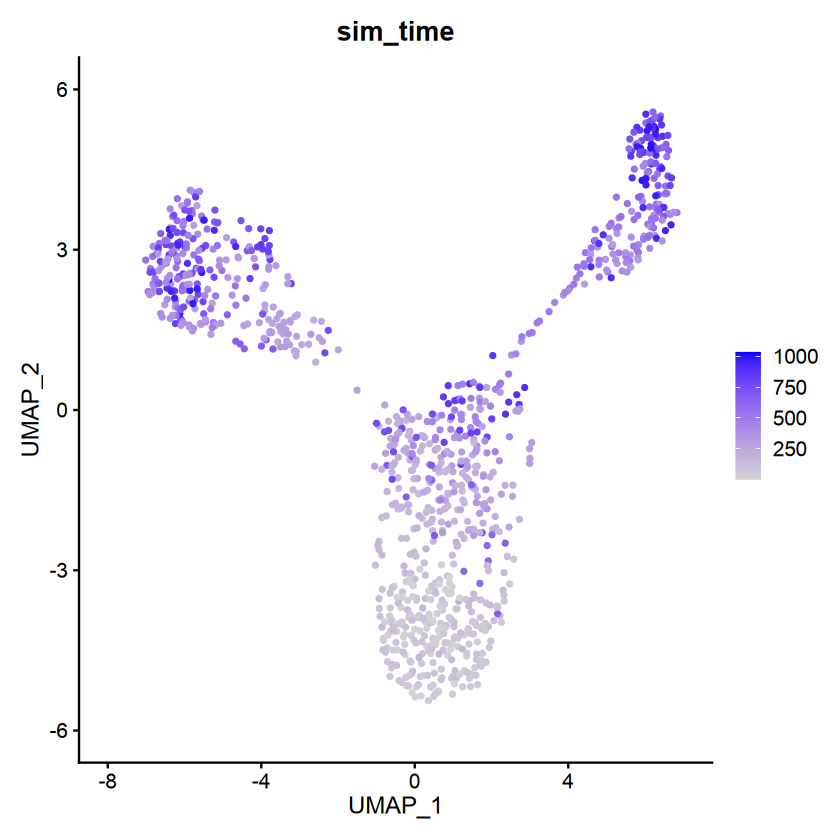

In [19]:
FeaturePlot(ss0, features = c("sim_time"), reduction = "umap")

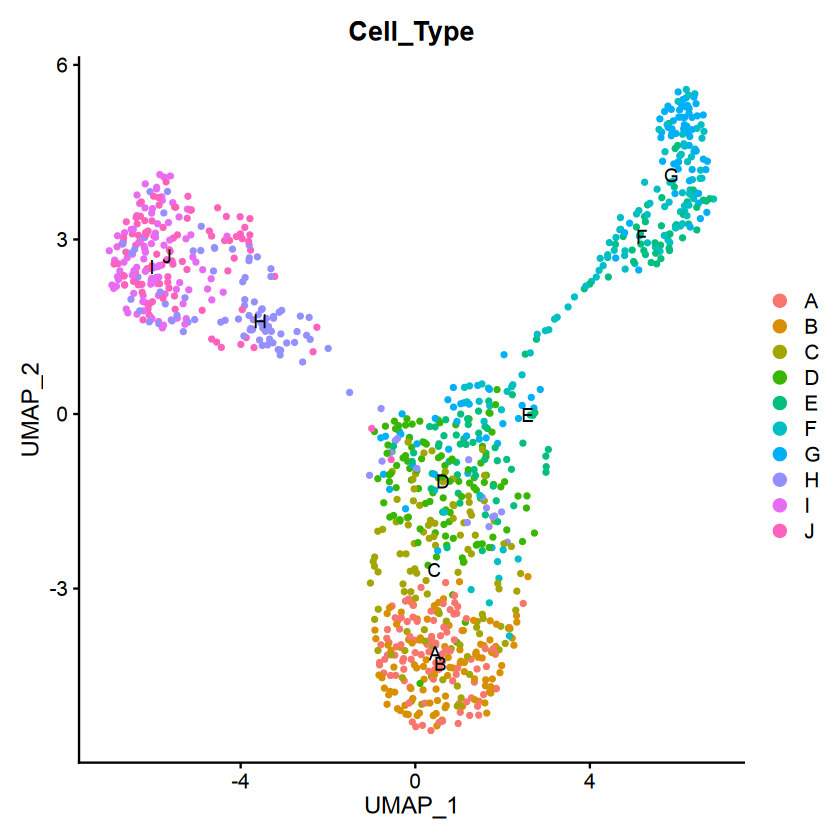

In [20]:
DimPlot(ss0,reduction = 'umap',group.by = 'Cell_Type',label = T)

In [21]:
seq(0,80, length=4)

[1]  0.00000 26.66667 53.33333 80.00000

In [22]:
gg_color_hue_1 <- function(n) {
  hues = seq(0, 90, length = n)
  hcl(h = hues, l = 45, c = 100)[1:n]
}

gg_color_hue_2 <- function(n) {
  hues = seq(105, 345, length = n)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

cols <- c(gg_color_hue_2(7), gg_color_hue_1(3))
names(cols) <- LETTERS[seq( from = 1, to = 10 )]

In [23]:
cols

A         B         C         D         E         F         G         H 
"#7CAE00" "#00BC5A" "#00C0B3" "#00B4F0" "#8E92FF" "#EA6AF1" "#FF64B0" "#C42F5D" 
        I         J 
"#A45900" "#6A7300"

Saving 6.67 x 6.67 in image


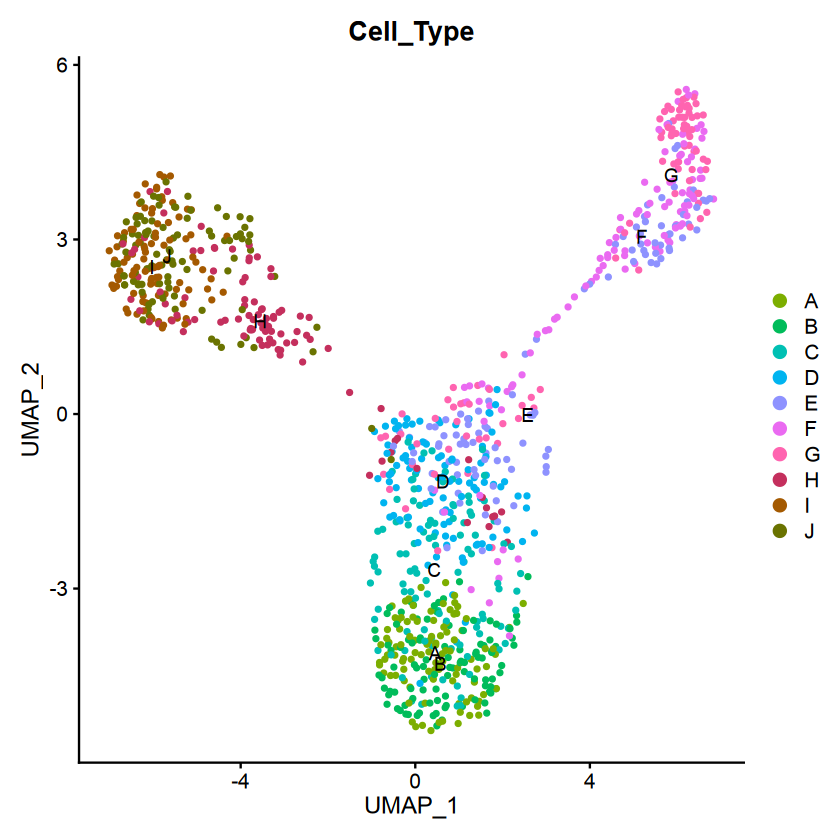

In [24]:
DimPlot(ss0,reduction = 'umap',group.by = 'Cell_Type',label = T,cols=cols)
ggsave("UMAP_cell_type.pdf")

In [25]:
ss0@meta.data[ss0@meta.data$sim_time==min(ss0@meta.data$sim_time),]

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time 
cell562 SeuratProject 232        61           1796    4            0.3252209
        Cell_Type x          y        lineage r        RNA_snn_res.2
cell562 A         -0.7126208 17.09359 1       17.10844 2            
        seurat_clusters
cell562 2

In [26]:
ss0@meta.data[ss0@meta.data$sim_time==min(ss0@meta.data$sim_time),]

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time 
cell562 SeuratProject 232        61           1796    4            0.3252209
        Cell_Type x          y        lineage r        RNA_snn_res.2
cell562 A         -0.7126208 17.09359 1       17.10844 2            
        seurat_clusters
cell562 2

In [27]:
root.use <- rownames(ss0@meta.data[ss0@meta.data$sim_time==min(ss0@meta.data$sim_time),])

In [28]:
head(ss0@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell1 SeuratProject  395        88          5161    9            990.2580
cell2 SeuratProject  249        74          1337    3            227.5431
cell3 SeuratProject 1023       109          2079    4            558.6239
cell4 SeuratProject  517       102          3800    7            573.5479
cell5 SeuratProject  318        79          3767    7            500.1175
cell6 SeuratProject  263        84          1526    3            620.8488
      Cell_Type x         y         lineage r        RNA_snn_res.2
cell1 J         -476.7610  621.2420 2       783.0981 1            
cell2 D         -342.3892  295.9027 1       452.5360 0            
cell3 F          696.1339 -134.7557 1       709.0568 8            
cell4 F          329.3906 -638.5099 1       718.4658 6            
cell5 F          610.3327  278.5673 1       670.8992 4            
cell6 F          740.6564 -100.9556 1       747.5051 0            
      seurat_clusters
cell1 1              
cell2 0              
cell3 8              
cell4 6              
cell5 4              
cell6 0

In [29]:
min(ss0@meta.data$sim_time)

[1] 0.3252209

In [30]:
max(ss0@meta.data$sim_time)

[1] 1034.172

In [31]:
ss0@meta.data$sim_time_rank <- rank(ss0@meta.data$sim_time,ties.method = 'random', na.last = 'keep')
ss0@meta.data$sim_time_norm <- scales::rescale(ss0@meta.data$sim_time_rank,to = c(0,1))


## ONTraC output

In [32]:
cell_NT_df = read.csv("../../ONTrac_test/output/simulation_NTScore/NTScore.csv.gz", row.names=1)
head(cell_NT_df)

x           y          Niche_NTScore Cell_NTScore
cell562  -0.7126208  17.093594 1.130302e-04  0.0001219174
cell779  16.2102930 -12.209964 1.019244e-04  0.0002501772
cell637 -20.2708827  -1.708626 1.102907e-04  0.0001311820
cell168  -6.9026702 -19.876627 9.634373e-05  0.0001970955
cell393 -20.0566922   6.360523 9.994450e-05  0.0001274790
cell957 -18.2680026  14.587760 8.388063e-05  0.0001250134

In [33]:
ss0@meta.data$Cell_NTScore = cell_NT_df[match(rownames(ss0@meta.data), rownames(cell_NT_df)), 'Cell_NTScore']

In [34]:
head(ss0@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell1 SeuratProject  395        88          5161    9            990.2580
cell2 SeuratProject  249        74          1337    3            227.5431
cell3 SeuratProject 1023       109          2079    4            558.6239
cell4 SeuratProject  517       102          3800    7            573.5479
cell5 SeuratProject  318        79          3767    7            500.1175
cell6 SeuratProject  263        84          1526    3            620.8488
      Cell_Type x         y         lineage r        RNA_snn_res.2
cell1 J         -476.7610  621.2420 2       783.0981 1            
cell2 D         -342.3892  295.9027 1       452.5360 0            
cell3 F          696.1339 -134.7557 1       709.0568 8            
cell4 F          329.3906 -638.5099 1       718.4658 6            
cell5 F          610.3327  278.5673 1       670.8992 4            
cell6 F          740.6564 -100.9556 1       747.5051 0            
      seurat_clusters sim_time_rank sim_time_norm Cell_NTScore
cell1 1               996           0.9959960     0.9226104   
cell2 0               376           0.3753754     0.6154288   
cell3 8               766           0.7657658     0.8448661   
cell4 6               777           0.7767768     0.9180524   
cell5 4               692           0.6916917     0.8193589   
cell6 0               794           0.7937938     0.8560733

### normalized gene expression

In [15]:
str(ss0@assays, 4)

List of 1
 $ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ scale.data   : num [1:135, 1:1000] -0.926 0.103 0.215 0.668 -0.491 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. ..@ key          : chr "rna_"
  .. ..@ assay.orig   : NULL
  .. ..@ var.features : chr [1:135] "Target10" "Target35" "Target37" "Target32" ...
  .. ..@ meta.features:'data.frame':	135 obs. of  5 variables:
  .. .. ..$ vst.mean                 : num [1:135] 4.35 3.75 3.47 3.47 3.13 ...
  .. .. ..$ vst.variance             : num [1:135] 6.42 5.84 6.05 5.25 5.25 ...
  .. .. ..$ vst.variance.expected    : num [1:135] 9.88 7.07 5.92 5.92 5.81 ...
  .. .. ..$ vst.variance.standardized: num [1:135] 0.65 0.826 1.021 0.887 0.903 ...
  .. .. ..$ vst.variable             : logi [1:135] TRUE TRUE TRUE TRUE TRUE TRUE ...
  .. ..@ misc        

In [20]:
write.csv(t(ss0@assays$RNA@scale.data),"normalized_gene_exp.csv",quote=FALSE)

# DPT

In [35]:
dm.use <- DiffusionMap(data = sim_data)

Warning message in (function (data, k, ..., query = NULL, distance = c("euclidean", :
“find_knn does not yet support sparse matrices, converting data to a dense matrix.”
Warning message:
“'as(<dsCMatrix>, "dsTMatrix")' is deprecated.
Use 'as(., "TsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").”


In [36]:
ss0[['dmap']] <- CreateDimReducObject(embeddings = dm.use@eigenvectors,assay = 'RNA',stdev = dm.use@eigenvalues,key = 'DC_')

In [37]:
dpt.use <- DPT(dm.use,tips = match(root.use,rownames(dm.use@eigenvectors)))
dpt_rank <- rank(dpt.use$dpt,ties.method = 'random', na.last = 'keep')
ss0@meta.data$dpt_norm <- scales::rescale(dpt_rank,to = c(0,1))
ss0@meta.data$dpt = dpt.use$dpt


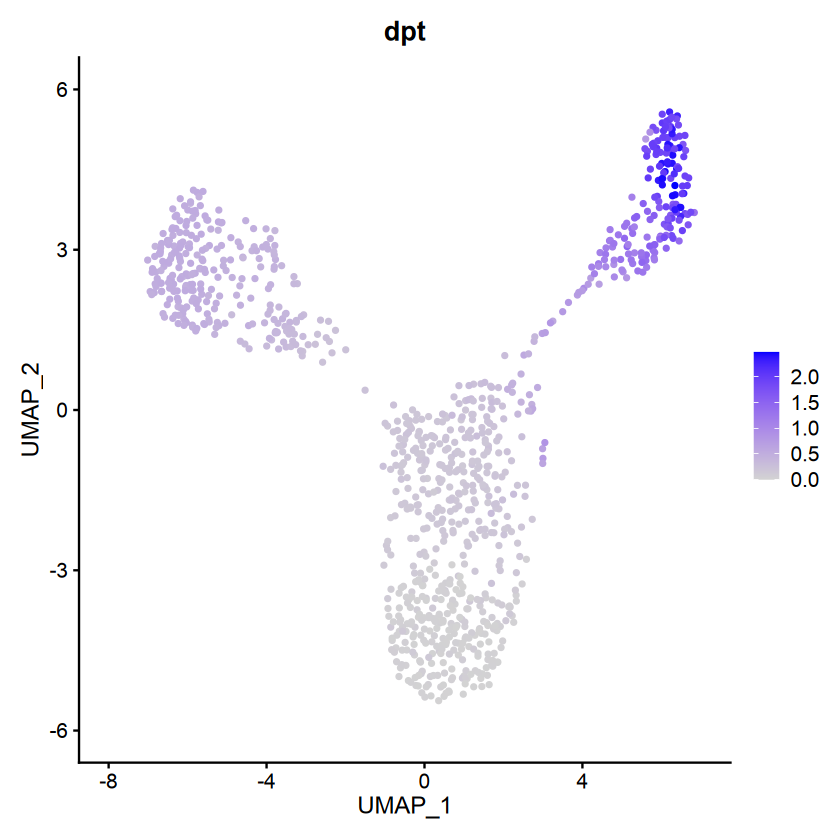

In [38]:
FeaturePlot(ss0, features = c("dpt"), reduction = "umap")

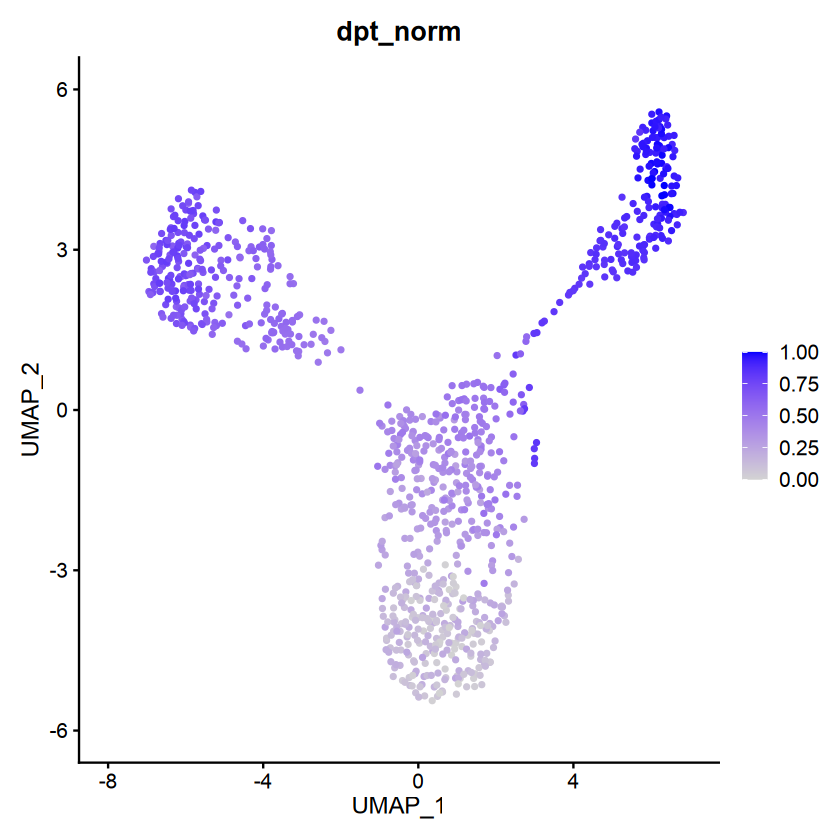

In [39]:
FeaturePlot(ss0, features = c("dpt_norm"), reduction = "umap")

# monocle

In [40]:
gene_annotation <- as.data.frame(sim_data@assays@data@listData$counts@Dimnames[[1]], row.names = sim_data@assays@data@listData$counts@Dimnames[[1]])
colnames(gene_annotation) <- "gene_short_name"

cds <- new_cell_data_set(sim_data@assays@data@listData$counts,
                         cell_metadata = sim_data@colData,
                         gene_metadata = gene_annotation)

In [41]:
cds <- preprocess_cds(cds, method = "PCA", num_dim = 20)

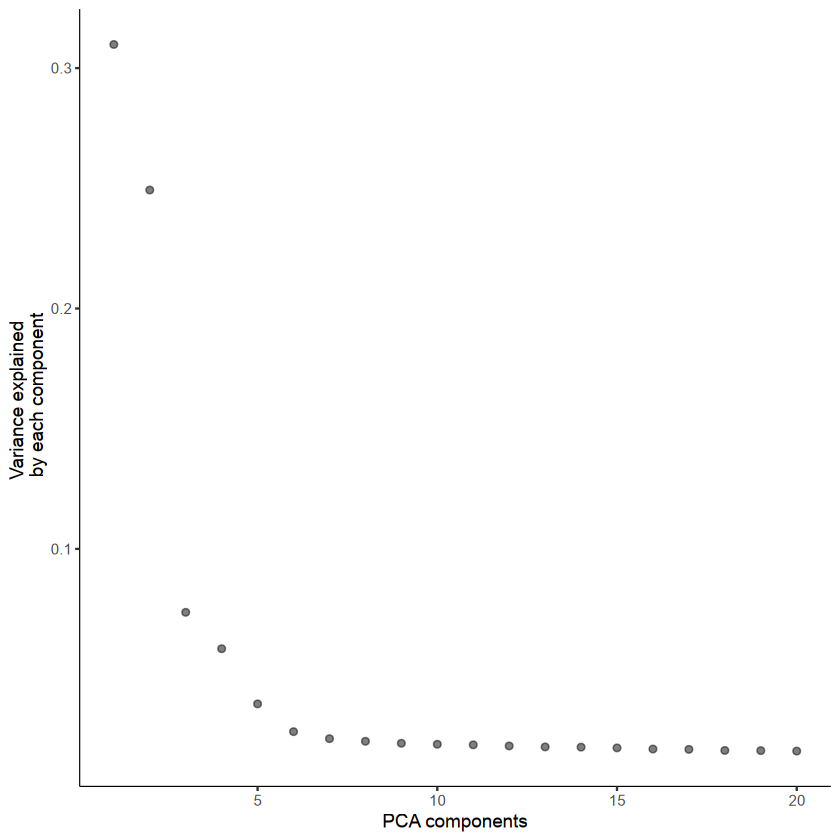

In [42]:
plot_pc_variance_explained(cds)

In [43]:
cds <- reduce_dimension(cds, reduction_method = "UMAP", preprocess_method = "PCA")


No trajectory to plot. Has learn_graph() been called yet?



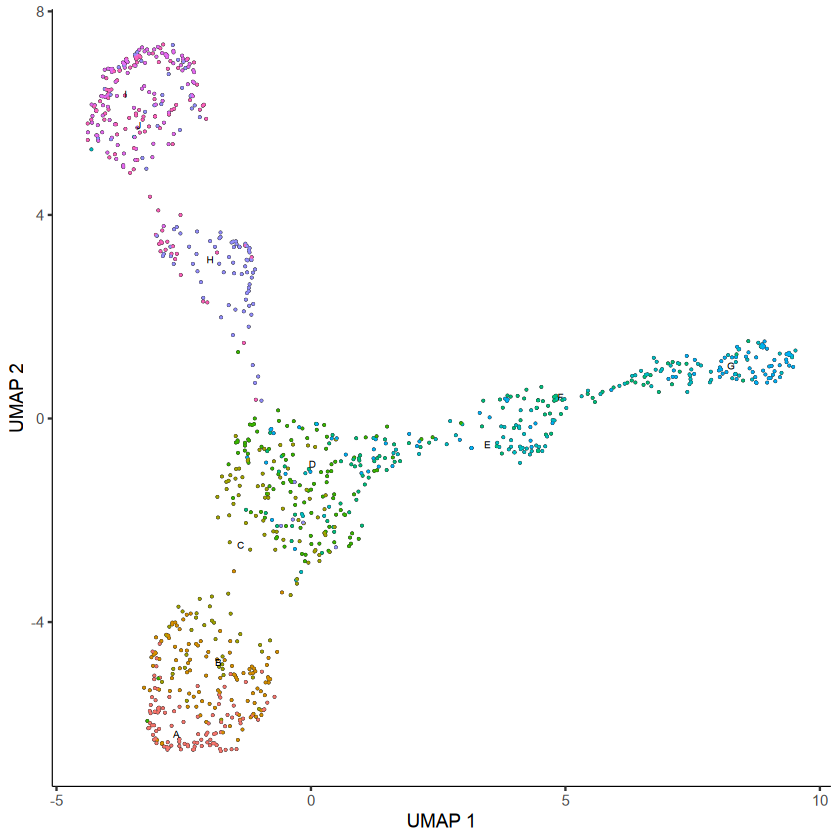

In [44]:
plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "Cell_Type")

No trajectory to plot. Has learn_graph() been called yet?

Cells aren't colored in a way that allows them to be grouped.



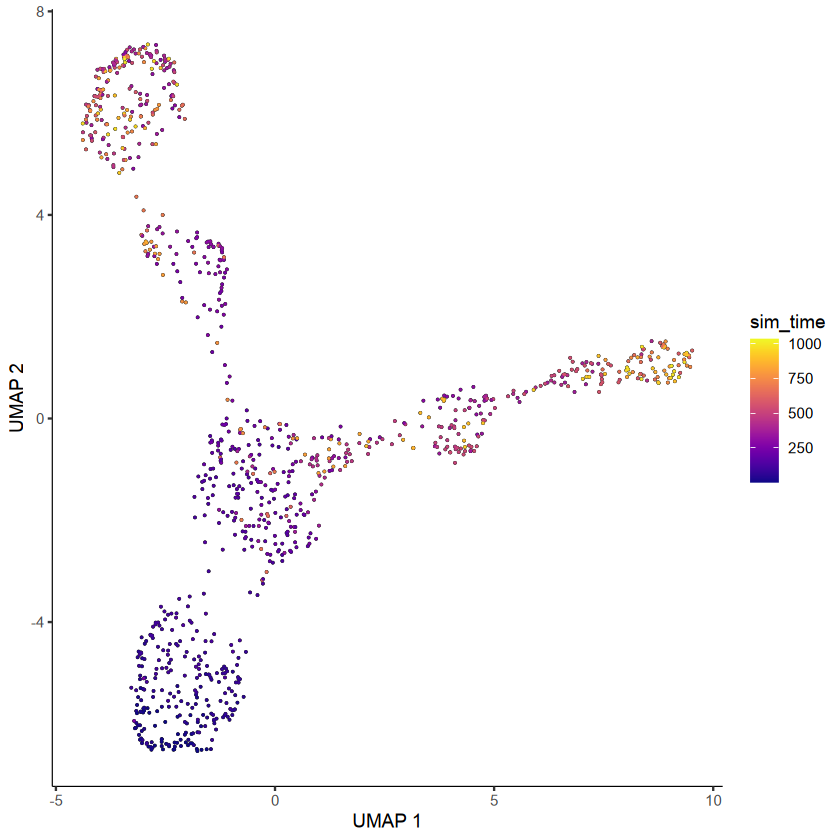

In [45]:
plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "sim_time")

In [46]:
cds <- cluster_cells(cds, reduction_method = "UMAP")

No trajectory to plot. Has learn_graph() been called yet?



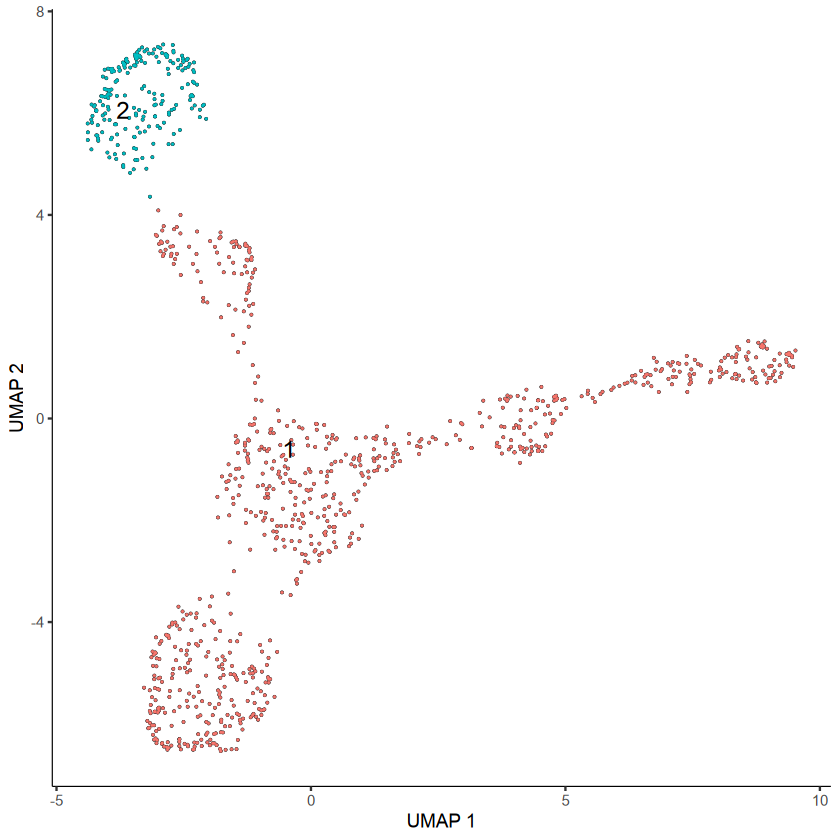

In [47]:
plot_cells(cds, reduction_method = "UMAP", color_cells_by = 'cluster', group_label_size = 5)     

In [48]:
cds <- learn_graph(cds, use_partition=TRUE)

  |======================================================================| 100%


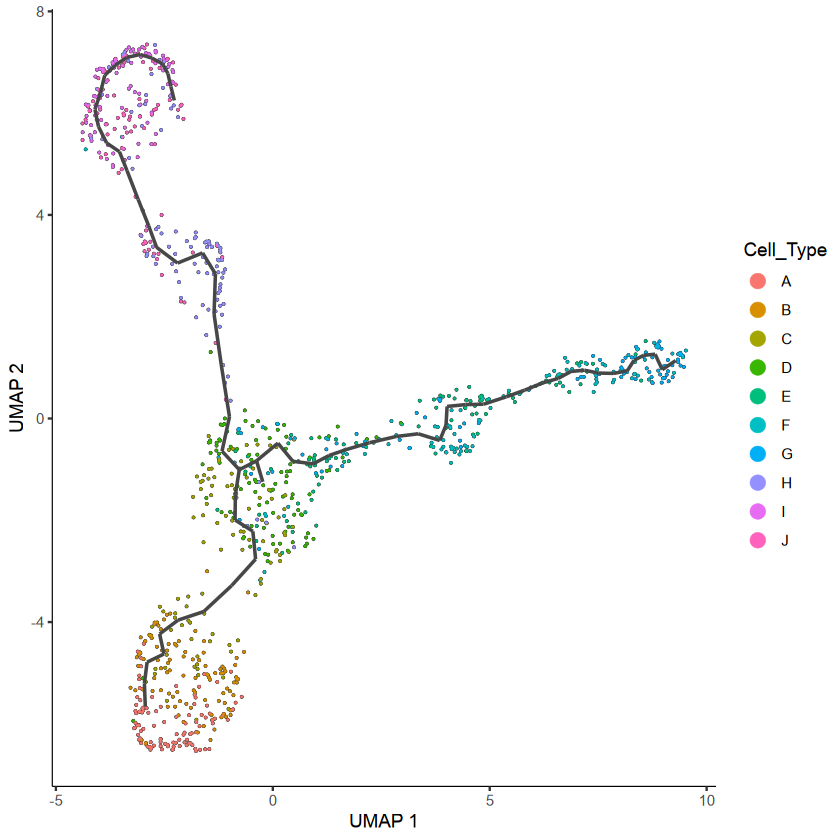

In [49]:
# visualise the learned trajectory
plot_cells(cds,
           color_cells_by = "Cell_Type",
           label_cell_groups=FALSE,
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE)

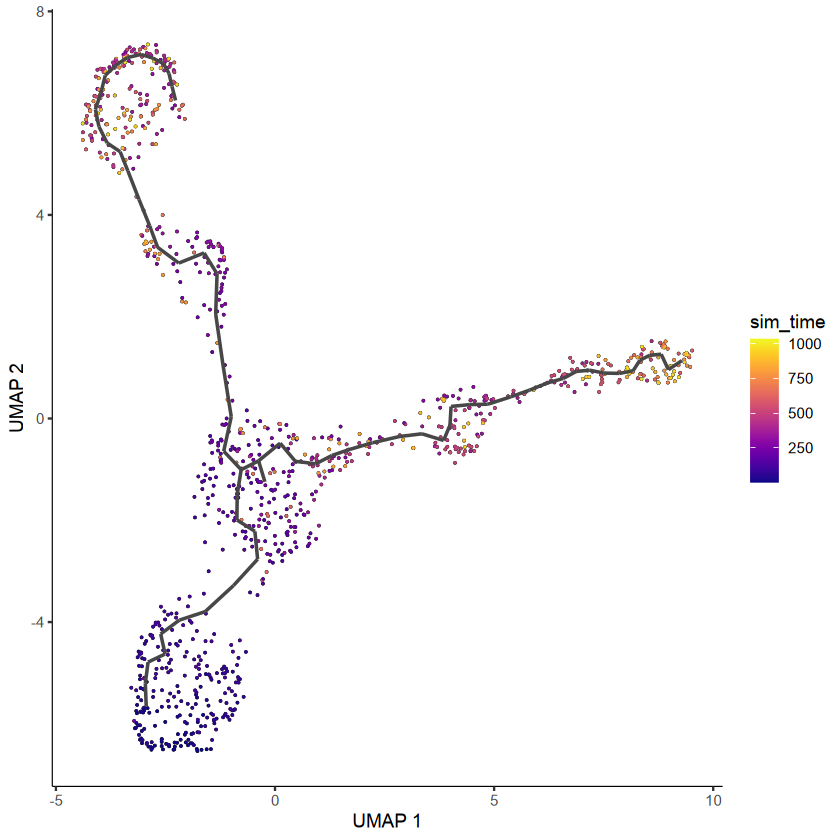

In [50]:
# visualise the learned trajectory
plot_cells(cds,
           color_cells_by = "sim_time",
           label_cell_groups=FALSE,
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE)

In [51]:
cds <- order_cells(cds, root_cells=root.use)

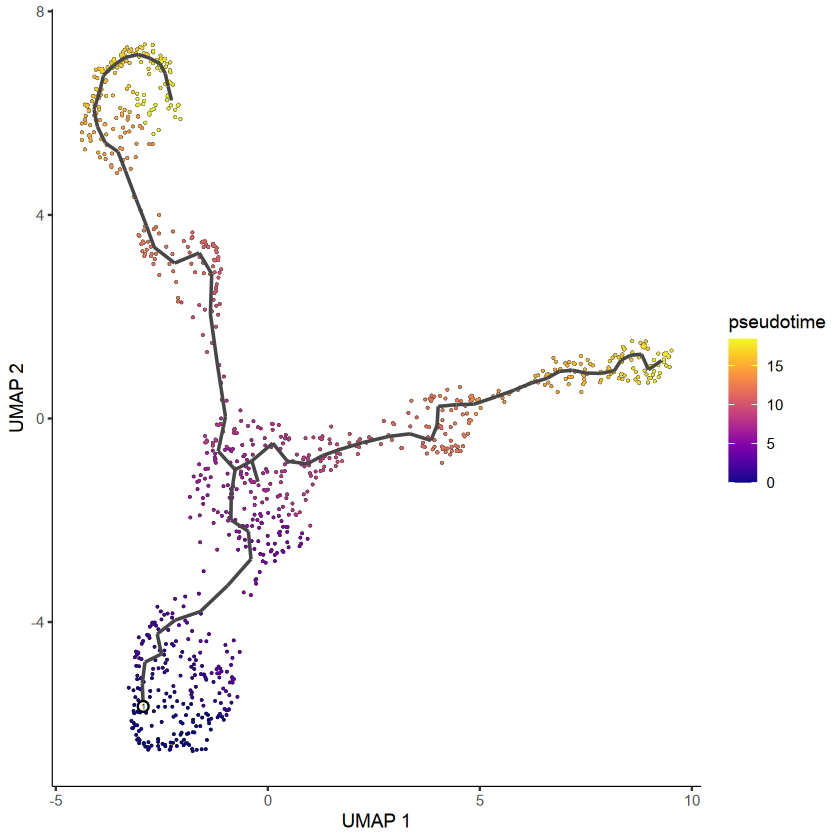

In [52]:
plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

In [53]:
pseudotime <- pseudotime(cds) 

In [54]:
length(pseudotime)

[1] 1000

In [55]:
monocle3_rank <- rank(pseudotime,ties.method = 'random', na.last = 'keep')
monocle3_norm <- scales::rescale(monocle3_rank,to = c(0,1))

In [56]:
ss0@meta.data$monocle3_norm <- monocle3_norm
ss0@meta.data$monocle3 <- pseudotime

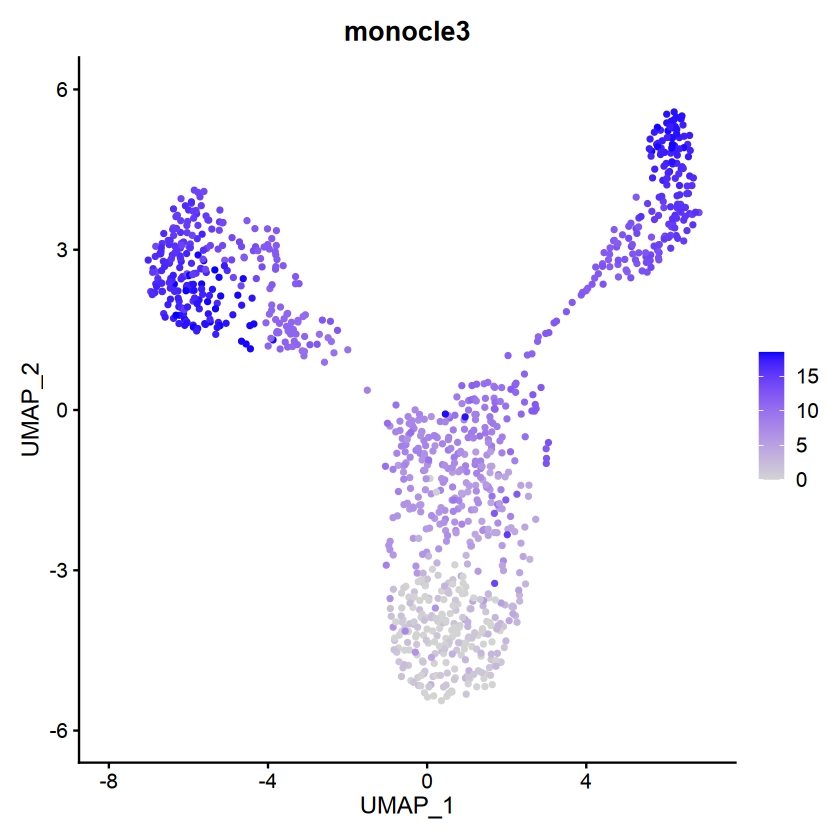

In [57]:
FeaturePlot(ss0, features = c("monocle3"), reduction = "umap")

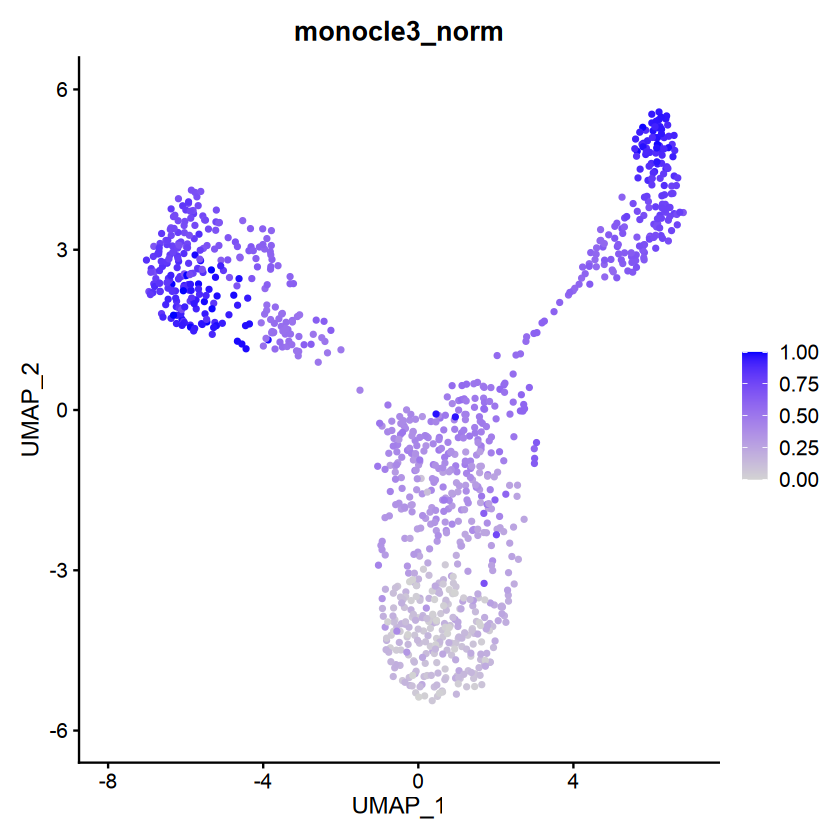

In [58]:
FeaturePlot(ss0, features = c("monocle3_norm"), reduction = "umap")

# TSCAN

In [59]:
exp <- as.matrix(ss0@assays$RNA@data)
procdata <- preprocess(exp, minexpr_value = 0, minexpr_percent = 0.001, cvcutoff = 0.01)


In [60]:
lpsmclust <- exprmclust(procdata)


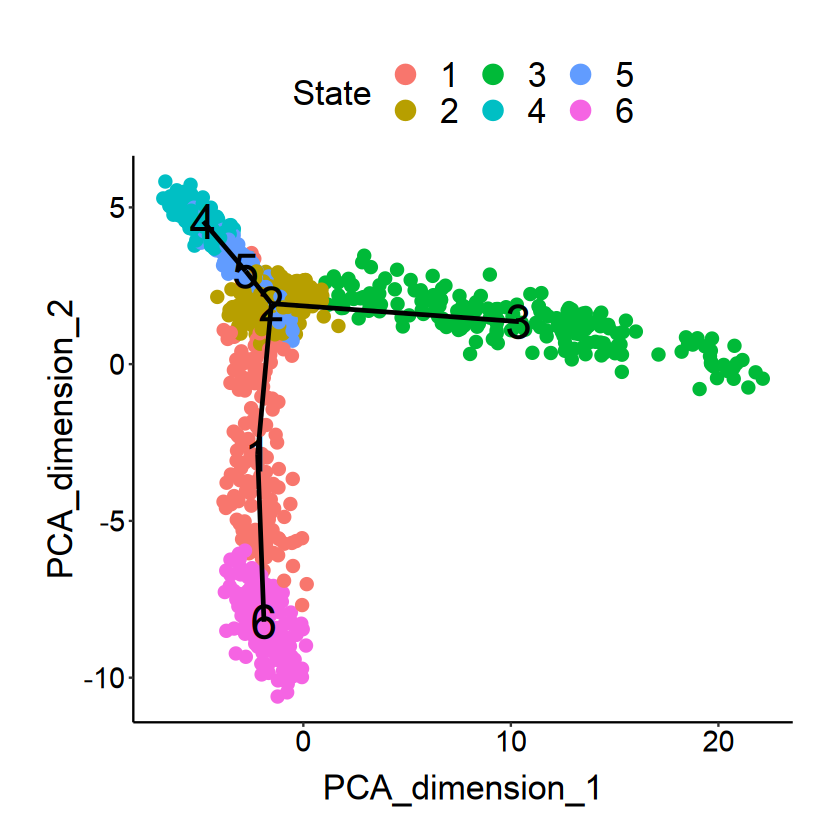

In [61]:
plotmclust(lpsmclust)

In [62]:
tscan_order = TSCANorder(lpsmclust)

In [63]:
tail(tscan_order)

sample_name State Pseudotime
cell809 cell809     6     793       
cell321 cell321     6     794       
cell710 cell710     6     795       
cell722 cell722     6     796       
cell873 cell873     6     797       
cell359 cell359     6     798

In [64]:
tscan_order[rownames(ss0@meta.data),"Pseudotime"]

[1] 699 461  NA  NA  NA 530  NA 419 471  NA  68 703  NA 323 101 345  NA 721
  [19]  84 193 280 454 350  70 761  NA 397  NA  NA 444  22 374  NA  NA 200  NA
  [37]  NA 445 425 324 214  NA 430 188  NA 487 142 664 410 477  NA 762 705 150
  [55]  NA 191 688 598 581 144  NA  NA  NA 560 662  NA 404 275 184  NA  NA 115
  [73] 733  NA 586 763 478  NA 718 246 125  NA  NA 267  NA 135 595 385  59 129
  [91] 384 527  NA 720 216 368 456 476 740 717 650 371 570  NA 566 426 501 266
 [109] 347  NA 417 124 329 618 543  92  NA  NA 285 393 777 610 557  NA 694 361
 [127] 167  NA  NA 655 611  30 288 206 469 394 470  NA 428 111 768 118 199 409
 [145] 380  NA  65 317  NA  NA  51 669 675 713 677 330 486 511  NA 339 475  NA
 [163] 209 767 575 222 228  45 122  20 120 105  NA  NA  NA 605  14  NA  15  NA
 [181] 659 707 464  NA 600 370  NA  NA  NA  44 318  71 242  28 377  27  NA 604
 [199] 387 160 531 245  NA 537 765  NA 248 415 723  48 296 463  57  69 523  NA
 [217]  49 603 774  NA 314  NA  NA 241 363  90 236  NA 396 776 771 609 287 263
 [235] 152 223 687 539 617 211 480 341 390 791 117 261  94  NA  42  91 207 468
 [253]  NA 589 689 239  NA  NA 580 602 198 320  93  21 388 548 260  NA 344 312
 [271] 678 547 536 325  NA  72 737  NA 725 272 608 638 402 785 161 719  77 660
 [289] 157 181  NA  NA  NA 357  NA 583 554 128 165 208 192 789 256 702  NA 500
 [307]  NA  39 546 151  NA  74 313 620 315 146 772  NA 756 769 794 670 381 676
 [325]  NA 712 278 752  80 450 421  54  87 657 298 376 750  13  61  35 766 349
 [343] 351  86  NA 779 395 693 102  NA  NA 443  NA 375 327  63 295  NA 798 495
 [361] 291 204  NA 391 640 674 679 692 528 439 613  83  NA 783 519 141 616 171
 [379] 629 352 423  79 316  96 346  NA 219 186 290 526 175 178  10 139 271 237
 [397]  89 668 680 544 319  41 646 730  NA 759  NA 520 636 684  NA 742 255 164
 [415]  17 225 634  NA 332 306 700  NA 213 276 338 367 553  37 420 123 541  38
 [433] 434 321 282 304 540 251 667  11 356 427 590 690 516 149 433 331  67 392
 [451]  NA 379 790 411 697 492 218  NA 137  NA 442 274 518 788 130 792 185 736
 [469] 577 729 614  NA 333 210 645 220 473  NA  56 226 250 435 757 447 784 738
 [487] 686 247  NA  NA 297  NA 467  NA 632 257 734 382  95  NA 340  NA 556 453
 [505] 286 510 643  33 490 726 412 481  NA 701 364 509 628 631 758 775 100  NA
 [523] 594  NA 710 366  NA 555  NA 224 106  NA 436  NA 217 310 525 221  NA 326
 [541] 307 591  NA  99 121  NA 231 786 431 497  NA 484 449 685 588  NA 681  NA
 [559] 743  60 451  18  NA  76 474 587 584 154   3 551 109 281 704  NA 254  NA
 [577] 354 708   6 179 170 496 243 483 197  NA 414 666  NA  NA 230 294 113 265
 [595] 203 479 735  NA 277 270 714 601 781  NA 202 116  32  NA 658 335 309 422
 [613]  NA 569 134 140  88 212 619 273 182  NA 343 731 131 550 189 429 499 641
 [631]  53 378 107  NA  NA   9   7  NA 432 424  62 283  NA 452 418 293 623 647
 [649] 698  NA 300 132 284 716 706 521 166 637 661 552  NA 596 574  NA 573  19
 [667] 549  55 599  NA 656 571 626  NA 649 252 621  NA  25 502 724 508 400 466
 [685] 778 780  NA 565 578 153 205  NA 696 126 322 672  NA 576 234 663 269 633
 [703]  NA 746 639 513 744  73 562 795  52 183 728 498 505  43 517 337  23  47
 [721] 289 796 538 682 458  NA 465  78  85  NA 561 258 253  46 383 630 163  34
 [739]  NA 652  NA 572 532 398 416 745 542 472  NA  NA 622 195 534 159  NA  NA
 [757] 741  NA 592 386 673 715  NA 654 114 143 582  31  NA 235 259 155 362  NA
 [775] 176  NA 438 305  16  40 711  NA 177 172 353 457 119  NA 747 764 196 244
 [793]  NA 262 691  NA 136 585 441 460   5  NA  NA 755 727  NA 683 522 793 180
 [811]  NA 782 227 359 440  NA 607 399  64  NA 169 240  NA 627 515 232  NA 292
 [829]  NA  NA  NA 405 302 491 642 190 148 648 695  75  NA 753  NA 494 612 446
 [847]  24 455  NA  NA 651 635 568   1  NA  12 459 156 187 264 279 671 358  NA
 [865]  NA  NA  NA   8  NA 311 615 437 797  29 597 301 624  NA 625 360 112 739
 [883]  NA 127 406 529 545 408  NA  NA 503 336 482 751  NA 535  97  NA 373 173
 [901] 229 162 145 567 559  26  NA  58 299 413 108  N

In [65]:
tscan_rank = rank(tscan_order[rownames(ss0@meta.data),"Pseudotime"], ties.method = 'random', na.last = 'keep')
tscan_norm = scales::rescale(tscan_rank,to = c(0,1))
ss0@meta.data$tscan_norm = tscan_norm
ss0@meta.data$tscan = tscan_order[rownames(ss0@meta.data),"Pseudotime"]

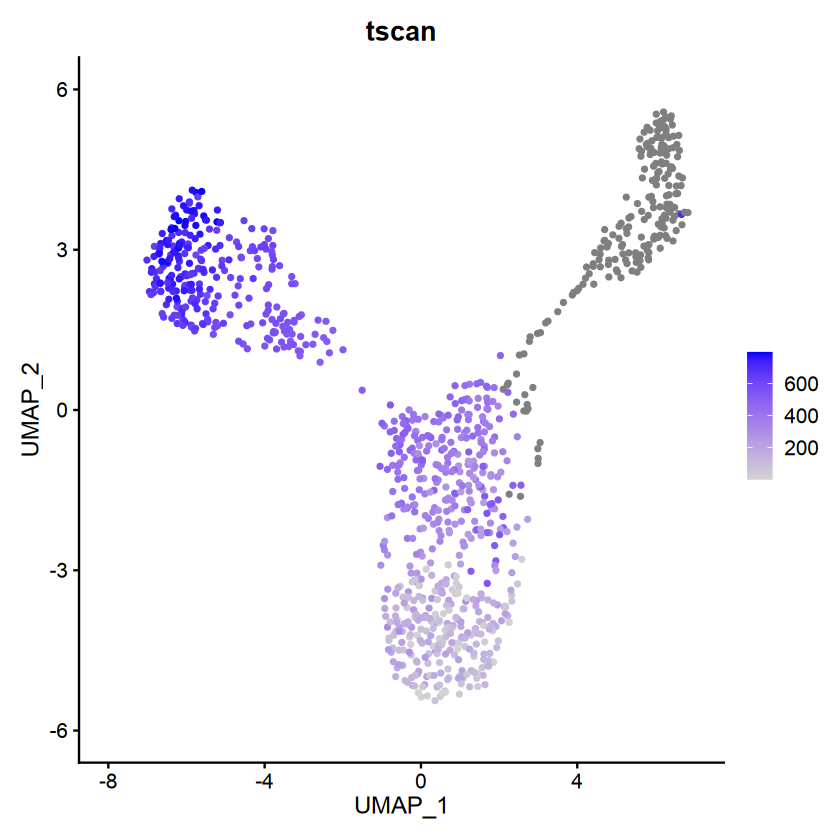

In [66]:
FeaturePlot(ss0, features = c("tscan"), reduction = "umap")

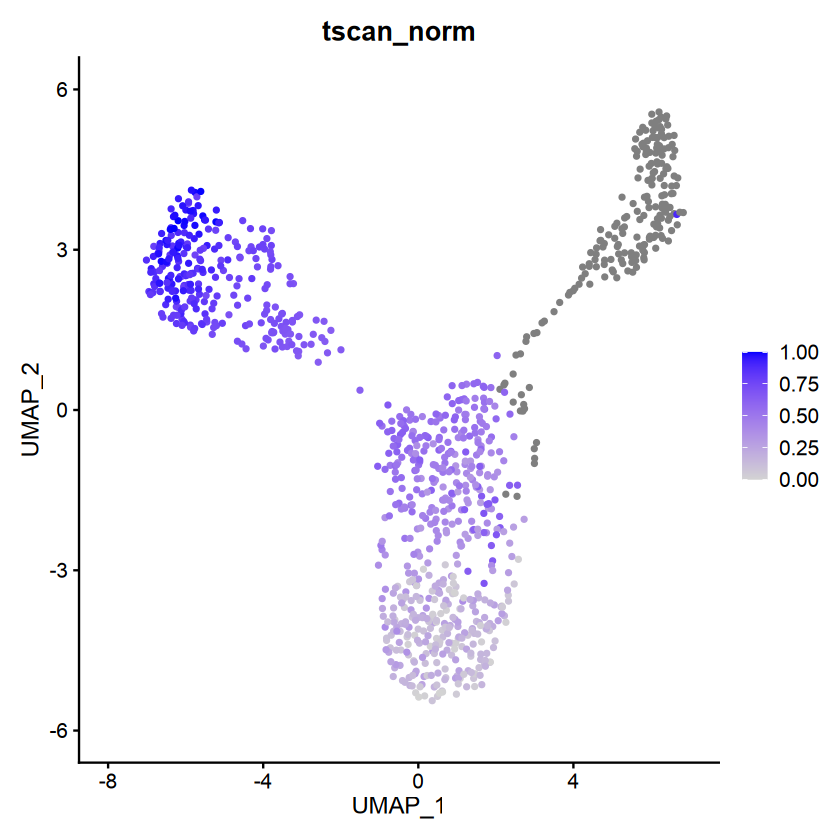

In [67]:
FeaturePlot(ss0, features = c("tscan_norm"), reduction = "umap")

# Slingshot

In [68]:
FQnorm <- function(counts){
    rk <- apply(counts,2,rank,ties.method='min')
    counts.sort <- apply(counts,2,sort)
    refdist <- apply(counts.sort,1,median)
    norm <- apply(rk,2,function(r){ refdist[r] })
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sim_data)$norm <- FQnorm(assays(sim_data)$counts)

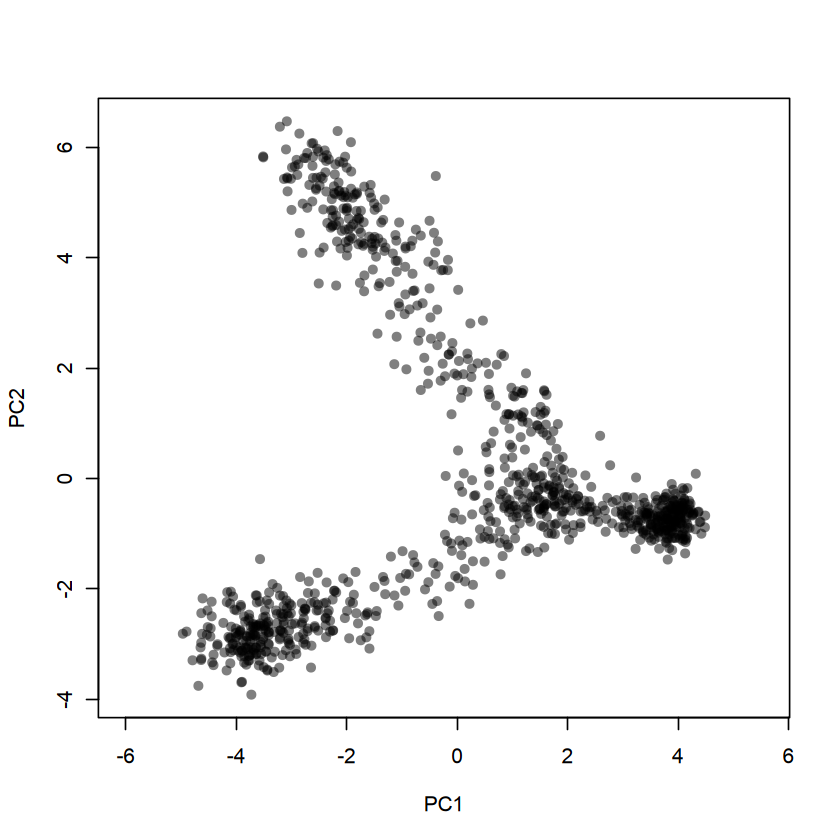

In [69]:
pca <- prcomp(t(log1p(assays(sim_data)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]

plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

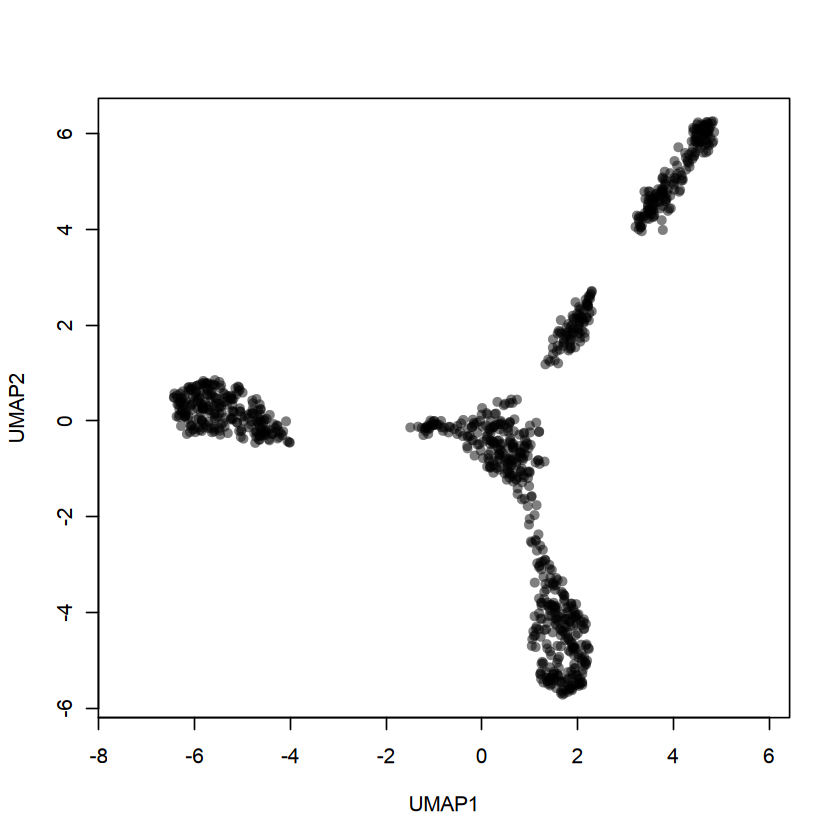

In [70]:
rd2 <- uwot::umap(t(log1p(assays(sim_data)$norm)))
colnames(rd2) <- c('UMAP1', 'UMAP2')

plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1)

In [71]:
reducedDims(sim_data) <- SimpleList(PCA = rd1, UMAP = rd2)

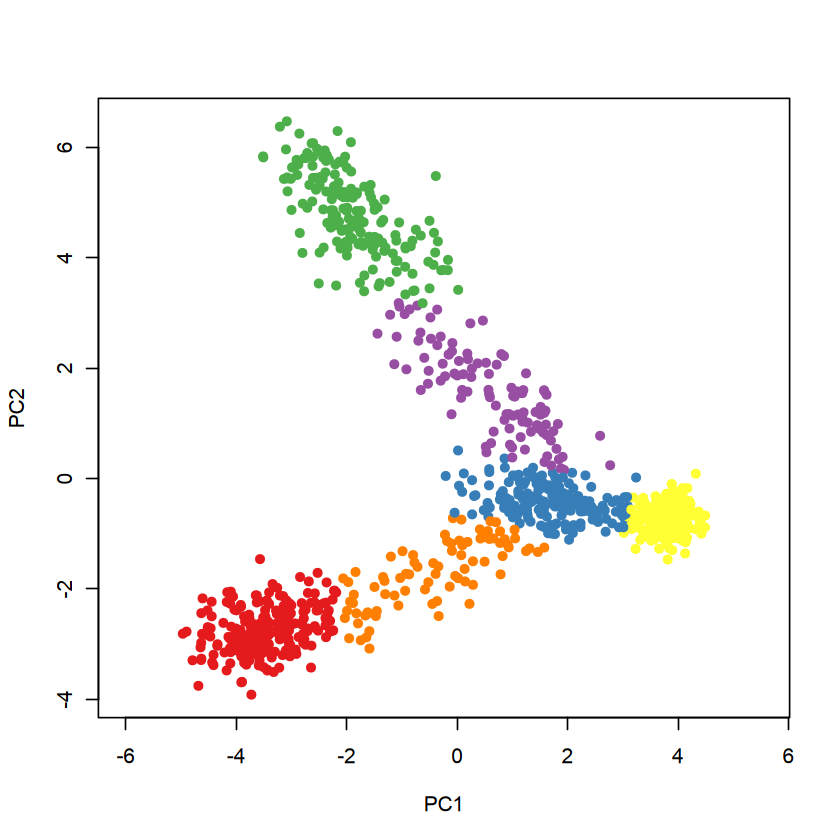

In [72]:
cl1 <- Mclust(rd1)$classification
colData(sim_data)$GMM <- cl1

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

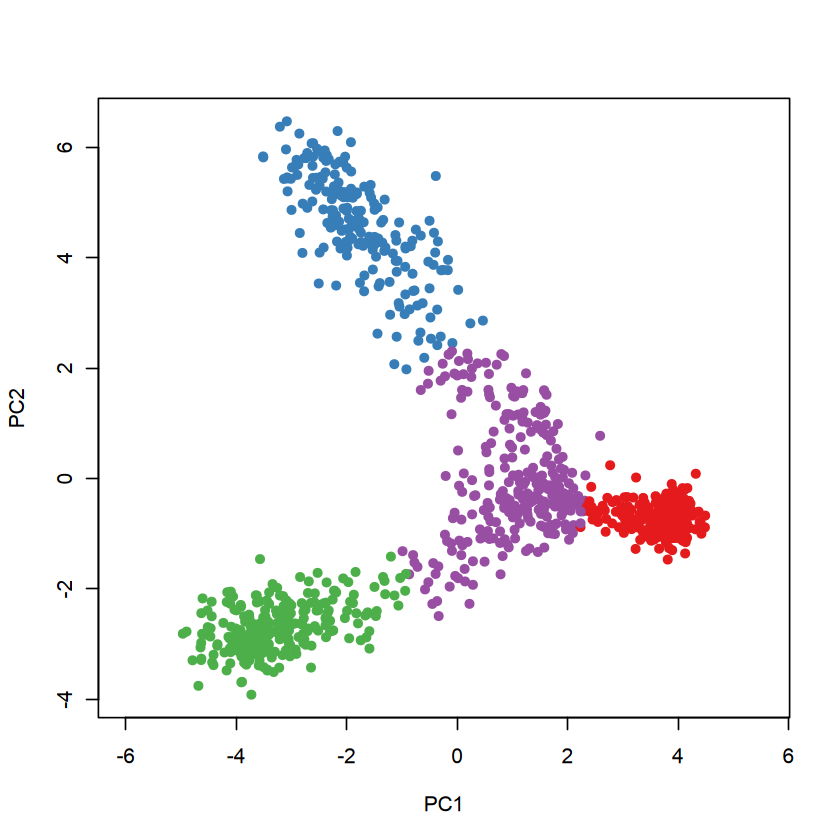

In [73]:
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sim_data)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

In [74]:
sim_data <- slingshot(sim_data, clusterLabels = 'GMM', reducedDim = 'PCA')

In [75]:
summary(sim_data$slingPseudotime_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.881   6.551   6.508  10.847  14.734     299 

In [76]:
library(grDevices)

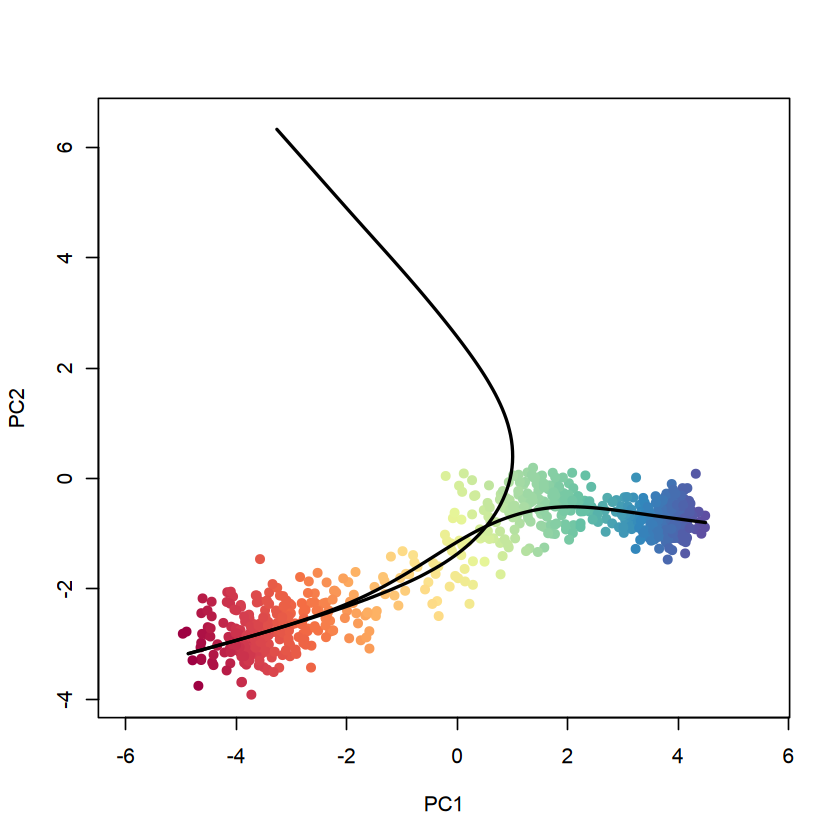

In [77]:
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sim_data$slingPseudotime_2, breaks=100)]

plot(reducedDims(sim_data)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sim_data), lwd=2, col='black')

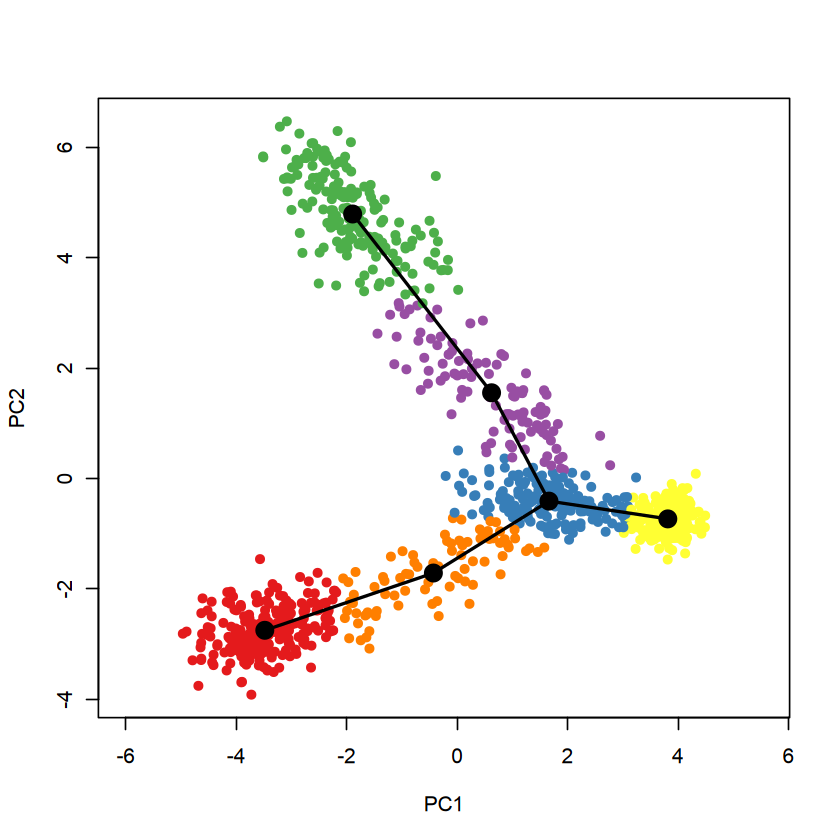

In [78]:
plot(reducedDims(sim_data)$PCA, col = brewer.pal(9,'Set1')[sim_data$GMM], pch=16, asp = 1)
lines(SlingshotDataSet(sim_data), lwd=2, type = 'lineages', col = 'black')

In [79]:
slingshot_rank <- rank(sim_data$slingPseudotime_2,ties.method = 'random', na.last = 'keep')
slingshot_norm <- scales::rescale(slingshot_rank,to = c(0,1))

In [80]:
ss0@meta.data$slingshot_norm = slingshot_norm
ss0@meta.data$slingshot = sim_data$slingPseudotime_2

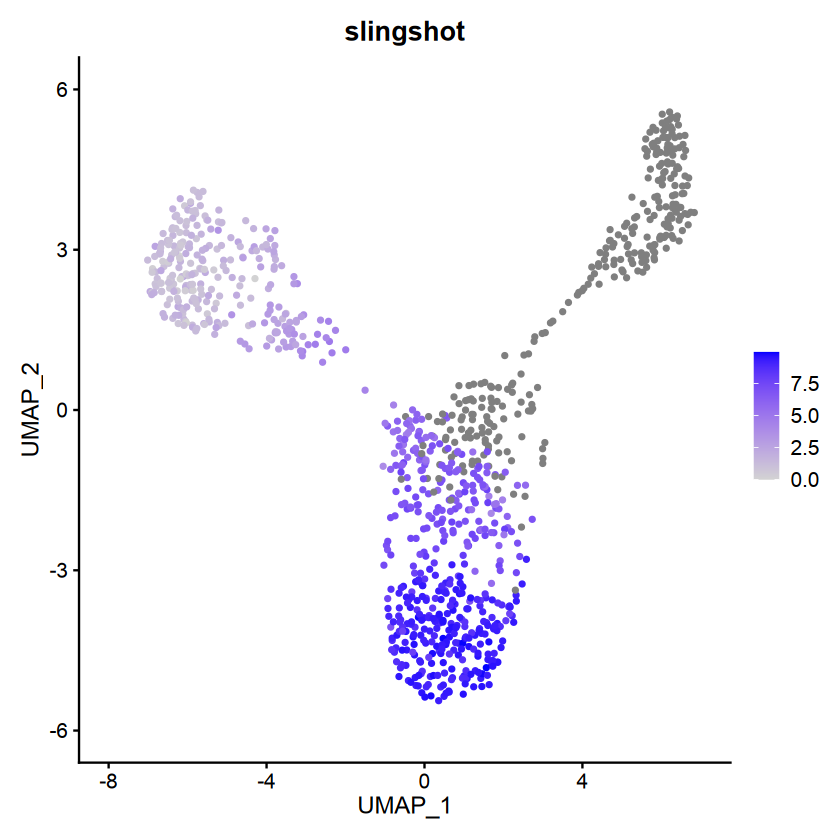

In [81]:
FeaturePlot(ss0, features = c("slingshot"), reduction = "umap")

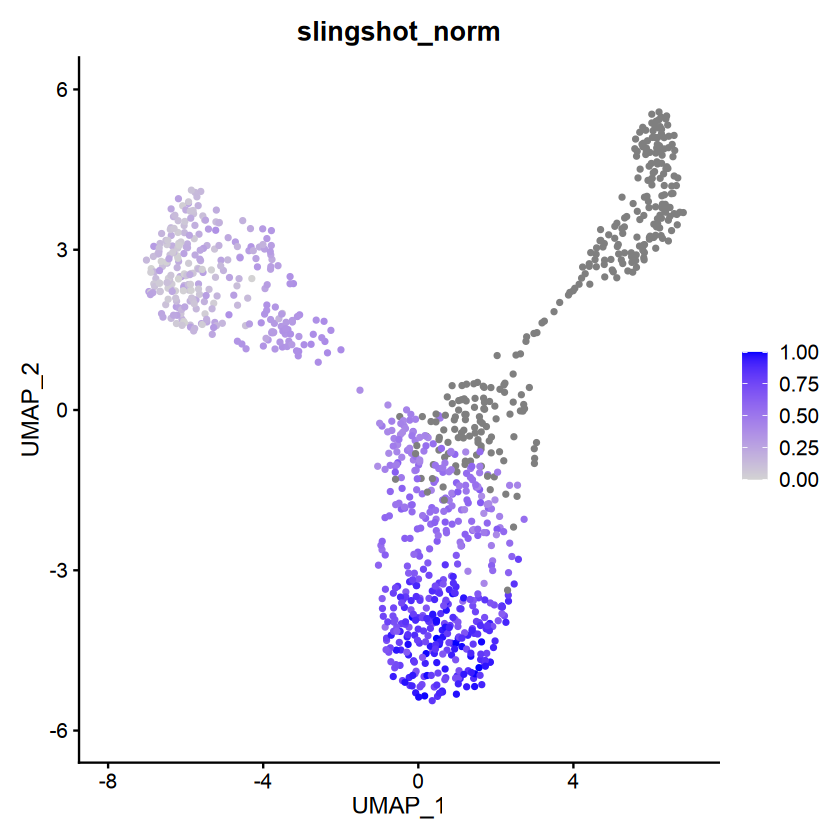

In [82]:
FeaturePlot(ss0, features = c("slingshot_norm"), reduction = "umap")

# Comparison

In [83]:
long_df <- gather(ss0@meta.data[,c("dpt_norm", "monocle3_norm", "tscan_norm", "slingshot_norm", "sim_time_norm", "Cell_Type", "lineage")],
                  key = "variable", value = "value", -sim_time_norm, -Cell_Type, -lineage)
colnames(long_df) = c('sim_time_norm', 'Cell_Type', 'lineage', 'method', 'value')
long_df$method[long_df$method=='dpt_norm'] = "DPT"
long_df$method[long_df$method=='monocle3_norm'] = "monocle3"
long_df$method[long_df$method=='tscan_norm'] = "TSCAN"
long_df$method[long_df$method=='slingshot_norm'] = "Slingshot"
head(long_df)

sim_time_norm Cell_Type lineage method value    
1 0.9959960     J         2       DPT    0.6756757
2 0.3753754     D         1       DPT    0.3823824
3 0.7657658     F         1       DPT    0.9789790
4 0.7767768     F         1       DPT    0.8988989
5 0.6916917     F         1       DPT    0.6226226
6 0.7937938     F         1       DPT    0.3533534

In [84]:
str(cor.test(ss0@meta.data$sim_time_norm, ss0@meta.data$dpt_norm, na.rm=T),2)

List of 9
 $ statistic  : Named num 49.8
  ..- attr(*, "names")= chr "t"
 $ parameter  : Named int 998
  ..- attr(*, "names")= chr "df"
 $ p.value    : num 7.74e-273
 $ estimate   : Named num 0.844
  ..- attr(*, "names")= chr "cor"
 $ null.value : Named num 0
  ..- attr(*, "names")= chr "correlation"
 $ alternative: chr "two.sided"
 $ method     : chr "Pearson's product-moment correlation"
 $ data.name  : chr "ss0@meta.data$sim_time_norm and ss0@meta.data$dpt_norm"
 $ conf.int   : num [1:2] 0.826 0.861
  ..- attr(*, "conf.level")= num 0.95
 - attr(*, "class")= chr "htest"


In [85]:
cor.test(ss0@meta.data$sim_time_norm, ss0@meta.data$dpt_norm, na.rm=T)$estimate

cor 
0.8444481

In [86]:
cor.test(ss0@meta.data$sim_time_norm, ss0@meta.data$tscan_norm, na.rm=T)$estimate

cor 
0.8302232

In [87]:
cor.test(ss0@meta.data$sim_time_norm, ss0@meta.data$slingshot_norm, na.rm=T)$estimate

cor 
-0.8669368

In [88]:
correlations <- data.frame(
  method = c("DPT", "monocle3", "TSCAN", "Slingshot"),
  correlation = c(abs(cor(ss0@meta.data$sim_time_norm, ss0@meta.data$dpt_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(ss0@meta.data$sim_time_norm, ss0@meta.data$monocle3_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(ss0@meta.data$sim_time_norm, ss0@meta.data$tscan_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(ss0@meta.data$sim_time_norm, ss0@meta.data$slingshot_norm, method = "spearman", use = "complete.obs")))
)
head(correlations)

method    correlation
1 DPT       0.8444481  
2 monocle3  0.8352968  
3 TSCAN     0.8587912  
4 Slingshot 0.9062563

In [89]:
all_correlations = data.frame()
correlations_ = correlations
correlations_$lineage = "all"
all_correlations = rbind(all_correlations, correlations_)
all_correlations

method    correlation lineage
1 DPT       0.8444481   all    
2 monocle3  0.8352968   all    
3 TSCAN     0.8587912   all    
4 Slingshot 0.9062563   all

In [90]:
correlation_with_gt <- data.frame(
  method = c("ONTraC", "DPT", "monocle3", "TSCAN", "Slingshot"),
  correlation = c(abs(cor(ss0@meta.data$r, ss0@meta.data$Cell_NTScore, method = "spearman", use = "complete.obs")),
                  abs(cor(ss0@meta.data$r, ss0@meta.data$dpt, method = "spearman", use = "complete.obs")),
                  abs(cor(ss0@meta.data$r, ss0@meta.data$monocle3, method = "spearman", use = "complete.obs")),
                  abs(cor(ss0@meta.data$r, ss0@meta.data$tscan, method = "spearman", use = "complete.obs")),
                  abs(cor(ss0@meta.data$r, ss0@meta.data$slingshot, method = "spearman", use = "complete.obs")))
)
head(correlation_with_gt)

method    correlation
1 ONTraC    0.9918385  
2 DPT       0.6533595  
3 monocle3  0.5715255  
4 TSCAN     0.4949265  
5 Slingshot 0.5064056

In [91]:
all_correlation_with_gt = data.frame()
correlations_ = correlation_with_gt
correlations_$lineage = "all"
all_correlation_with_gt = rbind(all_correlation_with_gt, correlations_)
all_correlation_with_gt

method    correlation lineage
1 ONTraC    0.9918385   all    
2 DPT       0.6533595   all    
3 monocle3  0.5715255   all    
4 TSCAN     0.4949265   all    
5 Slingshot 0.5064056   all

In [92]:
long_df <- left_join(long_df, correlations, by = "method")
head(long_df)

sim_time_norm Cell_Type lineage method value     correlation
1 0.9959960     J         2       DPT    0.6756757 0.8444481  
2 0.3753754     D         1       DPT    0.3823824 0.8444481  
3 0.7657658     F         1       DPT    0.9789790 0.8444481  
4 0.7767768     F         1       DPT    0.8988989 0.8444481  
5 0.6916917     F         1       DPT    0.6226226 0.8444481  
6 0.7937938     F         1       DPT    0.3533534 0.8444481

Warning message:
“Removed 493 rows containing missing values (`geom_point()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 493 rows containing missing values (`geom_point()`).”


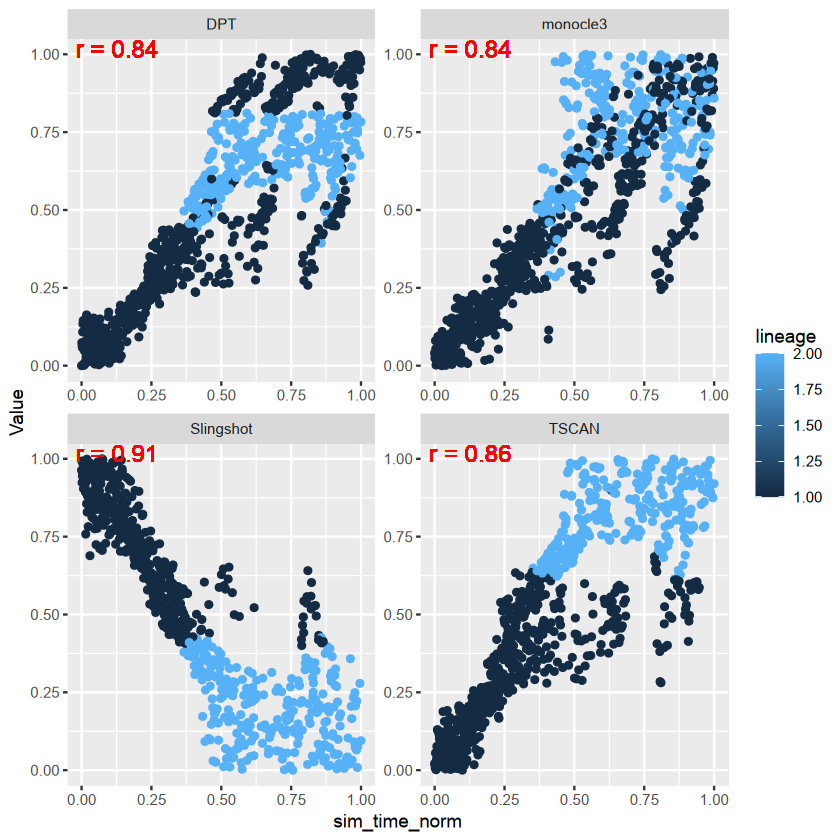

In [93]:
ggplot(long_df, aes(x = sim_time_norm, y = value, color=lineage, palette="Set1")) + 
  geom_point() + 
  facet_wrap(~method, scales = "free") +
  geom_text(aes(label = paste("r =", round(correlation, 2))), x = -Inf, y = Inf, hjust = -0.1, vjust = 1.1, color = "red", size = 5) +
  xlab("sim_time_norm") + 
  ylab("Value")
ggsave("Pseudotime_comparison_lineage.pdf")

Warning message:
“Removed 493 rows containing missing values (`geom_point()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 493 rows containing missing values (`geom_point()`).”


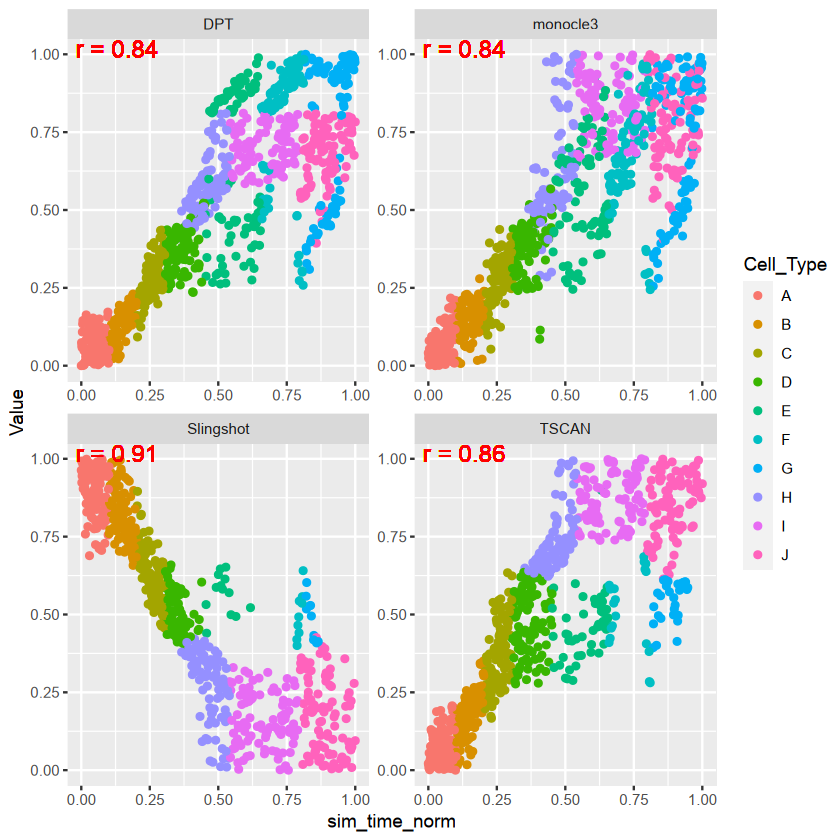

In [94]:
ggplot(long_df, aes(x = sim_time_norm, y = value, color=Cell_Type, palette="Set1")) + 
  geom_point() + 
  facet_wrap(~method, scales = "free") +
  geom_text(aes(label = paste("r =", round(correlation, 2))), x = -Inf, y = Inf, hjust = -0.1, vjust = 1.1, color = "red", size = 5) +
  xlab("sim_time_norm") + 
  ylab("Value")
ggsave("Pseudotime_comparison_cell_type.pdf")

# Lineage 1

## subset sce and seurat

In [95]:
sim_data_l1 <- sim_data[,sim_data@colData$lineage == 1]

In [96]:
dim(sim_data_l1)

[1] 135 708

In [97]:
head(ss0@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell1 SeuratProject  395        88          5161    9            990.2580
cell2 SeuratProject  249        74          1337    3            227.5431
cell3 SeuratProject 1023       109          2079    4            558.6239
cell4 SeuratProject  517       102          3800    7            573.5479
cell5 SeuratProject  318        79          3767    7            500.1175
cell6 SeuratProject  263        84          1526    3            620.8488
      Cell_Type x         y         lineage ⋯ sim_time_norm Cell_NTScore
cell1 J         -476.7610  621.2420 2       ⋯ 0.9959960     0.9226104   
cell2 D         -342.3892  295.9027 1       ⋯ 0.3753754     0.6154288   
cell3 F          696.1339 -134.7557 1       ⋯ 0.7657658     0.8448661   
cell4 F          329.3906 -638.5099 1       ⋯ 0.7767768     0.9180524   
cell5 F          610.3327  278.5673 1       ⋯ 0.6916917     0.8193589   
cell6 F          740.6564 -100.9556 1       ⋯ 0.7937938     0.8560733   
      dpt_norm  dpt       monocle3_norm monocle3  tscan_norm tscan
cell1 0.6756757 0.4910829 0.8628629     16.761602 0.8746867  699  
cell2 0.3823824 0.1720047 0.4584585      8.408949 0.5764411  461  
cell3 0.9789790 2.3243231 0.7767768     15.755698        NA   NA  
cell4 0.8988989 1.5799136 0.7207207     14.822861        NA   NA  
cell5 0.6226226 0.4515718 0.5565566     11.168129        NA   NA  
cell6 0.3533534 0.1645560 0.3733734      7.117197 0.6629073  530  
      slingshot_norm slingshot
cell1 0.2786421      2.163809 
cell2 0.4681754      6.345731 
cell3        NA            NA 
cell4        NA            NA 
cell5        NA            NA 
cell6 0.4922207      6.556258

In [98]:
seurat_l1 = subset(ss0, cells=rownames(ss0@meta.data[ss0@meta.data$lineage == 1,]))

In [99]:
dim(seurat_l1)

[1] 135 708

## DPT

In [100]:
dm.use.1 <- DiffusionMap(data = sim_data_l1)

Warning message in (function (data, k, ..., query = NULL, distance = c("euclidean", :
“find_knn does not yet support sparse matrices, converting data to a dense matrix.”


In [101]:
seurat_l1[['dmap']] <- CreateDimReducObject(embeddings = dm.use.1@eigenvectors,assay = 'RNA',stdev = dm.use.1@eigenvalues,key = 'DC_')

In [102]:
root.use = c('cell168','cell393')

dpt.use.1 = DPT(dm.use.1,tips = match(root.use,rownames(dm.use.1@eigenvectors)))
dpt_l1_rank = rank(dpt.use.1$dpt,ties.method = 'random', na.last = 'keep')
seurat_l1@meta.data$dpt_l1_norm <- scales::rescale(dpt_l1_rank,to = c(0,1))
seurat_l1@meta.data$dpt_l1 = dpt.use.1$dpt

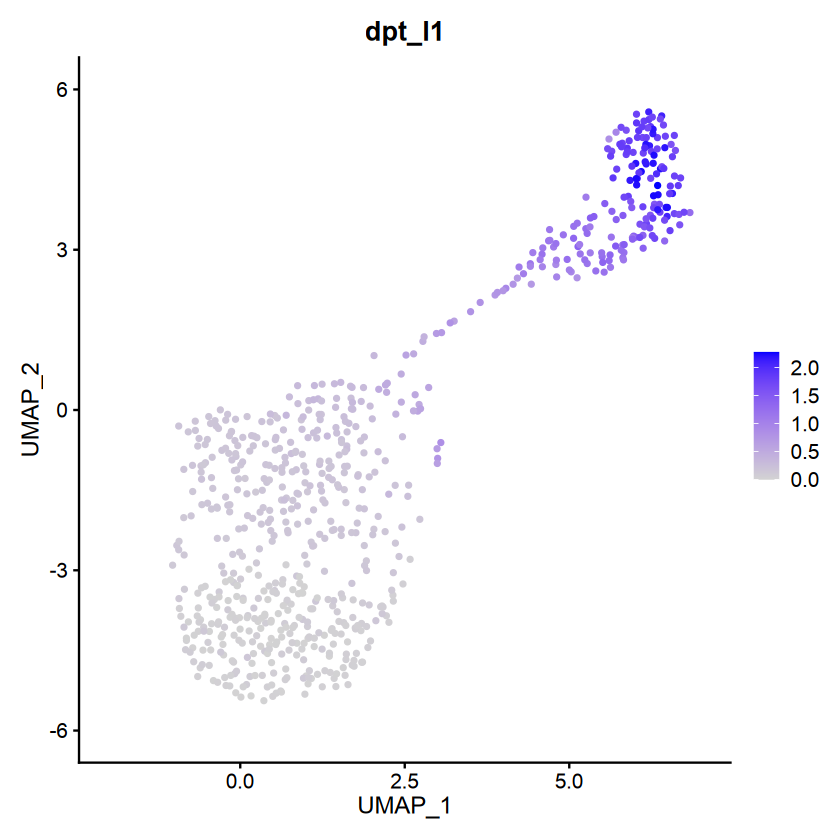

In [103]:
FeaturePlot(seurat_l1, features = c("dpt_l1"), reduction = "umap")

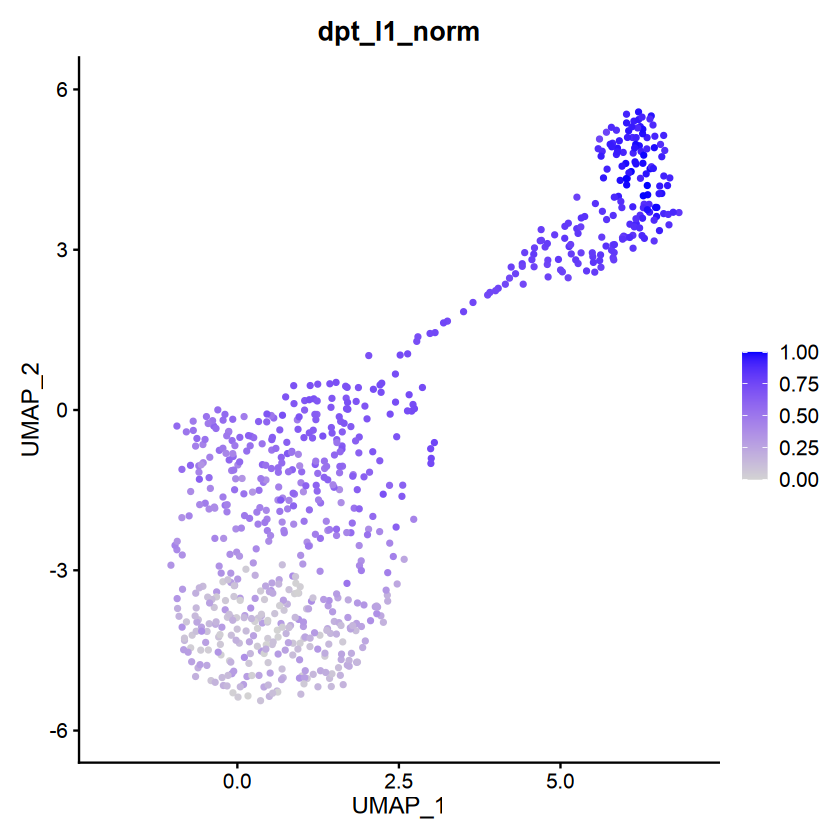

In [104]:
FeaturePlot(seurat_l1, features = c("dpt_l1_norm"), reduction = "umap")

## monocle

In [105]:
gene_annotation <- as.data.frame(sim_data_l1@assays@data@listData$counts@Dimnames[[1]], row.names = sim_data_l1@assays@data@listData$counts@Dimnames[[1]])
colnames(gene_annotation) <- "gene_short_name"

cds <- new_cell_data_set(sim_data_l1@assays@data@listData$counts,
                         cell_metadata = sim_data_l1@colData,
                         gene_metadata = gene_annotation)

In [106]:
cds <- preprocess_cds(cds, method = "PCA", num_dim = 20)

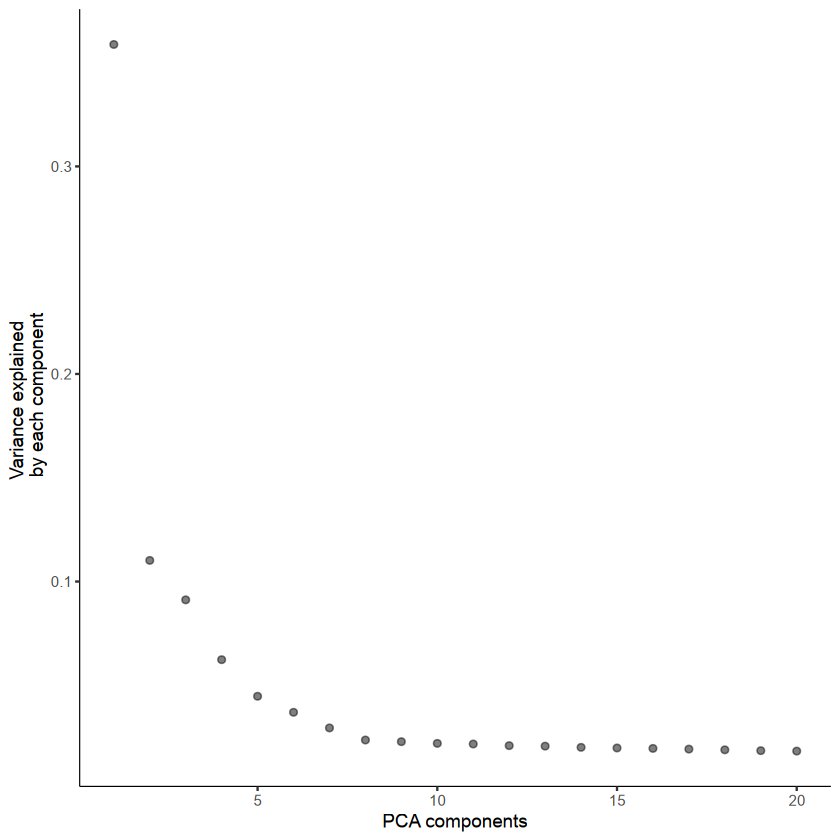

In [107]:
plot_pc_variance_explained(cds)

In [108]:
# cds <- reduce_dimension(cds, reduction_method = "UMAP", preprocess_method = "PCA", umap.min_dist=0.5, umap.n_neighbors= 15L)
cds <- reduce_dimension(cds, reduction_method = "UMAP", preprocess_method = "PCA")

In [109]:
# plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "Cell_Type")

In [110]:
cds <- cluster_cells(cds, reduction_method = "UMAP")

In [111]:
# plot_cells(cds, reduction_method = "UMAP", color_cells_by = 'cluster', group_label_size = 5)     

In [112]:
cds <- learn_graph(cds, use_partition=TRUE)

  |======================================================================| 100%


In [113]:
# visualise the learned trajectory
# plot_cells(cds,
#            color_cells_by = "Cell_Type",
#            label_cell_groups=FALSE,
#            label_groups_by_cluster=FALSE,
#            label_leaves=FALSE,
#            label_branch_points=FALSE)

In [114]:
# visualise the learned trajectory
# plot_cells(cds,
#            color_cells_by = "sim_time",
#            label_cell_groups=FALSE,
#            label_groups_by_cluster=FALSE,
#            label_leaves=FALSE,
#            label_branch_points=FALSE)

In [115]:
cds <- order_cells(cds, root_cells=root.use)

In [116]:
# plot_cells(cds,
#            color_cells_by = "pseudotime",
#            label_cell_groups=FALSE,
#            label_leaves=FALSE,
#            label_branch_points=FALSE,
#            graph_label_size=1.5)

In [117]:
pseudotime <- pseudotime(cds) 

In [118]:
length(pseudotime)

[1] 708

In [119]:
monocle3_l1_rank <- rank(pseudotime,ties.method = 'random', na.last = 'keep')
monocle3_l1_norm <- scales::rescale(monocle3_l1_rank,to = c(0,1))

In [120]:
seurat_l1@meta.data$monocle3_l1_norm <- monocle3_l1_norm
seurat_l1@meta.data$monocle3_l1 <- pseudotime

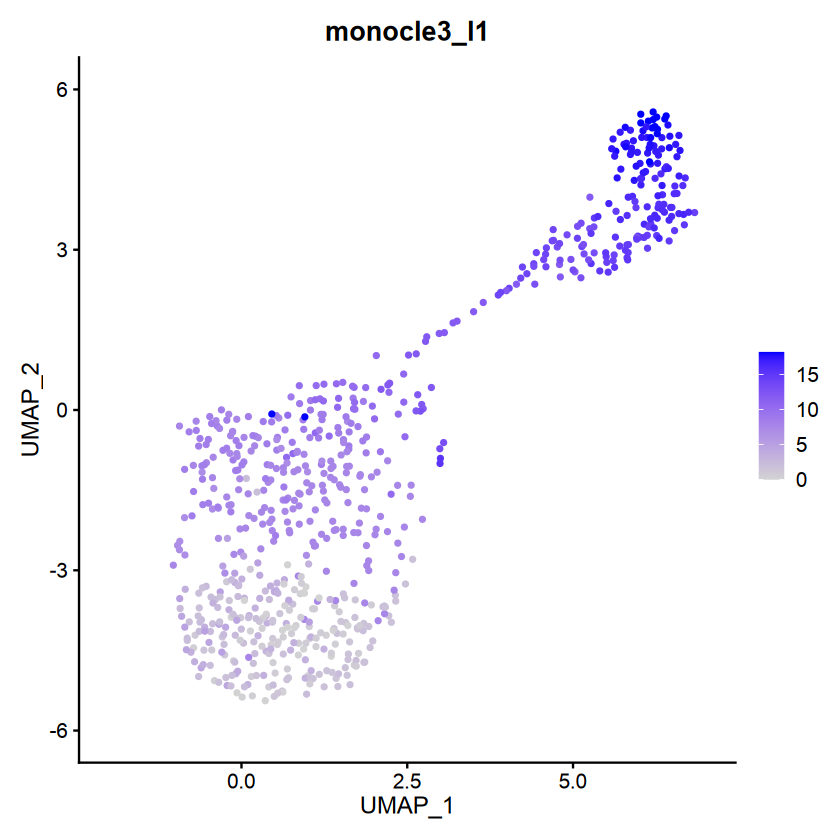

In [121]:
FeaturePlot(seurat_l1, features = c("monocle3_l1"), reduction = "umap")

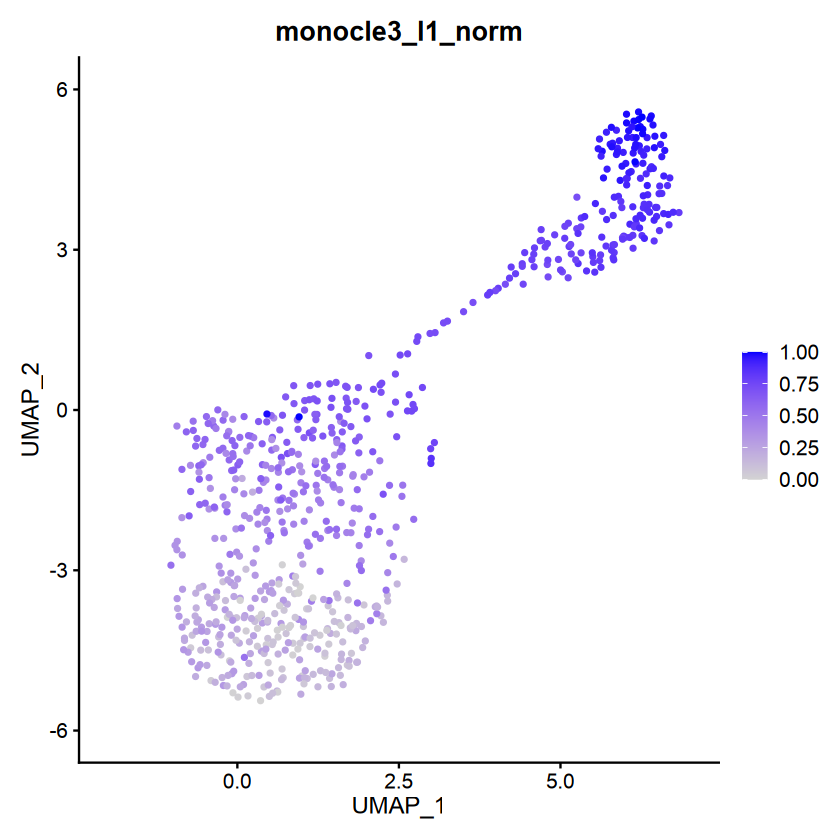

In [122]:
FeaturePlot(seurat_l1, features = c("monocle3_l1_norm"), reduction = "umap")

## TSCAN

In [123]:
library(TSCAN)

In [124]:
exp <- as.matrix(seurat_l1@assays$RNA@data)
procdata <- preprocess(exp, minexpr_value = 0, minexpr_percent = 0.001, cvcutoff = 0.01)


In [125]:
lpsmclust <- exprmclust(procdata)
tscan_order = TSCANorder(lpsmclust)

In [126]:
str(lpsmclust, 2)

List of 4
 $ pcareduceres: num [1:708, 1:2] -3.262 17.831 8.635 0.576 -3.768 ...
  ..- attr(*, "dimnames")=List of 2
 $ MSTtree     :Class 'igraph'  hidden list of 10
  ..$ : num 7
  ..$ : logi FALSE
  ..$ : num [1:6] 3 5 6 3 6 4
  ..$ : num [1:6] 0 0 1 2 2 3
  ..$ : NULL
  ..$ : NULL
  ..$ : NULL
  ..$ : NULL
  ..$ :List of 4
  ..$ :<environment: 0x558d77764588> 
 $ clusterid   : Named int [1:708] 4 2 3 3 5 3 1 4 3 6 ...
  ..- attr(*, "names")= chr [1:708] "cell2" "cell3" "cell4" "cell5" ...
 $ clucenter   : num [1:7, 1:2] -2.39 18.04 6.04 -1.84 -3.48 ...


In [127]:
head(tscan_order)

sample_name State Pseudotime
cell351 cell351     2     1         
cell912 cell912     2     2         
cell513 cell513     2     3         
cell878 cell878     2     4         
cell898 cell898     2     5         
cell51  cell51      2     6

In [128]:
tail(tscan_order)

sample_name State Pseudotime
cell264 cell264     6     693       
cell636 cell636     6     694       
cell11  cell11      6     695       
cell213 cell213     6     696       
cell402 cell402     6     697       
cell177 cell177     6     698

In [129]:
tscan_order[rownames(seurat_l1@meta.data),"Pseudotime"]

[1] 304  14 102 200  NA 101 409 318 175 695 168 351 576 450 127 592 533 382
 [19] 286 336 562  10 257  94  21 441 650 284 123 120 608  52 189 334 258 331
 [37] 482  69 280 568  28 442 564 325 254   6 618 119 575 500 105 135 117  78
 [55] 283 483 547 126  75 570  39 263 142 479 554  77  83 437  59 561 415 613
 [73] 534 230  24 475 309 221 315  93 238  63 306 417 394  71 446 548 340 626
 [91]  80   8 447 433 177 301 665 129 111 601 544 514 223 299 208  90 235 586
[109] 523 471 430 361 100 598 352  47  12 646 390 445 134 259 271 108 536 449
[127]  NA 635 551 625 512 624 106 191  66 698 133 486 125 194 148 407  23  61
[145] 182 685 350 528 489 659 279 675 196 358 501 459 141  50 429 285 651 420
[163] 213 696 658 180 577  22 405 161 171 438 277 661 341  30 247 456 469 632
[181] 457 481 219 377 305 558 466 642 115 679 629 484 296  64 392 192  79 565
[199] 381 616 693 431  NA 373 132 421 294 275  37 609  68 480 365 610 602 460
[217] 538  53  91 138 413 165 639 623 487 507 464 121 128 689 631  82 556 451
[235] 344 600  13 270 154 402 686 440 374 532 574 411 287 560 593 594 366 396
[253] 597 193 322 667 217   1 212 162 408 353 666 203 190 272 452 589 173 220
[271] 281 687 124 621 522 321 436 662 291 607 274 185 424 496 416 531 491 672
[289] 526 474 362 670 359 697  48 181 153 552 497 660 384  31 380 233  67 504
[307] 249 404 435 573 372 535 582 252 403 265 288 410 673 317 360  NA 604 237
[325] 339 595 245 143 363 319  NA 503  41 611 137 311 355 499 513  45 345 463
[343] 465 215 122 485 368 478 300 307 253 199  62 444  65 302  55 462 227 657
[361] 170 385  54 264 231  NA 692  NA 393 342   3 418 638  43 150 218 176  95
[379] 246 585  18 432 131 498 276 476 198 343 290 118 663 543 166 388 400 267
[397] 163 236 391 178 144 628 314 591 146 649 293 584 542 546 510  98 398 179
[415] 297 668 587 529 269 506 243 553 201 326  38  29 332 229 517 327 520 206
[433] 156 282 423  60 495 521 683 157 375 289 348 164 492 633 682 473 453 555
[451]  85 211 648 606 204 222 566 401 617  20 116 694 640  73 241 250 605 467
[469]  35 364 428 434 174 216 599 493 637 159 147 620 674  81 104 389  32 669
[487] 214 349 239  15 645 518 151 654 292  56 427 458 145 615 612 468 224 581
[505] 347 634 627 210 346 226 232 580 678  17 356 406 578 261 488 671  58  16
[523] 262 234 312 113  11 545 563 139 183 130 251  96 571 541 549 103 419 328
[541] 636 225  72 614  97 248  NA 630 490  92 550 470 378 266 539  76 443 414
[559] 110 530  99 596 316 310 559  84 184  26 477  40 260 330 397  34 324 641
[577] 149 583 370  19 369   9 472 197  57 172 256 455 515 519 647  51  49  NA
[595] 313 684 367  27 136 676  42 664 255 509 494 357 502 386 195  36 109  89
[613] 619   7 383 395 588 439   4 412 572  46 677 329 333 152  33 448 205  25
[631]  NA 643   5 228 454 268 656 508 579  74 652 461 422 690   2 354 308 371
[649] 590 569 379 399  86 335 426 644 273 567 557 295  44 202 387 187 303 242
[667] 511 207 155 653 337 681 186 527 114 167 688 169 240 680 691 524 140 298
[685] 320 107 425 323 338 278 655 537 112 505 188 622 158 525 516  88 244 160
[703] 540 603 376 209  87  70

In [130]:
tscan_l1_rank = rank(tscan_order[rownames(seurat_l1@meta.data),"Pseudotime"], ties.method = 'random', na.last = 'keep')
tscan_l1_norm = scales::rescale(tscan_l1_rank,to = c(0,1))
seurat_l1@meta.data$tscan_l1_norm = tscan_l1_norm
seurat_l1@meta.data$tscan_l1 = tscan_order[rownames(seurat_l1@meta.data),"Pseudotime"]

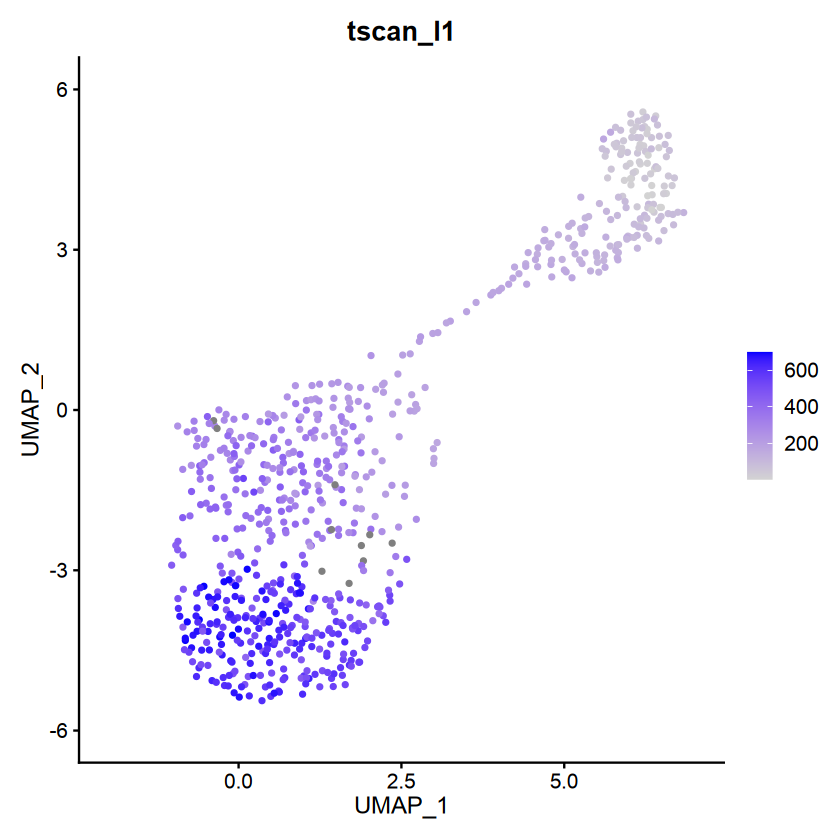

In [131]:
FeaturePlot(seurat_l1, features = c("tscan_l1"), reduction = "umap")

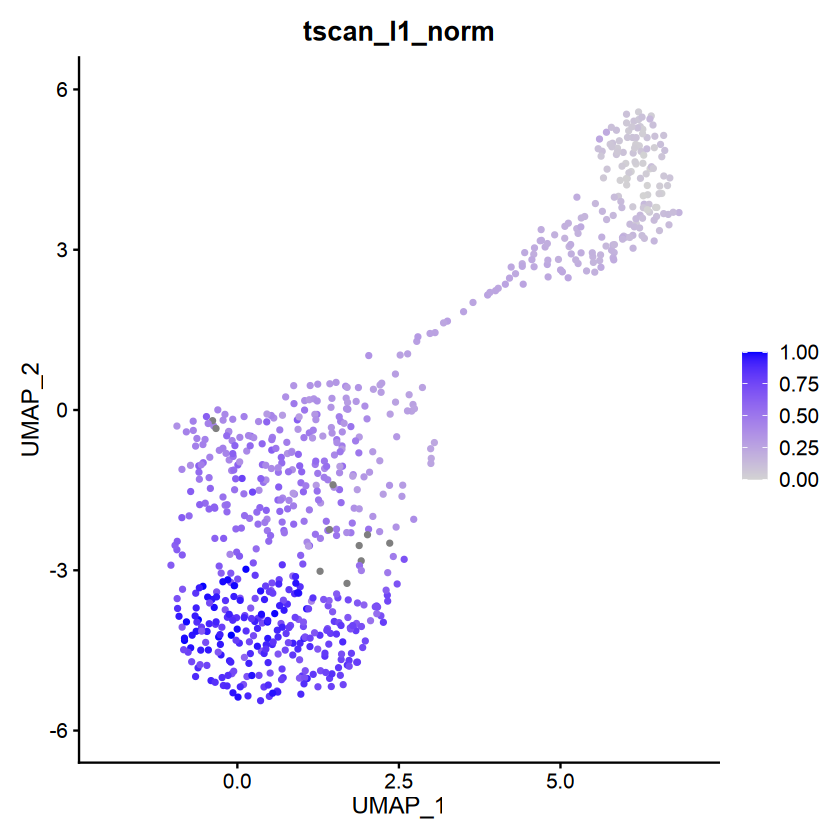

In [132]:
FeaturePlot(seurat_l1, features = c("tscan_l1_norm"), reduction = "umap")

## Slingshot

In [133]:
FQnorm <- function(counts){
    rk <- apply(counts,2,rank,ties.method='min')
    counts.sort <- apply(counts,2,sort)
    refdist <- apply(counts.sort,1,median)
    norm <- apply(rk,2,function(r){ refdist[r] })
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sim_data_l1)$norm <- FQnorm(assays(sim_data_l1)$counts)

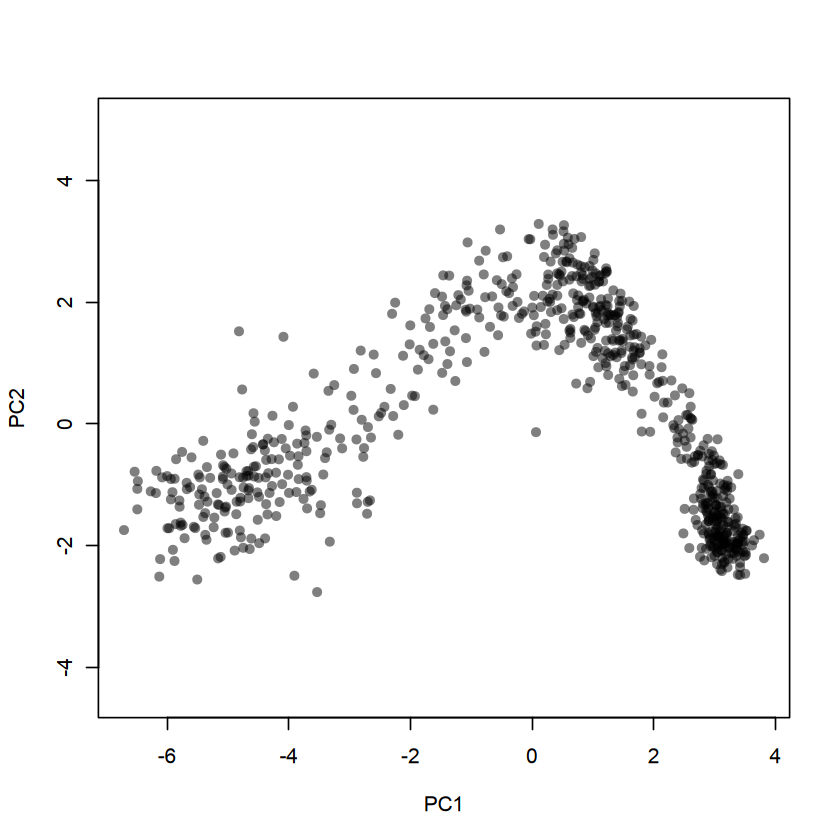

In [134]:
pca <- prcomp(t(log1p(assays(sim_data_l1)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]

plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

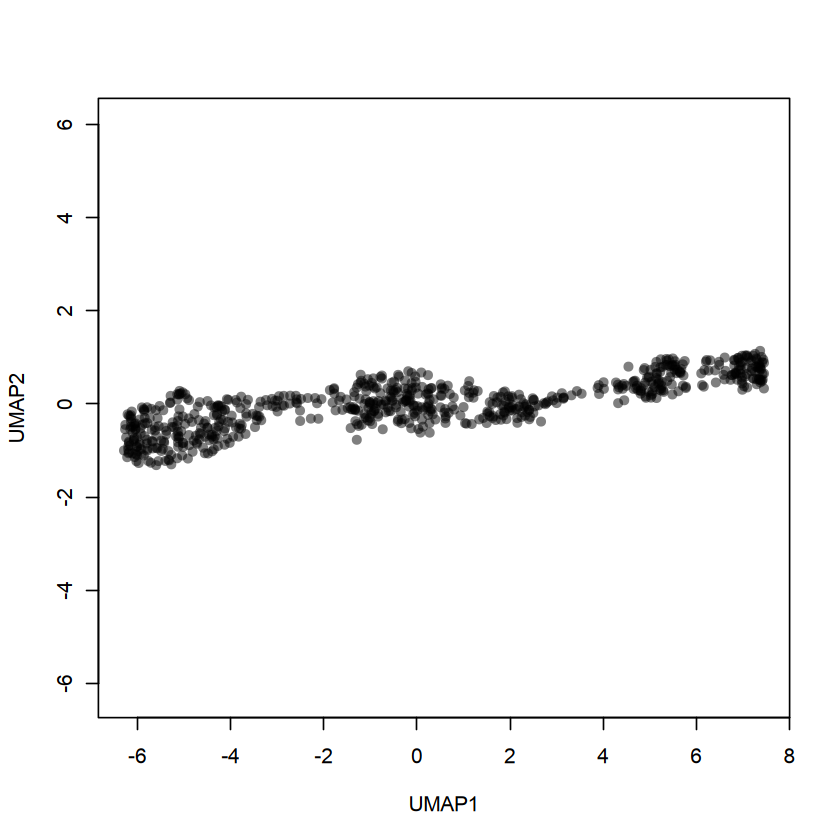

In [135]:
rd2 <- uwot::umap(t(log1p(assays(sim_data_l1)$norm)))
colnames(rd2) <- c('UMAP1', 'UMAP2')

plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1)

In [136]:
reducedDims(sim_data_l1) <- SimpleList(PCA = rd1, UMAP = rd2)

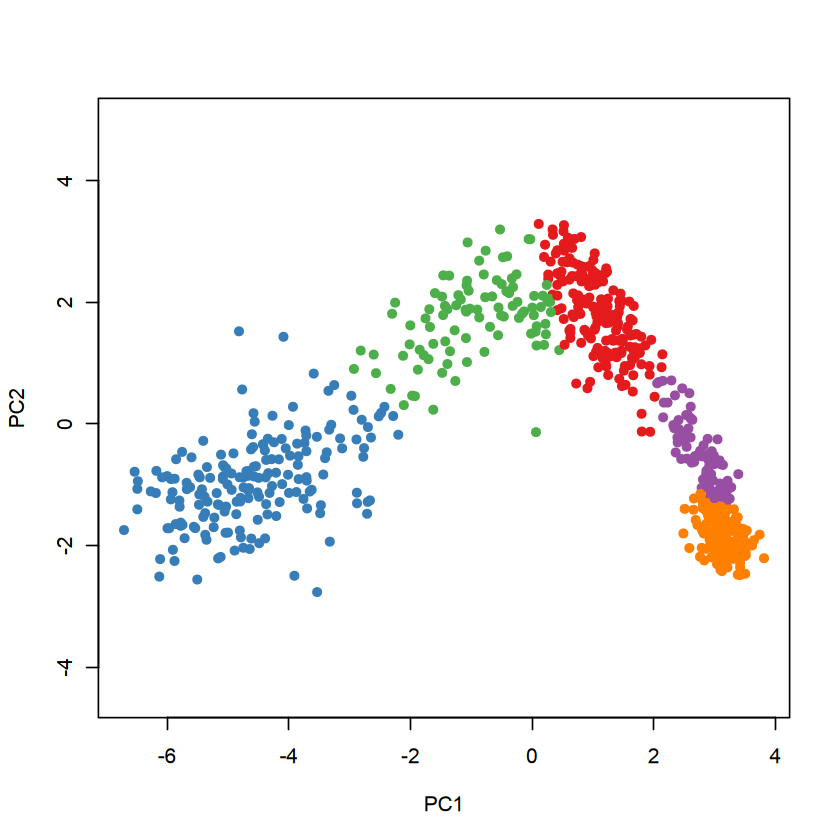

In [137]:
cl1 <- Mclust(rd1)$classification
colData(sim_data_l1)$GMM <- cl1

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

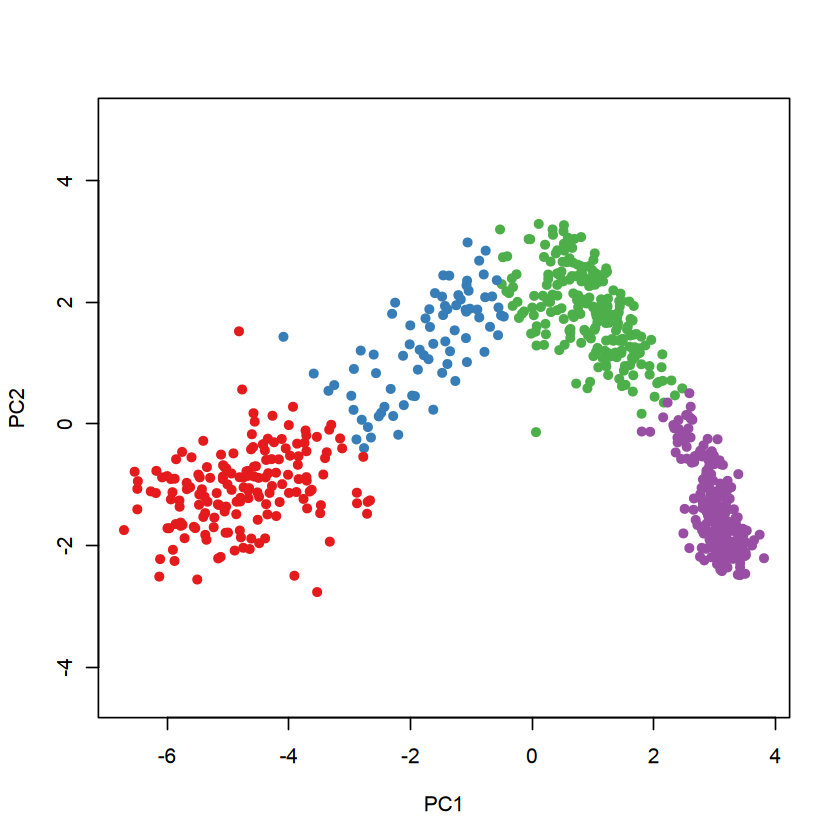

In [138]:
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sim_data_l1)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

In [139]:
sim_data_l1 <- slingshot(sim_data_l1, clusterLabels = 'GMM', reducedDim = 'PCA')

In [140]:
summary(sim_data_l1$slingPseudotime_2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  5.048   7.047   8.724   8.184   9.327   9.948     292 

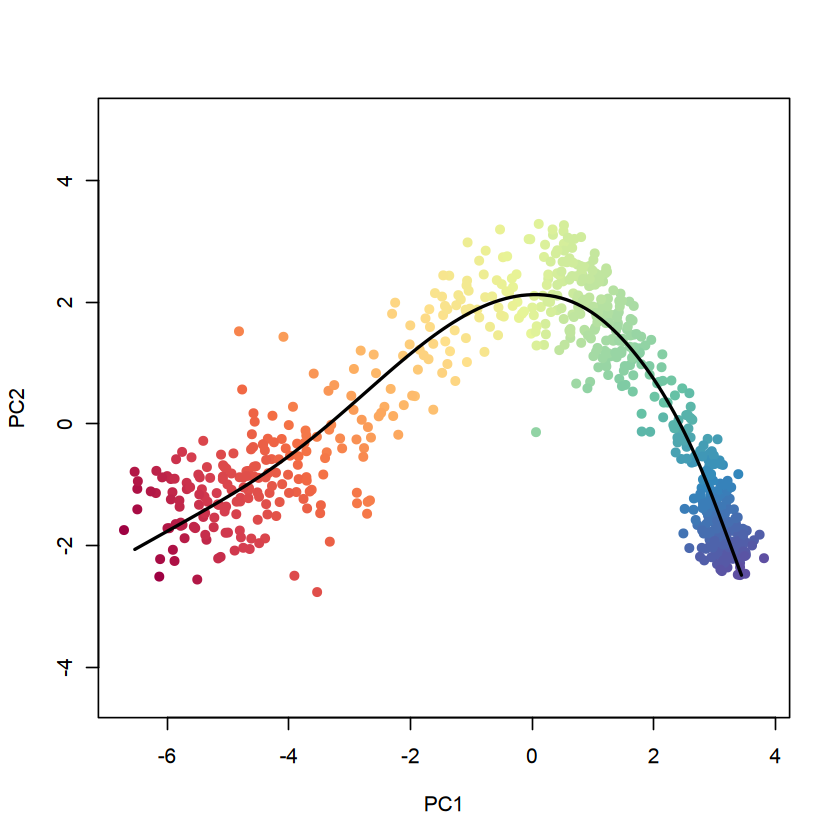

In [141]:
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sim_data_l1@colData@listData[[14]], breaks=100)]

plot(reducedDims(sim_data_l1)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sim_data_l1), lwd=2, col='black')

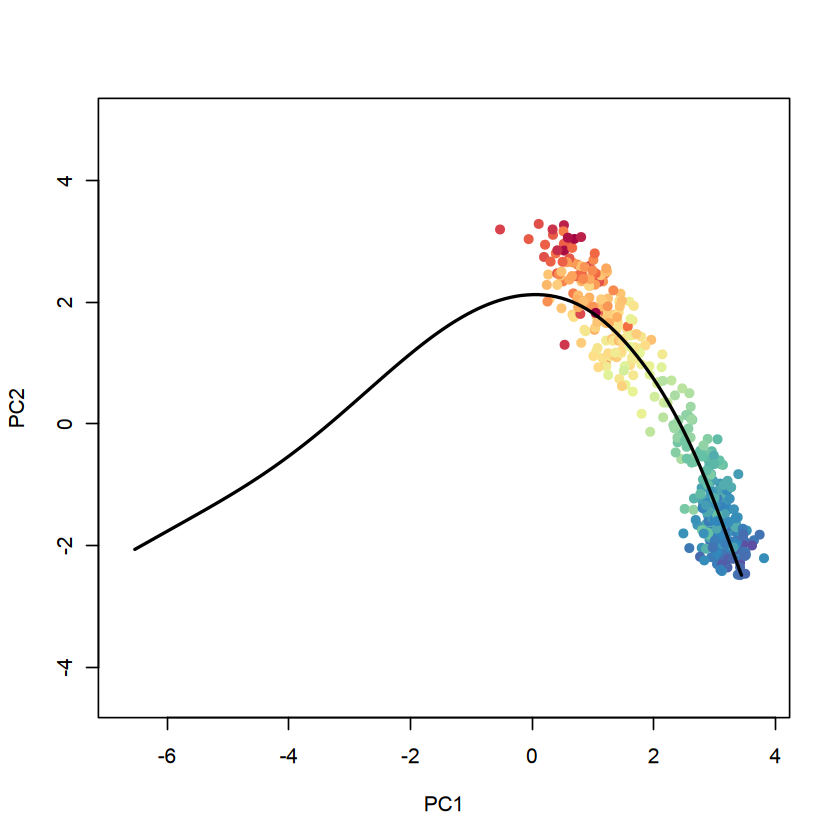

In [142]:
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sim_data_l1$slingPseudotime_2, breaks=100)]

plot(reducedDims(sim_data_l1)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sim_data_l1), lwd=2, col='black')

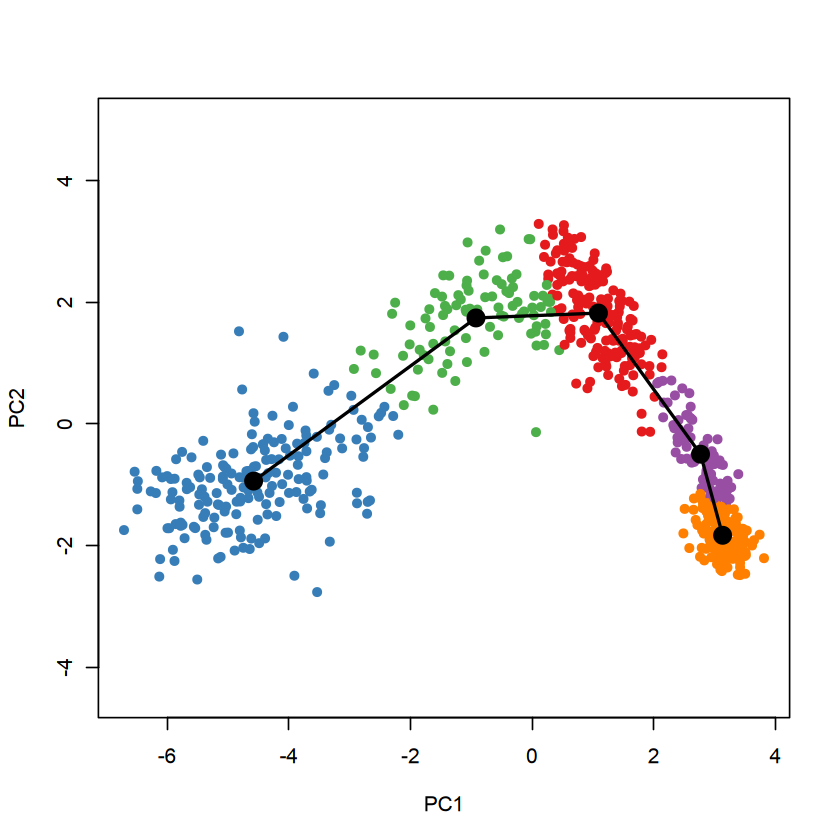

In [143]:
plot(reducedDims(sim_data_l1)$PCA, col = brewer.pal(9,'Set1')[sim_data_l1$GMM], pch=16, asp = 1)
lines(SlingshotDataSet(sim_data_l1), lwd=2, type = 'lineages', col = 'black')

In [144]:
sim_data_l1 <- slingshot(sim_data_l1, clusterLabels = 'kmeans', reducedDim = 'UMAP')

In [145]:
str(sim_data_l1@colData,4)

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:708] "cell2" "cell3" "cell4" "cell5" ...
  ..@ nrows          : int 708
  ..@ elementType    : chr "ANY"
  ..@ elementMetadata: NULL
  ..@ metadata       : list()
  ..@ listData       :List of 15
  .. ..$ step_ix          : int [1:708] 1337 2079 3800 3767 1526 5426 4739 1339 2034 1242 ...
  .. ..$ simulation_i     : int [1:708] 3 4 7 7 3 10 9 3 4 3 ...
  .. ..$ sim_time         : num [1:708] 228 559 574 500 621 ...
  .. ..$ Cell_Type        : chr [1:708] "D" "F" "F" "F" ...
  .. ..$ x                : num [1:708] -342 696 329 610 741 ...
  .. ..$ y                : num [1:708] 296 -135 -639 279 -101 ...
  .. ..$ lineage          : int [1:708] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ r                : num [1:708] 453 709 718 671 748 ...
  .. ..$ GMM              : Named num [1:708] 1 2 2 2 1 2 1 1 2 5 ...
  .. .. ..- attr(*, "names")= chr [1:708] "cell2" "cell3" "cell4" "cell5" ...
  .. ..$ kmeans           

In [146]:
str(sim_data_l1@colData@listData$slingshot,4)

Formal class 'PseudotimeOrdering' [package "TrajectoryUtils"] with 5 slots
  ..@ colData        :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : chr "Lineage1"
  .. .. ..@ nrows          : int 1
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  .. .. ..@ listData       : Named list()
  ..@ assays         :Formal class 'SimpleAssays' [package "SummarizedExperiment"] with 1 slot
  .. .. ..@ data:Formal class 'SimpleList' [package "S4Vectors"] with 4 slots
  ..@ NAMES          : chr [1:708] "cell2" "cell3" "cell4" "cell5" ...
  ..@ elementMetadata:Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 708
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  .. .. ..@ listData       :List of 2
  ..@ metadata       :List of 4
  .. ..$ lineages   :List of 1
  .. .. ..$ 

In [147]:
sim_data_l1@colData@listData[[14]]

[1]  8.4078609  2.1274408  2.2707459  4.5460697  9.9100666  1.8687461
  [7]  9.4493732  8.2471931  4.2570088 12.5749889  2.9339580  7.5575556
 [13] 13.2036033  8.9678741  2.3625539 12.7053036 12.5184315  9.1488270
 [19]  8.1930534  7.3977756 13.3464936  0.4759212  8.7337190  1.9807780
 [25]  1.3062712  8.1723556 13.2695826  8.0811660  3.2240895  2.4173336
 [31] 12.3674775  0.6381415  5.2640238  7.2839438  8.4843243  7.5814048
 [37] 11.8650565  1.2423052  8.5057365 12.3524498  2.0912395  8.7935501
 [43] 12.2525173  7.8645356  6.7360854  0.6216384 12.7152710  2.7024274
 [49] 12.1705043 12.8018084  3.7509910  1.9614627  2.1517913  1.9737714
 [55]  8.2850161 10.8050361 11.9086406  2.7232890  1.7118291 12.7965531
 [61]  1.0370102  6.7492286  3.0005055 10.7573108 12.7354495  1.1662024
 [67]  2.3010322 10.1964240  1.5524679 12.6071260  8.0187327 13.3620586
 [73] 13.5478624  7.0919632  0.7553803 11.2751969  8.5657426  6.1307111
 [79]  8.5489127  2.9957352  6.7226016  2.0283991  8.0068080  9.1881734
 [85]  9.6231473  2.6338284  9.2138632 13.2253572  8.6533069 13.4507061
 [91]  1.1037443  0.6632228  8.7041820  9.3773555  4.6868301  9.2045779
 [97] 12.6050929  2.6098221  2.6937882 13.6223619  9.7414813 12.1367632
[103]  6.3739270  8.7310805  6.6348641  1.5886035  7.5047452 13.5773400
[109] 13.4612175 11.8269461  9.2320705  9.0703229  2.0098208 13.3194169
[115]  6.8702189  1.5537978  1.0549894 13.1948477  9.5508037  8.1936123
[121]  3.2983921  6.6672277  6.3988501  3.5204711 11.8380039 10.3003639
[127]  9.7170750 13.3597799 13.1925168 13.7308707 12.4893865 13.5529833
[133]  2.9880418  5.7341770  0.6529561 13.3428528  2.3501755 12.8780832
[139]  2.9981014  6.4561083  2.8700972  7.9934072  0.9853786  0.9999422
[145]  3.2395768 13.4421479  8.9491250 12.9044193 11.0779518 13.4202708
[151]  9.7150169 13.3198644  6.1157852  9.1122395 12.7549936 11.6297252
[157]  3.0393356  1.4286409 10.4733899  8.4885643 13.4759944  8.3089036
[163]  7.1403808 13.4903686 13.3021071  4.1825181 13.0900965  0.8034283
[169]  9.7218985  2.5243010  4.2649872 10.8365505  8.5737482 13.3490761
[175] 10.0403429  1.2998225  9.8338351  9.4910756 10.7957888 13.1051763
[181] 11.4990314 11.1611069  6.4742888  8.6096647  8.0068080 13.3246913
[187] 10.4769809 13.3935098  2.4201816 13.7302583 13.6040406 11.9987908
[193]  7.8217447  2.0977817 10.3669864  5.7459216  1.9212651 11.8269833
[199]  8.9889520 13.1070430 13.7546749  8.9373386  8.7700555  9.9653236
[205]  2.2350497  9.1107024  8.6353893  9.4321024  0.5225670 13.2323875
[211]  1.6308073 11.3119309  8.2354596 12.5221502 13.4185329 12.6074177
[217] 12.7201196  1.8033857  2.9828353  3.5298121  9.1355405  4.2592190
[223] 12.9410306 12.6311118 11.8863469 12.3990712 10.8820837  2.5649832
[229]  2.9093989 13.6428463 12.6427277  1.8390955 13.4159429  9.8620074
[235]  8.1362572 13.1019335  1.8931024  9.4891894  3.3576822  9.4659234
[241] 13.0548473  8.5686054  8.4440714 13.1924242 12.9036117  8.2180621
[247]  8.7411894 13.2999413 13.3968056 13.2133997  8.2036365  9.0912419
[253] 12.8159059  4.9402959  8.5252903 12.9020596  5.8837291  0.5916971
[259]  7.6323435  3.9873809  8.1519053  9.3787915 13.3902524  7.5502887
[265]  4.9947921  9.6629991  9.8485269 12.6084490  3.9856820  7.2380476
[271]  7.8455124 13.1964705  2.1587904 12.8140290 12.4738110  8.0747943
[277]  8.4973006 13.5286862  9.0983307 12.4938886  8.7442790  5.8609441
[283] 11.4069525 12.5140010  8.9931835 12.9240550 11.9812690 13.4309620
[289] 12.4008679 12.0688023  9.3878127 13.6411649  9.1099149 13.0105362
[295]  1.6267691  3.5328704  3.4550863 11.1726111 12.1111820 13.4197292
[301] 10.7785329  0.8733684  8.9754798  8.7492884  1.7357508 12.2004579
[307]  9.3604457  9.9242280  9.2173692 13.2012463  9.3185076 12.8395914
[313] 12.9515892  8.7808057  9.1454434  8.0669624 10.1784576  9.9070247
[319] 13.8999030  8.2525599  9.1726970  8.8586754 12.5196346  7.4860579
[325]  7.5530578 13.7983711  6.8986305  3.7951823  7.4744626  9.4651523
[331]  8.2200337 12.0728527  1.6038099 12.

In [148]:
summary(sim_data_l1$slingPseudotime_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  5.052   6.956   9.402   9.758  12.529  14.734     299 

In [149]:
summary(sim_data_l1$slingPseudotime_2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  5.048   7.047   8.724   8.184   9.327   9.948     292 

In [150]:
slingshot_l1_rank <- rank(sim_data_l1$slingPseudotime_1,ties.method = 'random', na.last = 'keep')
slingshot_l1_norm <- scales::rescale(slingshot_l1_rank,to = c(0,1))

In [151]:
seurat_l1@meta.data$slingshot_l1_norm = slingshot_l1_norm
seurat_l1@meta.data$slingshot_l1 = sim_data_l1$slingPseudotime_1

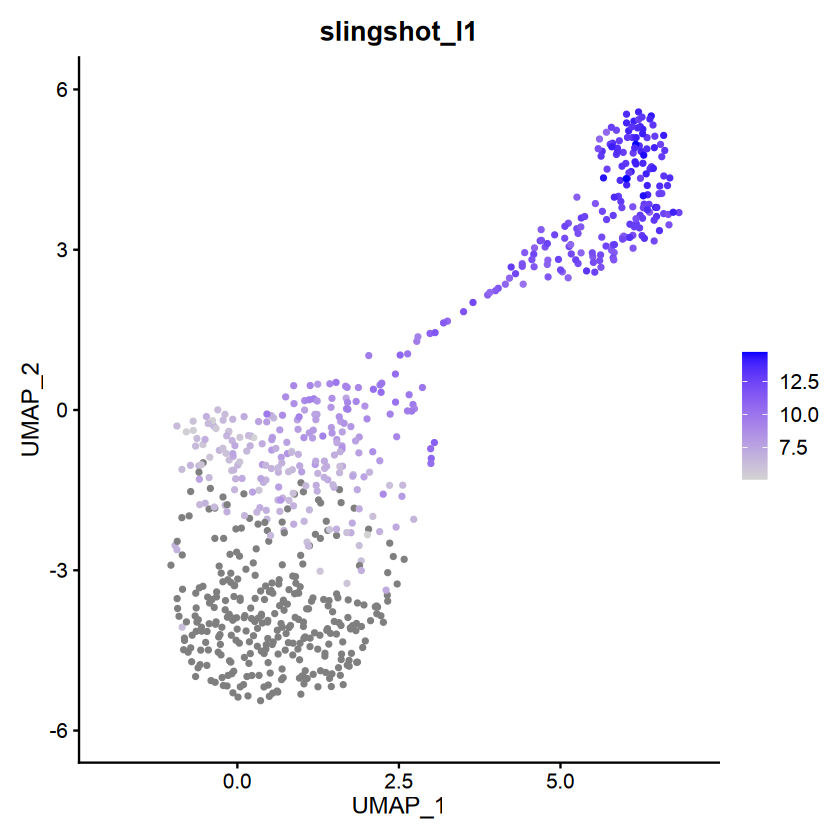

In [152]:
FeaturePlot(seurat_l1, features = c("slingshot_l1"), reduction = "umap")

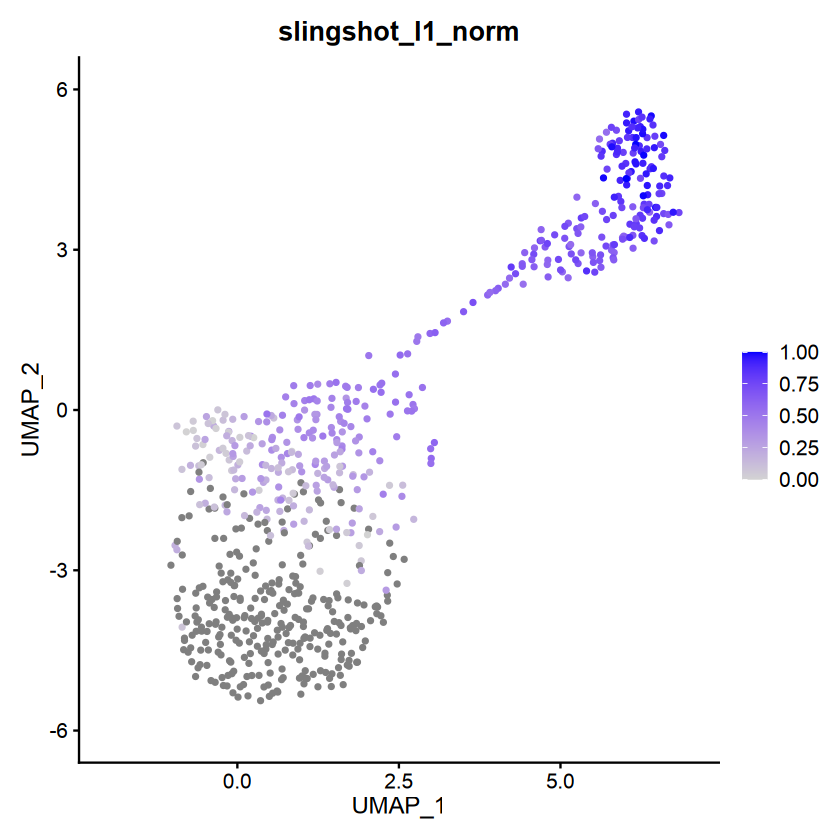

In [153]:
FeaturePlot(seurat_l1, features = c("slingshot_l1_norm"), reduction = "umap")

## comparison

In [154]:
head(seurat_l1@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell2 SeuratProject  249        74          1337     3           227.5431
cell3 SeuratProject 1023       109          2079     4           558.6239
cell4 SeuratProject  517       102          3800     7           573.5479
cell5 SeuratProject  318        79          3767     7           500.1175
cell6 SeuratProject  263        84          1526     3           620.8488
cell7 SeuratProject  515       108          5426    10           383.2188
      Cell_Type x         y         lineage ⋯ slingshot_norm slingshot
cell2 D         -342.3892  295.9027 1       ⋯ 0.4681754      6.345731 
cell3 F          696.1339 -134.7557 1       ⋯        NA            NA 
cell4 F          329.3906 -638.5099 1       ⋯        NA            NA 
cell5 F          610.3327  278.5673 1       ⋯        NA            NA 
cell6 F          740.6564 -100.9556 1       ⋯ 0.4922207      6.556258 
cell7 E          473.2788 -347.7126 1       ⋯        NA            NA 
      dpt_l1_norm dpt_l1    monocle3_l1_norm monocle3_l1 tscan_l1_norm tscan_l1
cell2 0.5459689   0.1786774 0.5714286         8.435878   0.43472023    304     
cell3 0.9702970   2.1443664 0.8670438        15.868064   0.01865136     14     
cell4 0.8585573   1.4917856 0.8599717        15.725070   0.14490674    102     
cell5 0.7241867   0.4847820 0.7157001        10.630604   0.28550933    200     
cell6 0.3649222   0.1396817 0.3932107         7.648531           NA     NA     
cell7 0.8613861   1.5360107 0.9009901        16.363354   0.14347202    101     
      slingshot_l1_norm slingshot_l1
cell2 0.14950980         6.590643   
cell3 0.76225490        12.560731   
cell4 0.78186275        12.727012   
cell5 0.54656863        10.400071   
cell6 0.05882353         6.077650   
cell7 0.81617647        12.879272

In [155]:
seurat_l1@meta.data$dpt_l1_rank = rank(seurat_l1@meta.data$dpt, ties.method = 'random', na.last = 'keep')
seurat_l1@meta.data$dpt_l1_norm <- scales::rescale(seurat_l1@meta.data$dpt_l1_rank,to = c(0,1))


In [156]:
seurat_l1@meta.data$sim_time_l1_rank = rank(seurat_l1@meta.data$sim_time, ties.method = 'random', na.last = 'keep')
seurat_l1@meta.data$sim_time_l1_norm <- scales::rescale(seurat_l1@meta.data$sim_time_l1_rank,to = c(0,1))

In [157]:
long_df <- gather(seurat_l1@meta.data[,c("dpt_l1_norm", "monocle3_l1_norm", "tscan_l1_norm", "slingshot_l1_norm", "sim_time_l1_norm", "Cell_Type", "lineage")], key = "variable", value = "value", -sim_time_l1_norm, -Cell_Type, -lineage)
colnames(long_df) = c('sim_time_l1_norm', 'Cell_Type', 'lineage', 'method', 'value')
long_df$method[long_df$method=='dpt_l1_norm'] = "DPT"
long_df$method[long_df$method=='monocle3_l1_norm'] = "monocle3"
long_df$method[long_df$method=='tscan_l1_norm'] = "TSCAN"
long_df$method[long_df$method=='slingshot_l1_norm'] = "Slingshot"
head(long_df)

sim_time_l1_norm Cell_Type lineage method value    
1 0.5275813        D         1       DPT    0.5403112
2 0.8175389        F         1       DPT    0.9702970
3 0.8274399        F         1       DPT    0.8571429
4 0.7567185        F         1       DPT    0.7241867
5 0.8444130        F         1       DPT    0.4992928
6 0.6548798        E         1       DPT    0.8613861

In [158]:
cor.test(seurat_l1@meta.data$sim_time_l1_norm, seurat_l1@meta.data$dpt_l1_norm, na.rm=T)$estimate
cor.test(seurat_l1@meta.data$sim_time_l1_norm, seurat_l1@meta.data$monocle3_l1_norm, na.rm=T)$estimate
cor.test(seurat_l1@meta.data$sim_time_l1_norm, seurat_l1@meta.data$tscan_l1_norm, na.rm=T)$estimate
cor.test(seurat_l1@meta.data$sim_time_l1_norm, seurat_l1@meta.data$slingshot_l1_norm, na.rm=T)$estimate

cor 
0.9189714

cor 
0.9018738

cor 
-0.9101548

cor 
0.6804845

In [159]:
correlations <- data.frame(
  method = c("DPT", "monocle3", "TSCAN", "Slingshot"),
  correlation = c(abs(cor(seurat_l1@meta.data$sim_time_l1_norm, seurat_l1@meta.data$dpt_l1_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l1@meta.data$sim_time_l1_norm, seurat_l1@meta.data$monocle3_l1_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l1@meta.data$sim_time_l1_norm, seurat_l1@meta.data$tscan_l1_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l1@meta.data$sim_time_l1_norm, seurat_l1@meta.data$slingshot_l1_norm, method = "spearman", use = "complete.obs")))
)
head(correlations)

method    correlation
1 DPT       0.9189714  
2 monocle3  0.9018738  
3 TSCAN     0.9116533  
4 Slingshot 0.6812243

In [160]:
correlations_ = correlations
correlations_$lineage = "lineage1"
all_correlations = rbind(all_correlations, correlations_)
all_correlations

method    correlation lineage 
1 DPT       0.8444481   all     
2 monocle3  0.8352968   all     
3 TSCAN     0.8587912   all     
4 Slingshot 0.9062563   all     
5 DPT       0.9189714   lineage1
6 monocle3  0.9018738   lineage1
7 TSCAN     0.9116533   lineage1
8 Slingshot 0.6812243   lineage1

In [161]:
correlation_with_gt <- data.frame(
  method = c("DPT", "monocle3", "TSCAN", "Slingshot"),
  correlation = c(abs(cor(seurat_l1@meta.data$r, seurat_l1@meta.data$dpt, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l1@meta.data$r, seurat_l1@meta.data$monocle3, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l1@meta.data$r, seurat_l1@meta.data$tscan, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l1@meta.data$r, seurat_l1@meta.data$slingshot, method = "spearman", use = "complete.obs")))
)
head(correlation_with_gt)

method    correlation
1 DPT       0.9189681  
2 monocle3  0.9096660  
3 TSCAN     0.8773996  
4 Slingshot 0.8950634

In [162]:
correlations_ = correlation_with_gt
correlations_$lineage = "lineage1"
all_correlation_with_gt = rbind(all_correlation_with_gt, correlations_)
all_correlation_with_gt

method    correlation lineage 
1 ONTraC    0.9918385   all     
2 DPT       0.6533595   all     
3 monocle3  0.5715255   all     
4 TSCAN     0.4949265   all     
5 Slingshot 0.5064056   all     
6 DPT       0.9189681   lineage1
7 monocle3  0.9096660   lineage1
8 TSCAN     0.8773996   lineage1
9 Slingshot 0.8950634   lineage1

In [163]:
long_df <- left_join(long_df, correlations, by = "method")
head(long_df)

sim_time_l1_norm Cell_Type lineage method value     correlation
1 0.5275813        D         1       DPT    0.5403112 0.9189714  
2 0.8175389        F         1       DPT    0.9702970 0.9189714  
3 0.8274399        F         1       DPT    0.8571429 0.9189714  
4 0.7567185        F         1       DPT    0.7241867 0.9189714  
5 0.8444130        F         1       DPT    0.4992928 0.9189714  
6 0.6548798        E         1       DPT    0.8613861 0.9189714

Warning message:
“Removed 309 rows containing missing values (`geom_point()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 309 rows containing missing values (`geom_point()`).”


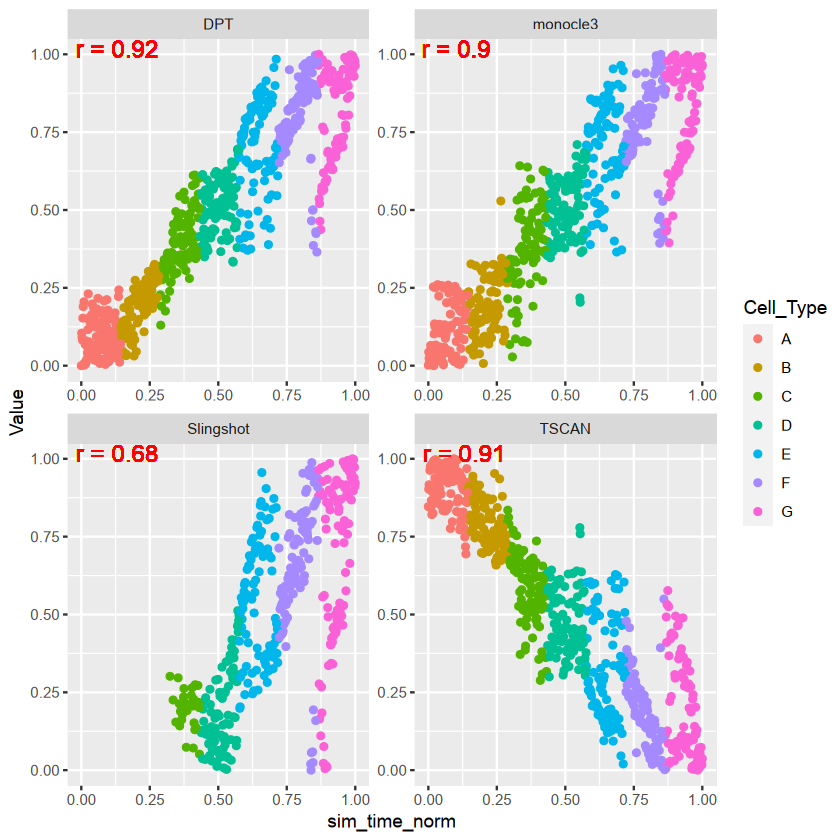

In [164]:
ggplot(long_df, aes(x = sim_time_l1_norm, y = value, color=Cell_Type, palette="Set1")) + 
  geom_point() + 
  facet_wrap(~method, scales = "free") +
  geom_text(aes(label = paste("r =", round(correlation, 2))), x = -Inf, y = Inf, hjust = -0.1, vjust = 1.1, color = "red", size = 5) +
  xlab("sim_time_norm") + 
  ylab("Value")
ggsave("Pseudotime_lineage1_comparison_cell_type.pdf")

# Lineage 2

## subset sce and seurat

In [165]:
sim_data_l2 <- sim_data[,sim_data@colData$lineage == 2]

In [166]:
dim(sim_data_l2)

[1] 135 292

In [167]:
head(ss0@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell1 SeuratProject  395        88          5161    9            990.2580
cell2 SeuratProject  249        74          1337    3            227.5431
cell3 SeuratProject 1023       109          2079    4            558.6239
cell4 SeuratProject  517       102          3800    7            573.5479
cell5 SeuratProject  318        79          3767    7            500.1175
cell6 SeuratProject  263        84          1526    3            620.8488
      Cell_Type x         y         lineage ⋯ sim_time_norm Cell_NTScore
cell1 J         -476.7610  621.2420 2       ⋯ 0.9959960     0.9226104   
cell2 D         -342.3892  295.9027 1       ⋯ 0.3753754     0.6154288   
cell3 F          696.1339 -134.7557 1       ⋯ 0.7657658     0.8448661   
cell4 F          329.3906 -638.5099 1       ⋯ 0.7767768     0.9180524   
cell5 F          610.3327  278.5673 1       ⋯ 0.6916917     0.8193589   
cell6 F          740.6564 -100.9556 1       ⋯ 0.7937938     0.8560733   
      dpt_norm  dpt       monocle3_norm monocle3  tscan_norm tscan
cell1 0.6756757 0.4910829 0.8628629     16.761602 0.8746867  699  
cell2 0.3823824 0.1720047 0.4584585      8.408949 0.5764411  461  
cell3 0.9789790 2.3243231 0.7767768     15.755698        NA   NA  
cell4 0.8988989 1.5799136 0.7207207     14.822861        NA   NA  
cell5 0.6226226 0.4515718 0.5565566     11.168129        NA   NA  
cell6 0.3533534 0.1645560 0.3733734      7.117197 0.6629073  530  
      slingshot_norm slingshot
cell1 0.2786421      2.163809 
cell2 0.4681754      6.345731 
cell3        NA            NA 
cell4        NA            NA 
cell5        NA            NA 
cell6 0.4922207      6.556258

In [168]:
seurat_l2 = subset(ss0, cells=rownames(ss0@meta.data[ss0@meta.data$lineage == 2,]))

In [169]:
dim(seurat_l2)

[1] 135 292

In [170]:
seurat_l2@meta.data[seurat_l2@meta.data$sim_time==min(seurat_l2@meta.data$sim_time),]

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell375 SeuratProject 276        81           174     1            199.089 
        Cell_Type x        y        lineage ⋯ sim_time_norm Cell_NTScore
cell375 H         851.5355 356.7394 2       ⋯ 0.3523524     0.8953746   
        dpt_norm  dpt       monocle3_norm monocle3 tscan_norm tscan
cell375 0.4084084 0.1790765 0.2532533     4.516884 0.6491228  519  
        slingshot_norm slingshot
cell375 0.4455446      6.009084

In [171]:
root.use = rownames(seurat_l2@meta.data[seurat_l2@meta.data$sim_time==min(seurat_l2@meta.data$sim_time),])

## DPT

In [172]:
library(destiny)

In [173]:
dm.use.2 <- DiffusionMap(data = sim_data_l2)

Warning message in (function (data, k, ..., query = NULL, distance = c("euclidean", :
“find_knn does not yet support sparse matrices, converting data to a dense matrix.”


In [174]:
seurat_l2[['dmap']] <- CreateDimReducObject(embeddings = dm.use.2@eigenvectors,assay = 'RNA',stdev = dm.use.2@eigenvalues,key = 'DC_')

In [175]:

dpt.use.2 = DPT(dm.use.2,tips = c(1,2))
dpt_l2_rank = rank(dpt.use.2$dpt,ties.method = 'random', na.last = 'keep')
seurat_l2@meta.data$dpt_l2_norm <- scales::rescale(dpt_l2_rank,to = c(0,1))
seurat_l2@meta.data$dpt_l2 = dpt.use.2$dpt

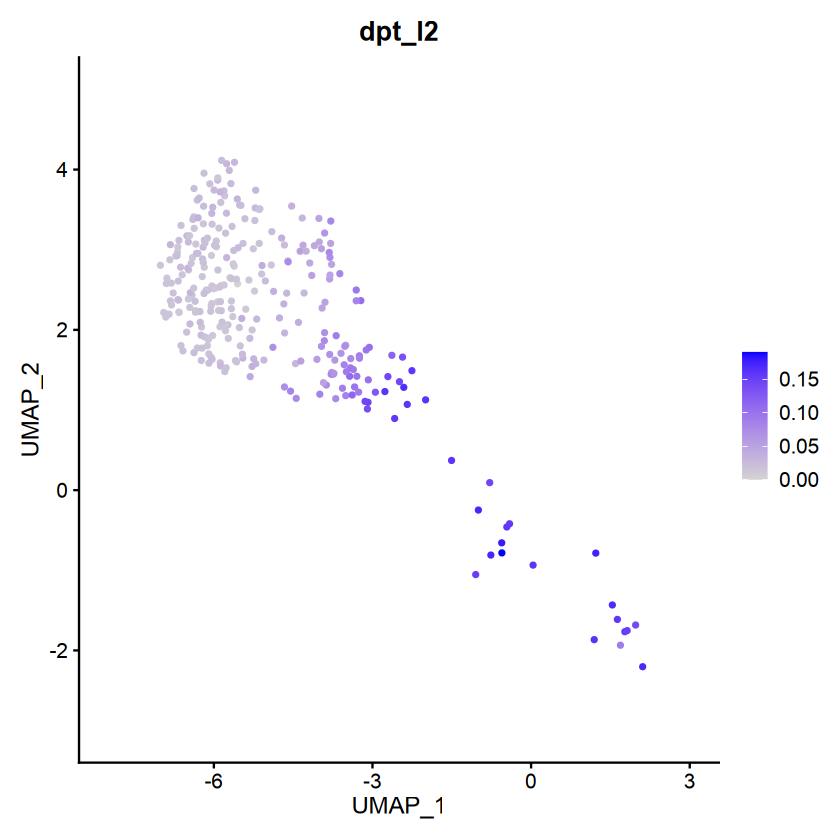

In [176]:
FeaturePlot(seurat_l2, features = c("dpt_l2"), reduction = "umap")

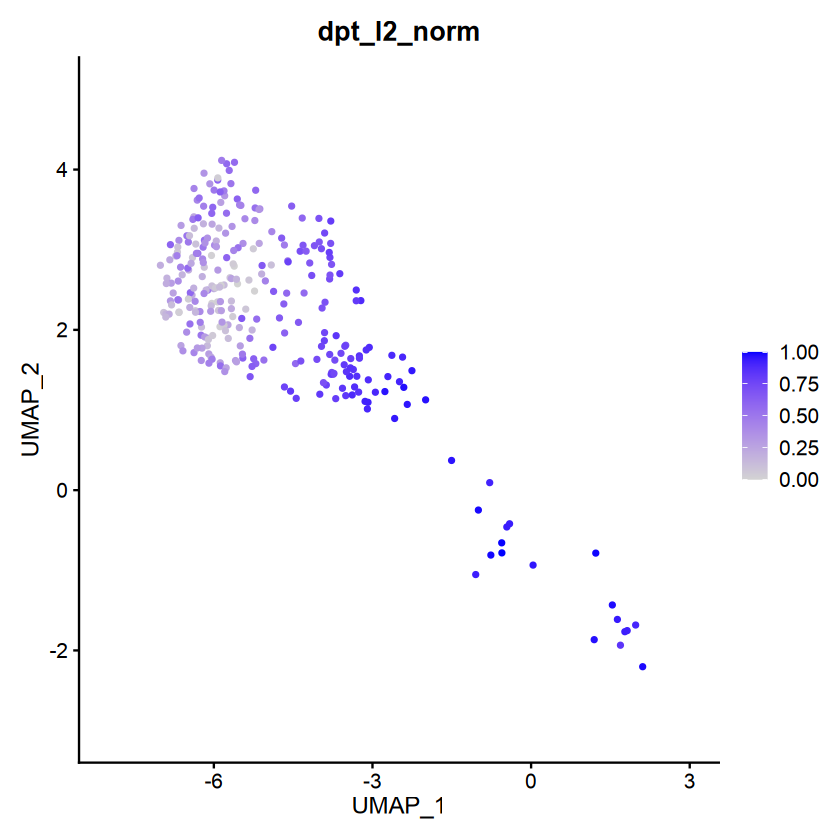

In [177]:
FeaturePlot(seurat_l2, features = c("dpt_l2_norm"), reduction = "umap")

## monocle

In [178]:
gene_annotation <- as.data.frame(sim_data_l2@assays@data@listData$counts@Dimnames[[1]], row.names = sim_data_l2@assays@data@listData$counts@Dimnames[[1]])
colnames(gene_annotation) <- "gene_short_name"

cds <- new_cell_data_set(sim_data_l2@assays@data@listData$counts,
                         cell_metadata = sim_data_l2@colData,
                         gene_metadata = gene_annotation)

In [179]:
cds <- preprocess_cds(cds, method = "PCA", num_dim = 20)

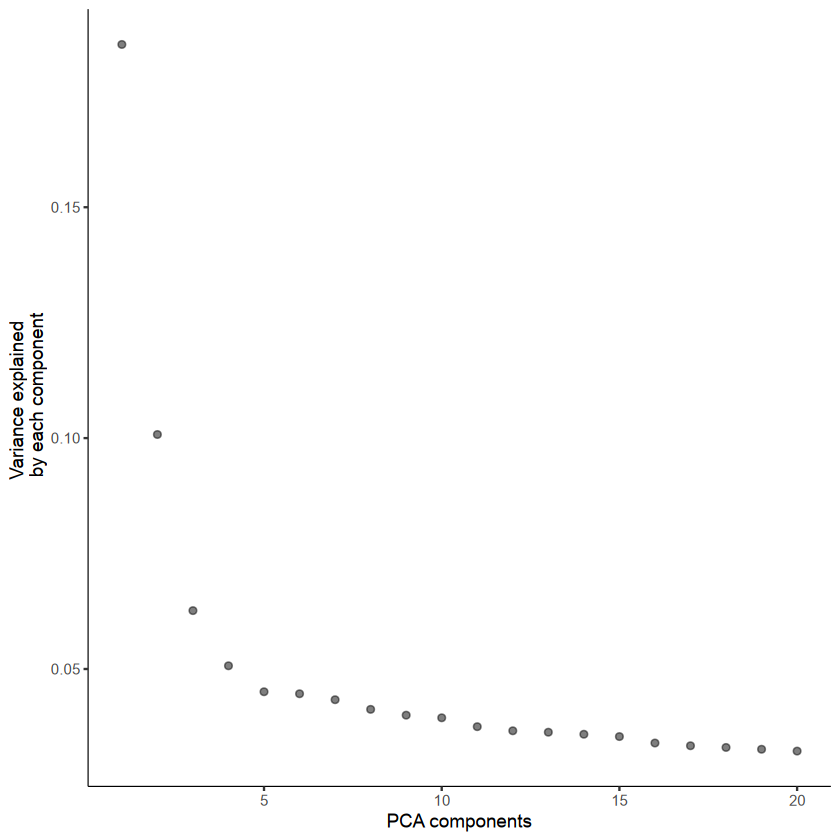

In [180]:
plot_pc_variance_explained(cds)

In [181]:
# cds <- reduce_dimension(cds, reduction_method = "UMAP", preprocess_method = "PCA", umap.min_dist=0.1, umap.n_neighbors= 15L)
cds <- reduce_dimension(cds, reduction_method = "UMAP", preprocess_method = "PCA")

In [182]:
# plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "Cell_Type")

In [183]:
cds <- cluster_cells(cds, reduction_method = "UMAP")

In [184]:
# plot_cells(cds, reduction_method = "UMAP", color_cells_by = 'cluster', group_label_size = 5)     

In [185]:
cds <- learn_graph(cds, use_partition=TRUE)

  |======================================================================| 100%


In [186]:
# visualise the learned trajectory
# plot_cells(cds,
#            color_cells_by = "Cell_Type",
#            label_cell_groups=FALSE,
#            label_groups_by_cluster=FALSE,
#            label_leaves=FALSE,
#            label_branch_points=FALSE)

In [187]:
# visualise the learned trajectory
# plot_cells(cds,
#            color_cells_by = "sim_time",
#            label_cell_groups=FALSE,
#            label_groups_by_cluster=FALSE,
#            label_leaves=FALSE,
#            label_branch_points=FALSE)

In [188]:
cds <- order_cells(cds, root_cells=root.use)

In [189]:
# plot_cells(cds,
#            color_cells_by = "pseudotime",
#            label_cell_groups=FALSE,
#            label_leaves=FALSE,
#            label_branch_points=FALSE,
#            graph_label_size=1.5)

In [190]:
pseudotime <- pseudotime(cds) 

In [191]:
length(pseudotime)

[1] 292

In [192]:
monocle3_l2_rank <- rank(pseudotime,ties.method = 'random', na.last = 'keep')
monocle3_l2_norm <- scales::rescale(monocle3_l2_rank,to = c(0,1))

In [193]:
seurat_l2@meta.data$monocle3_l2_norm <- monocle3_l2_norm
seurat_l2@meta.data$monocle3_l2 = pseudotime

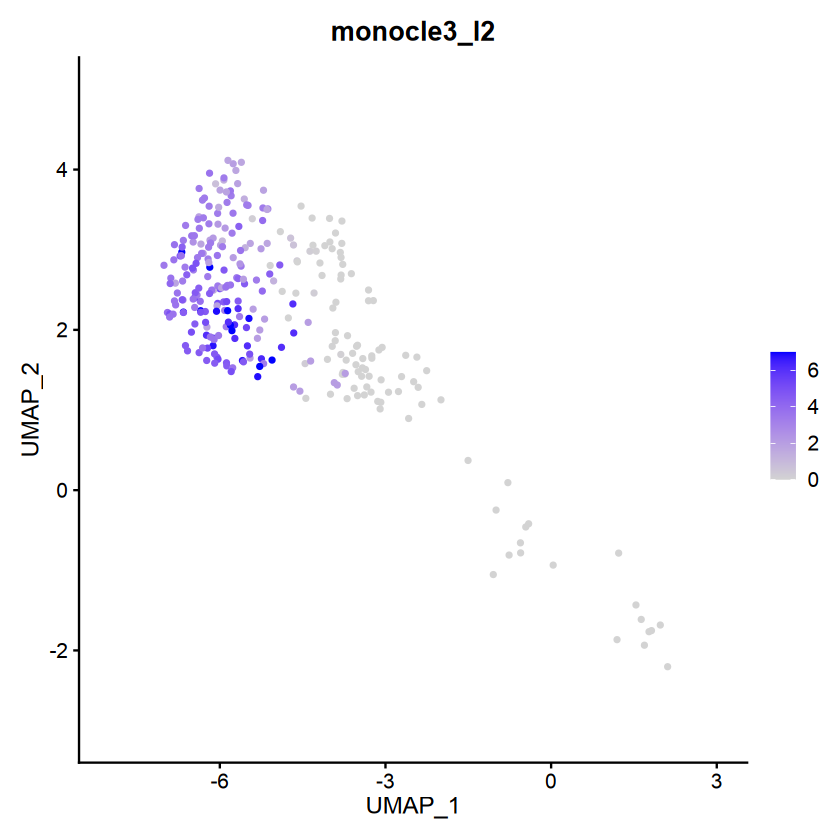

In [194]:
FeaturePlot(seurat_l2, features = c("monocle3_l2"), reduction = "umap")

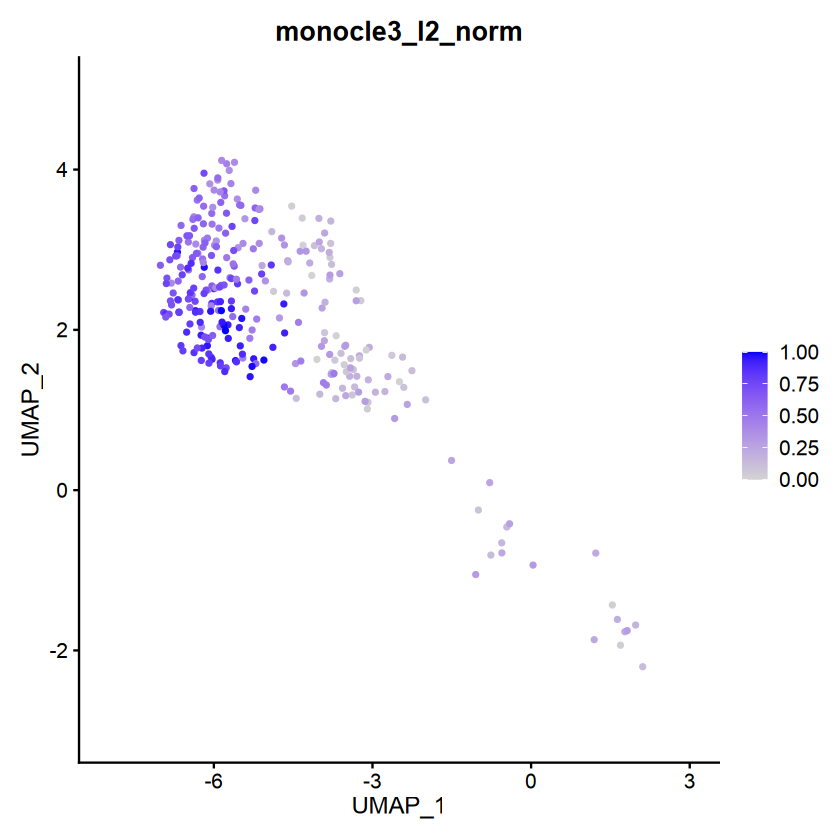

In [195]:
FeaturePlot(seurat_l2, features = c("monocle3_l2_norm"), reduction = "umap")

## TSCAN

In [196]:
library(TSCAN)

In [197]:
exp <- as.matrix(seurat_l2@assays$RNA@data)
procdata <- preprocess(exp, minexpr_value = 0, minexpr_percent = 0.001, cvcutoff = 0.01)


In [198]:
lpsmclust <- exprmclust(procdata)
tscan_order = TSCANorder(lpsmclust)

In [199]:
str(lpsmclust, 2)

List of 4
 $ pcareduceres: num [1:292, 1:3] -2.23 -2.63 -2.55 -3.22 -1.13 ...
  ..- attr(*, "dimnames")=List of 2
 $ MSTtree     :Class 'igraph'  hidden list of 10
  ..$ : num 2
  ..$ : logi FALSE
  ..$ : num 1
  ..$ : num 0
  ..$ : NULL
  ..$ : NULL
  ..$ : NULL
  ..$ : NULL
  ..$ :List of 4
  ..$ :<environment: 0x558d6639e540> 
 $ clusterid   : Named int [1:292] 1 1 1 1 1 1 1 1 1 2 ...
  ..- attr(*, "names")= chr [1:292] "cell1" "cell12" "cell18" "cell25" ...
 $ clucenter   : num [1:2, 1:3] -2.054 3.448 0.475 -0.798 0.393 ...


In [200]:
head(tscan_order)

sample_name State Pseudotime
cell485 cell485     1     1         
cell520 cell520     1     2         
cell873 cell873     1     3         
cell930 cell930     1     4         
cell317 cell317     1     5         
cell302 cell302     1     6

In [201]:
tail(tscan_order)

sample_name State Pseudotime
cell825 cell825     2     287       
cell743 cell743     2     288       
cell107 cell107     2     289       
cell834 cell834     2     290       
cell306 cell306     2     291       
cell375 cell375     2     292

In [202]:
tscan_order[rownames(seurat_l2@meta.data),"Pseudotime"]

[1]  74  95  73  23  97  54  38 119 182 210 231 105  85 239  47  89 207 269
 [19]  96 134 143 229 214 289 163 244  40 173 249  68 153 168  31 140 124  83
 [37] 131 277  20 213 160 110  57 226 165 264 259  61 109 273 171  36  48  27
 [55] 199  94 258 208  14 205 120 206 209 104 253 261  43  72 179 152  39  77
 [73] 150 247 248   6  82 291 234 169   5  51  32  13 136 102  80  66 127  56
 [91]  62  15 103  41 158 122 116 135 272 178  29 292 191 188 271 159 121 257
[109] 172  55  24 281 167 125  65 164 111 250 262 267 142 195 117   9  84 279
[127]  18  22  45 222  60 192 157  70   1  50 108 184  35 237 154 101  93 286
[145] 187 185  37   2 176 147 246 263 183   8 128 224 139  64 193 203 245  71
[163]  91 133  69  44 200  12 186 241 162  90 243 141 166 114 100 112  81 260
[181] 177 148 240 233 223 219 251 190 155 216 175 156 194 284  52  63   7 236
[199] 227 115 161 218 149 170  42 144 275  19 230  16 118 283 278  10 252  99
[217] 225 146 113 238 288  87 265 197 255  78 211  86  67 137 220 106  46  21
[235]  75 242  33  49  88 270  17  30 196 189 287 290 130 132 129  34 181 123
[253] 174 212  79 202   3 217 201 204  58 266 256 282 126 235 228  53 215 151
[271]  98  76   4  11 254  25  92 274 268 198 276 232 280  26 180 145  59 285
[289]  28 138 221 107

In [203]:
tscan_l2_rank = rank(tscan_order[rownames(seurat_l2@meta.data),"Pseudotime"], ties.method = 'random', na.last = 'keep')
tscan_l2_norm = scales::rescale(tscan_l2_rank,to = c(0,1))
seurat_l2@meta.data$tscan_l2_norm = tscan_l2_norm
seurat_l2@meta.data$tscan_l2 = tscan_order[rownames(seurat_l2@meta.data),"Pseudotime"]

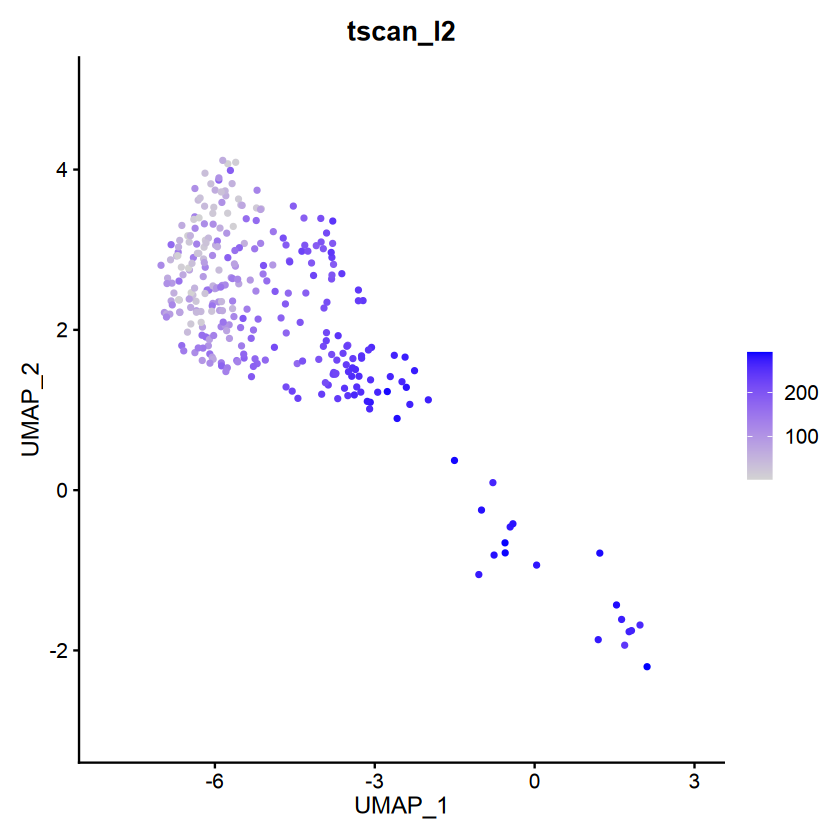

In [204]:
FeaturePlot(seurat_l2, features = c("tscan_l2"), reduction = "umap")

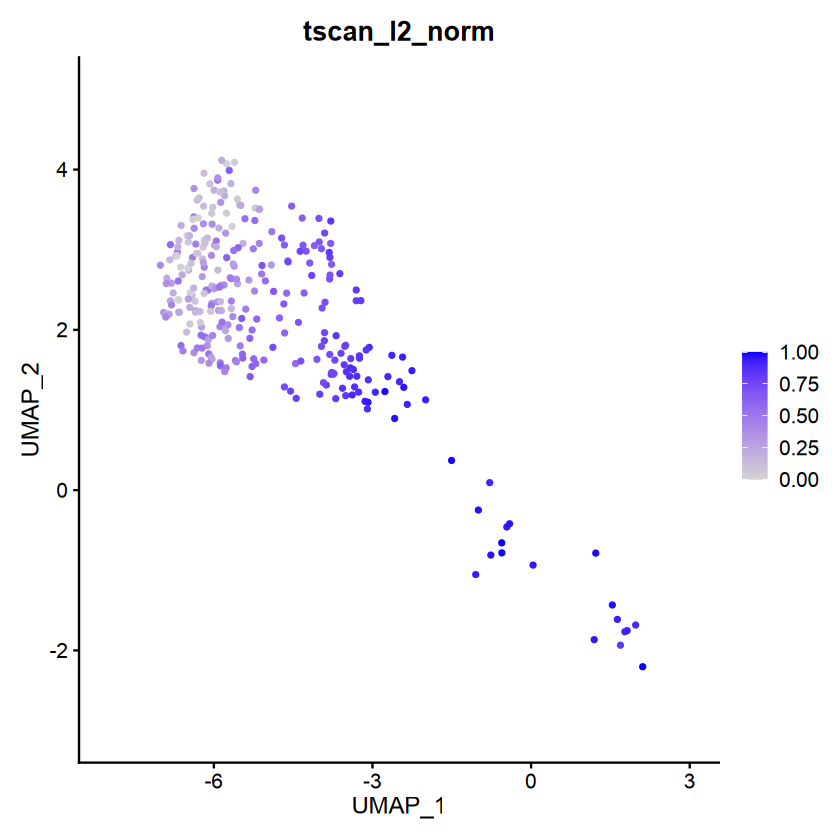

In [205]:
FeaturePlot(seurat_l2, features = c("tscan_l2_norm"), reduction = "umap")

## Slingshot

In [206]:
FQnorm <- function(counts){
    rk <- apply(counts,2,rank,ties.method='min')
    counts.sort <- apply(counts,2,sort)
    refdist <- apply(counts.sort,1,median)
    norm <- apply(rk,2,function(r){ refdist[r] })
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sim_data_l2)$norm <- FQnorm(assays(sim_data_l2)$counts)

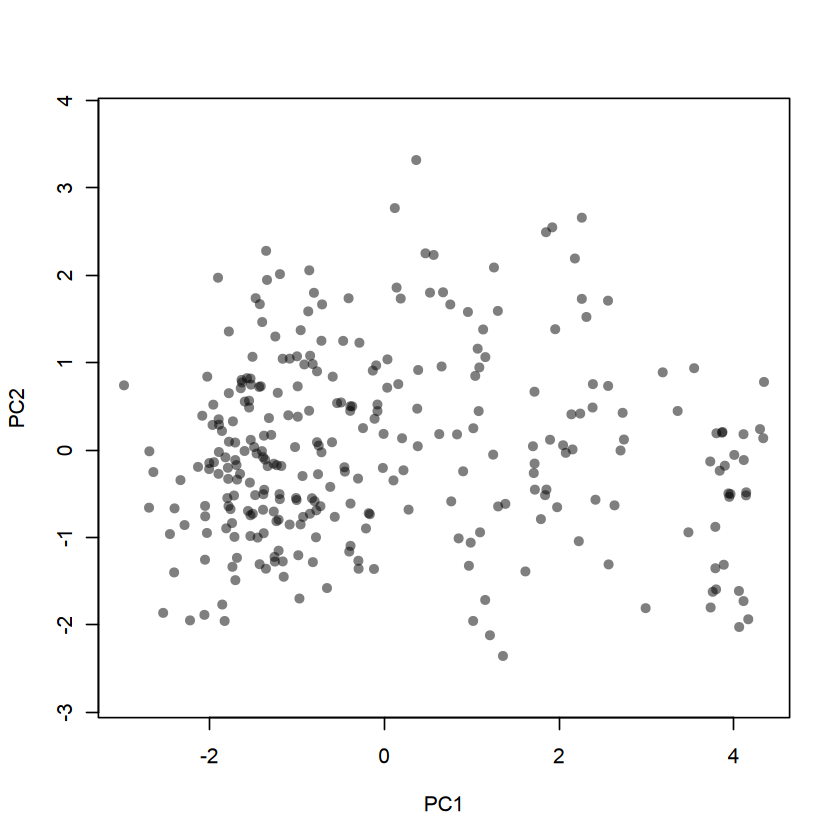

In [207]:
pca <- prcomp(t(log1p(assays(sim_data_l2)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]

plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

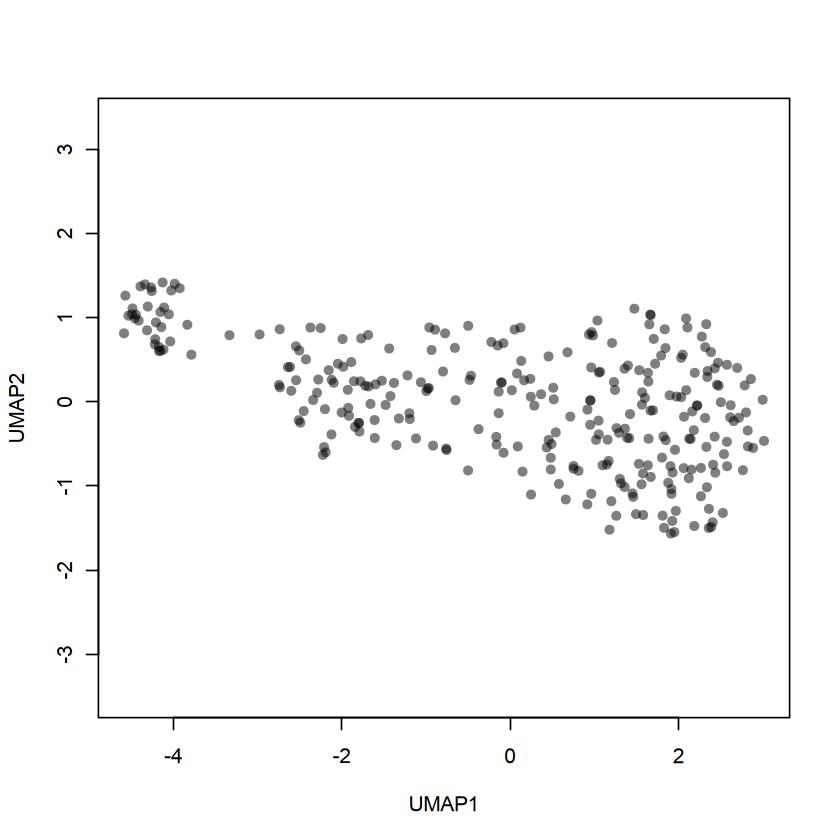

In [208]:
rd2 <- uwot::umap(t(log1p(assays(sim_data_l2)$norm)))
colnames(rd2) <- c('UMAP1', 'UMAP2')

plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1)

In [209]:
reducedDims(sim_data_l2) <- SimpleList(PCA = rd1, UMAP = rd2)

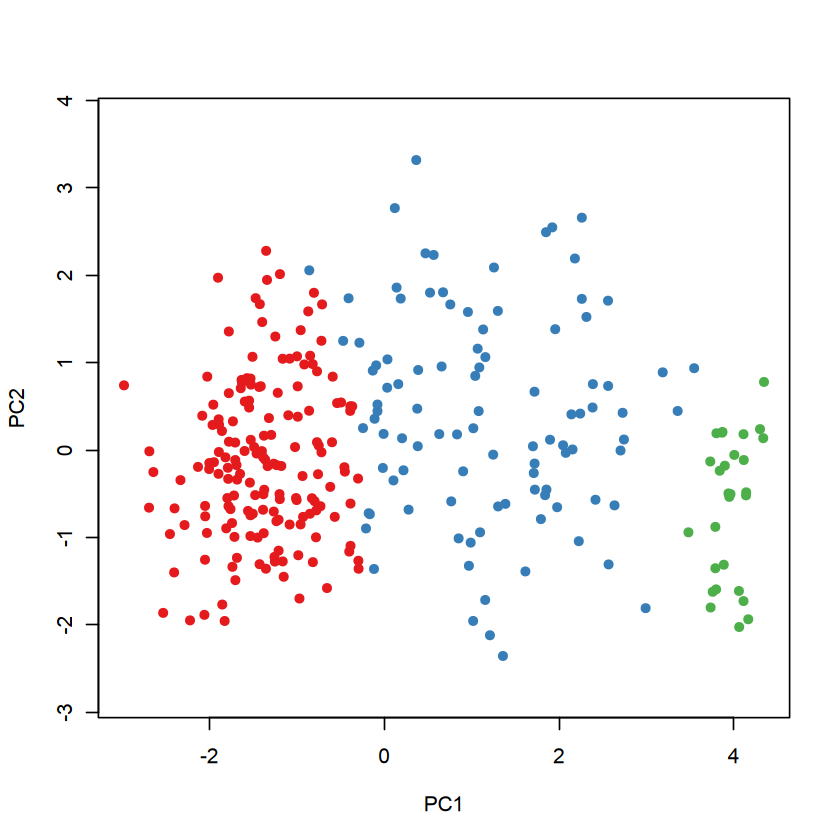

In [210]:
cl1 <- Mclust(rd1)$classification
colData(sim_data_l2)$GMM <- cl1

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

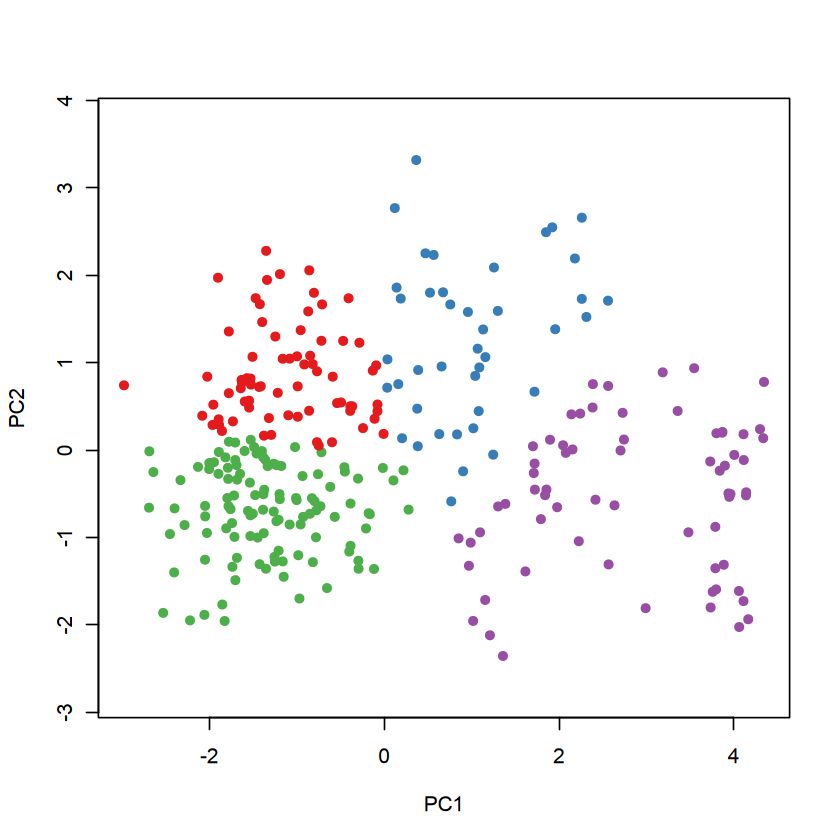

In [211]:
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sim_data_l2)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

In [212]:
sim_data_l2 <- slingshot(sim_data_l2, clusterLabels = 'GMM', reducedDim = 'PCA')

In [213]:
summary(sim_data_l1$slingPseudotime_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  5.052   6.956   9.402   9.758  12.529  14.734     299 

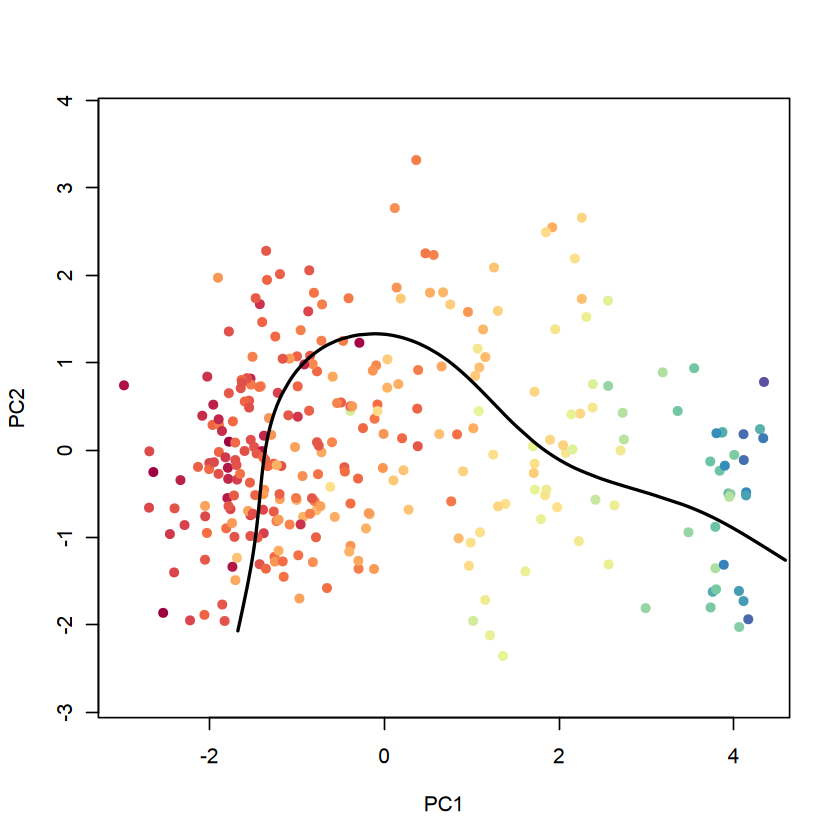

In [214]:
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sim_data_l2$slingPseudotime_1, breaks=100)]

plot(reducedDims(sim_data_l2)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sim_data_l2), lwd=2, col='black')

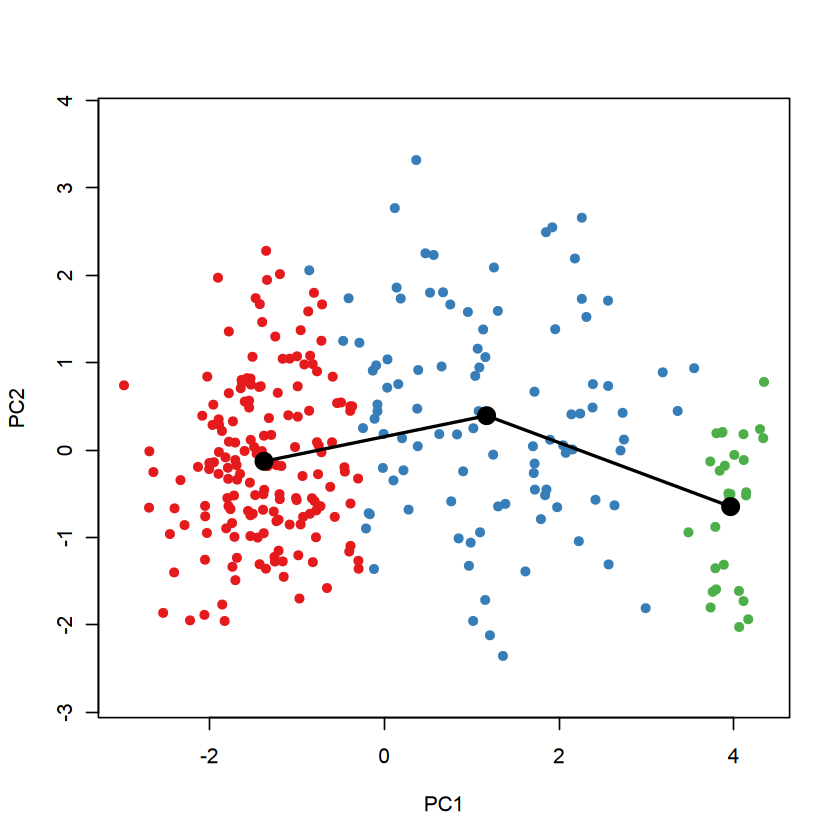

In [215]:
plot(reducedDims(sim_data_l2)$PCA, col = brewer.pal(9,'Set1')[sim_data_l2$GMM], pch=16, asp = 1)
lines(SlingshotDataSet(sim_data_l2), lwd=2, type = 'lineages', col = 'black')

In [216]:
slingshot_l2_rank <- rank(sim_data_l2$slingPseudotime_1,ties.method = 'random', na.last = 'keep')
slingshot_l2_norm <- scales::rescale(slingshot_l2_rank,to = c(0,1))

In [217]:
seurat_l2@meta.data$slingshot_l2_norm = slingshot_l2_norm
seurat_l2@meta.data$slingshot_l2 = sim_data_l2$slingPseudotime_1

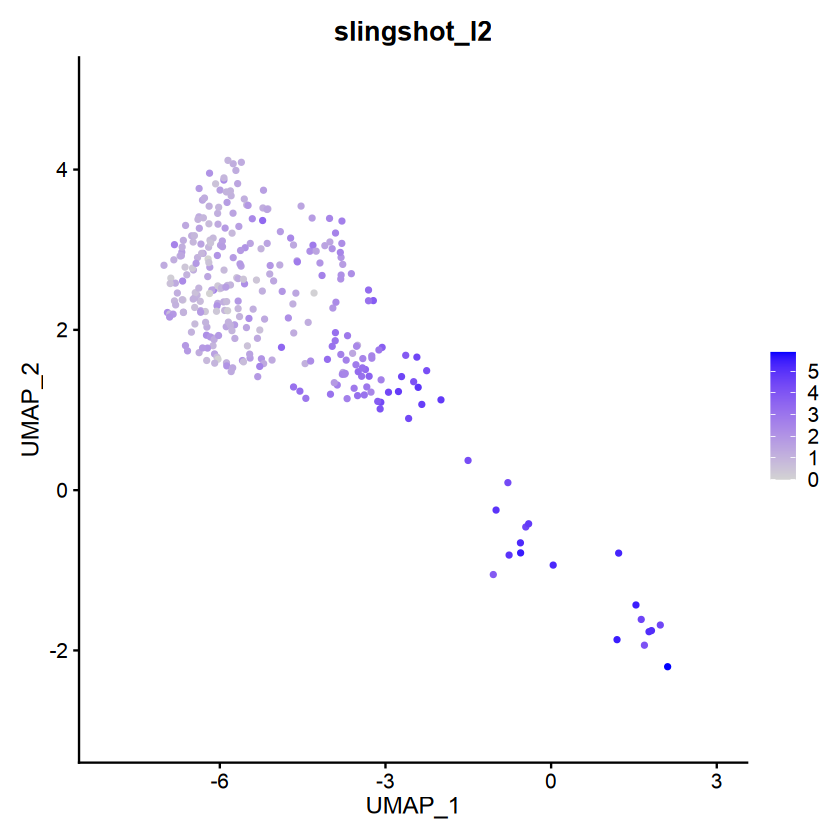

In [218]:
FeaturePlot(seurat_l2, features = c("slingshot_l2"), reduction = "umap")

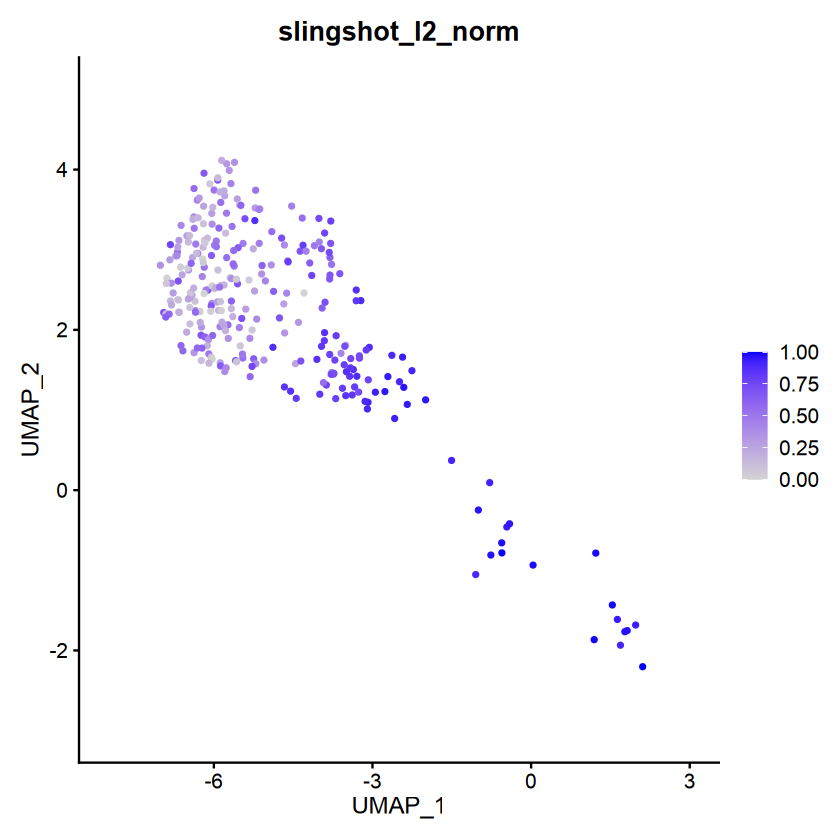

In [219]:
FeaturePlot(seurat_l2, features = c("slingshot_l2_norm"), reduction = "umap")

## comparison

In [220]:
head(seurat_l2@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell1  SeuratProject 395        88           5161    9            990.2580
cell12 SeuratProject 455        94           4822    9            313.6040
cell18 SeuratProject 386        91            337    1            533.3340
cell25 SeuratProject 432        92            248    1            350.3330
cell48 SeuratProject 352        88           2777    5            814.6622
cell52 SeuratProject 437        95            226    1            305.3268
       Cell_Type x          y           lineage ⋯ slingshot_norm slingshot
cell1  J         -476.76099  621.242027 2       ⋯ 0.27864215     2.1638091
cell12 H         -181.08572  -95.677670 2       ⋯ 0.15134371     1.2782156
cell18 I         -680.43881  233.533017 2       ⋯ 0.13012730     1.2111386
cell25 H          -55.06599  -78.023116 2       ⋯ 0.03818953     0.7533477
cell48 J           28.92606    3.349564 2       ⋯ 0.04950495     0.8212299
cell52 H          340.12619 -615.327193 2       ⋯ 0.18246110     1.4583540
       dpt_l2_norm dpt_l2     monocle3_l2_norm monocle3_l2 tscan_l2_norm
cell1  0.0000000   0.00000000 0.8213058        4.545378    0.25085911   
cell12 0.1099656   0.01378667 0.8316151        4.564982    0.32302405   
cell18 0.2061856   0.01587896 0.5223368        3.322206    0.24742268   
cell25 0.4089347   0.02068111 0.7525773        3.786422    0.07560137   
cell48 0.3676976   0.01944145 0.8075601        4.526141    0.32989691   
cell52 0.5085911   0.02559567 0.4398625        1.879644    0.18213058   
       tscan_l2 slingshot_l2_norm slingshot_l2
cell1  74       0.67697595        2.1735223   
cell12 95       0.36769759        1.2774714   
cell18 73       0.31615120        1.2114641   
cell25 23       0.09278351        0.7533947   
cell48 97       0.12027491        0.8212250   
cell52 54       0.44329897        1.4579552

In [221]:
seurat_l2@meta.data$dpt_l2_rank = rank(seurat_l2@meta.data$dpt, ties.method = 'random', na.last = 'keep')
seurat_l2@meta.data$dpt_l2_norm <- scales::rescale(seurat_l2@meta.data$dpt_l2_rank,to = c(0,1))


In [222]:
seurat_l2@meta.data$sim_time_l2_rank = rank(seurat_l2@meta.data$sim_time, ties.method = 'random', na.last = 'keep')
seurat_l2@meta.data$sim_time_l2_norm <- scales::rescale(seurat_l2@meta.data$sim_time_l2_rank,to = c(0,1))

In [223]:
long_df <- gather(seurat_l2@meta.data[,c("dpt_l2_norm", "monocle3_l2_norm", "tscan_l2_norm", "slingshot_l2_norm", "sim_time_l2_norm", "Cell_Type", "lineage")], key = "variable", value = "value", -sim_time_l2_norm, -Cell_Type, -lineage)
colnames(long_df) = c('sim_time_l2_norm', 'Cell_Type', 'lineage', 'method', 'value')
long_df$method[long_df$method=='dpt_l2_norm'] = "DPT"
long_df$method[long_df$method=='monocle3_l2_norm'] = "monocle3"
long_df$method[long_df$method=='tscan_l2_norm'] = "TSCAN"
long_df$method[long_df$method=='slingshot_l2_norm'] = "Slingshot"
head(long_df)

sim_time_l2_norm Cell_Type lineage method value    
1 0.9965636        J         2       DPT    0.5360825
2 0.2302405        H         2       DPT    0.7010309
3 0.5807560        I         2       DPT    0.6975945
4 0.3298969        H         2       DPT    0.8419244
5 0.8797251        J         2       DPT    0.6426117
6 0.2027491        H         2       DPT    0.8075601

In [224]:
correlations <- data.frame(
  method = c("DPT", "monocle3", "TSCAN", "Slingshot"),
  correlation = c(abs(cor(seurat_l2@meta.data$sim_time_l2_norm, seurat_l2@meta.data$dpt_l2_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l2@meta.data$sim_time_l2_norm, seurat_l2@meta.data$monocle3_l2_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l2@meta.data$sim_time_l2_norm, seurat_l2@meta.data$tscan_l2_norm, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l2@meta.data$sim_time_l2_norm, seurat_l2@meta.data$slingshot_l2_norm, method = "spearman", use = "complete.obs")))
)
head(correlations)

method    correlation
1 DPT       0.5054279  
2 monocle3  0.3624143  
3 TSCAN     0.4993997  
4 Slingshot 0.4577813

In [225]:
correlations_ = correlations
correlations_$lineage = "lineage2"
all_correlations = rbind(all_correlations, correlations_)
all_correlations

method    correlation lineage 
1  DPT       0.8444481   all     
2  monocle3  0.8352968   all     
3  TSCAN     0.8587912   all     
4  Slingshot 0.9062563   all     
5  DPT       0.9189714   lineage1
6  monocle3  0.9018738   lineage1
7  TSCAN     0.9116533   lineage1
8  Slingshot 0.6812243   lineage1
9  DPT       0.5054279   lineage2
10 monocle3  0.3624143   lineage2
11 TSCAN     0.4993997   lineage2
12 Slingshot 0.4577813   lineage2

In [226]:
correlation_with_gt <- data.frame(
  method = c("DPT", "monocle3", "TSCAN", "Slingshot"),
  correlation = c(abs(cor(seurat_l2@meta.data$r, seurat_l2@meta.data$dpt, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l2@meta.data$r, seurat_l2@meta.data$monocle3, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l2@meta.data$r, seurat_l2@meta.data$tscan, method = "spearman", use = "complete.obs")),
                  abs(cor(seurat_l2@meta.data$r, seurat_l2@meta.data$slingshot, method = "spearman", use = "complete.obs")))
)
head(correlation_with_gt)

method    correlation
1 DPT       0.012579932
2 monocle3  0.059723830
3 TSCAN     0.008528808
4 Slingshot 0.066105856

In [227]:
correlations_ = correlation_with_gt
correlations_$lineage = "lineage2"
all_correlation_with_gt = rbind(all_correlation_with_gt, correlations_)
all_correlation_with_gt

method    correlation lineage 
1  ONTraC    0.991838522 all     
2  DPT       0.653359497 all     
3  monocle3  0.571525452 all     
4  TSCAN     0.494926526 all     
5  Slingshot 0.506405625 all     
6  DPT       0.918968092 lineage1
7  monocle3  0.909666010 lineage1
8  TSCAN     0.877399588 lineage1
9  Slingshot 0.895063366 lineage1
10 DPT       0.012579932 lineage2
11 monocle3  0.059723830 lineage2
12 TSCAN     0.008528808 lineage2
13 Slingshot 0.066105856 lineage2

In [228]:
long_df <- left_join(long_df, correlations, by = "method")
head(long_df)

sim_time_l2_norm Cell_Type lineage method value     correlation
1 0.9965636        J         2       DPT    0.5360825 0.5054279  
2 0.2302405        H         2       DPT    0.7010309 0.5054279  
3 0.5807560        I         2       DPT    0.6975945 0.5054279  
4 0.3298969        H         2       DPT    0.8419244 0.5054279  
5 0.8797251        J         2       DPT    0.6426117 0.5054279  
6 0.2027491        H         2       DPT    0.8075601 0.5054279

Saving 6.67 x 6.67 in image


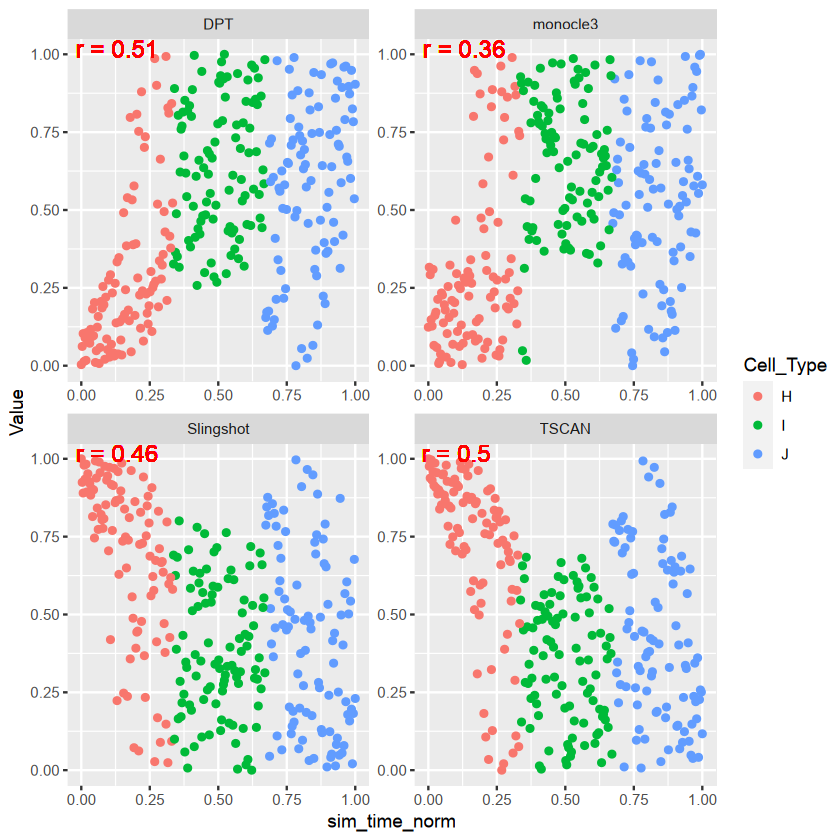

In [229]:
ggplot(long_df, aes(x = sim_time_l2_norm, y = value, color=Cell_Type, palette="Set1")) + 
  geom_point() + 
  facet_wrap(~method, scales = "free") +
  geom_text(aes(label = paste("r =", round(correlation, 2))), x = -Inf, y = Inf, hjust = -0.1, vjust = 1.1, color = "red", size = 5) +
  xlab("sim_time_norm") + 
  ylab("Value")
ggsave("Pseudotime_lineage2_comparison_cell_type.pdf")

# Output

## correlation with sim_time

In [230]:
all_correlations$correlation = round(all_correlations$correlation, 2)

In [231]:
all_correlations

method    correlation lineage 
1  DPT       0.84        all     
2  monocle3  0.84        all     
3  TSCAN     0.86        all     
4  Slingshot 0.91        all     
5  DPT       0.92        lineage1
6  monocle3  0.90        lineage1
7  TSCAN     0.91        lineage1
8  Slingshot 0.68        lineage1
9  DPT       0.51        lineage2
10 monocle3  0.36        lineage2
11 TSCAN     0.50        lineage2
12 Slingshot 0.46        lineage2

In [232]:
new_df <- all_correlations %>%
  select(lineage, method, correlation) %>%
  pivot_wider(names_from = lineage, values_from = correlation)

new_df[new_df$method=='TSCAN', 'all'] = NA
new_df[new_df$method=='Slingshot', 'all'] = NA

In [233]:
new_df

method    all  lineage1 lineage2
1 DPT       0.84 0.92     0.51    
2 monocle3  0.84 0.90     0.36    
3 TSCAN       NA 0.91     0.50    
4 Slingshot   NA 0.68     0.46

In [234]:
write.csv(new_df,'Spearman_correlation_with_sim_time.csv')

## correlation with r (truth NT)

In [235]:
all_correlation_with_gt$correlation = round(all_correlation_with_gt$correlation, 2)
all_correlation_with_gt

method    correlation lineage 
1  ONTraC    0.99        all     
2  DPT       0.65        all     
3  monocle3  0.57        all     
4  TSCAN     0.49        all     
5  Slingshot 0.51        all     
6  DPT       0.92        lineage1
7  monocle3  0.91        lineage1
8  TSCAN     0.88        lineage1
9  Slingshot 0.90        lineage1
10 DPT       0.01        lineage2
11 monocle3  0.06        lineage2
12 TSCAN     0.01        lineage2
13 Slingshot 0.07        lineage2

In [236]:
all_correlation_with_gt = all_correlation_with_gt[-c(4, 5), ]
write.csv(all_correlation_with_gt,'Spearman_correlation_with_truth_include_slingshot.csv')

In [237]:
all_correlation_with_gt

method    correlation lineage 
1  ONTraC    0.99        all     
2  DPT       0.65        all     
3  monocle3  0.57        all     
6  DPT       0.92        lineage1
7  monocle3  0.91        lineage1
8  TSCAN     0.88        lineage1
9  Slingshot 0.90        lineage1
10 DPT       0.01        lineage2
11 monocle3  0.06        lineage2
12 TSCAN     0.01        lineage2
13 Slingshot 0.07        lineage2

In [238]:
all_correlation_with_gt = all_correlation_with_gt[-c(7, 11), ]
all_correlation_with_gt


method   correlation lineage 
1  ONTraC   0.99        all     
2  DPT      0.65        all     
3  monocle3 0.57        all     
6  DPT      0.92        lineage1
7  monocle3 0.91        lineage1
8  TSCAN    0.88        lineage1
10 DPT      0.01        lineage2
11 monocle3 0.06        lineage2
12 TSCAN    0.01        lineage2

In [239]:
write.csv(all_correlation_with_gt,'Spearman_correlation_with_truth.csv')

In [240]:
new_df <- all_correlation_with_gt %>%
  select(lineage, method, correlation) %>%
  pivot_wider(names_from = lineage, values_from = correlation)
new_df

method   all  lineage1 lineage2
1 ONTraC   0.99   NA       NA    
2 DPT      0.65 0.92     0.01    
3 monocle3 0.57 0.91     0.06    
4 TSCAN      NA 0.88     0.01

In [241]:
write.csv(all_correlation_with_gt,'Spearman_correlation_with_truth_pivoted.csv')

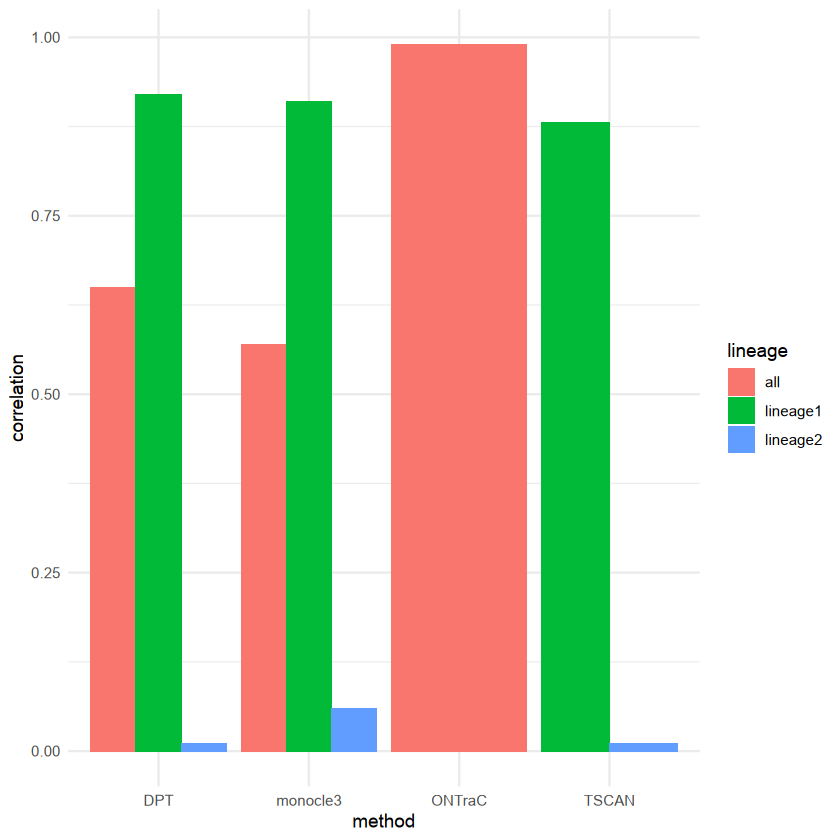

In [242]:
ggplot(data = all_correlation_with_gt, aes(x = method, y = correlation, fill = lineage)) + 
    geom_bar(stat="identity", position=position_dodge()) +
    theme_minimal()

## pseudotime

In [243]:
head(ss0@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell1 SeuratProject  395        88          5161    9            990.2580
cell2 SeuratProject  249        74          1337    3            227.5431
cell3 SeuratProject 1023       109          2079    4            558.6239
cell4 SeuratProject  517       102          3800    7            573.5479
cell5 SeuratProject  318        79          3767    7            500.1175
cell6 SeuratProject  263        84          1526    3            620.8488
      Cell_Type x         y         lineage ⋯ sim_time_norm Cell_NTScore
cell1 J         -476.7610  621.2420 2       ⋯ 0.9959960     0.9226104   
cell2 D         -342.3892  295.9027 1       ⋯ 0.3753754     0.6154288   
cell3 F          696.1339 -134.7557 1       ⋯ 0.7657658     0.8448661   
cell4 F          329.3906 -638.5099 1       ⋯ 0.7767768     0.9180524   
cell5 F          610.3327  278.5673 1       ⋯ 0.6916917     0.8193589   
cell6 F          740.6564 -100.9556 1       ⋯ 0.7937938     0.8560733   
      dpt_norm  dpt       monocle3_norm monocle3  tscan_norm tscan
cell1 0.6756757 0.4910829 0.8628629     16.761602 0.8746867  699  
cell2 0.3823824 0.1720047 0.4584585      8.408949 0.5764411  461  
cell3 0.9789790 2.3243231 0.7767768     15.755698        NA   NA  
cell4 0.8988989 1.5799136 0.7207207     14.822861        NA   NA  
cell5 0.6226226 0.4515718 0.5565566     11.168129        NA   NA  
cell6 0.3533534 0.1645560 0.3733734      7.117197 0.6629073  530  
      slingshot_norm slingshot
cell1 0.2786421      2.163809 
cell2 0.4681754      6.345731 
cell3        NA            NA 
cell4        NA            NA 
cell5        NA            NA 
cell6 0.4922207      6.556258

In [244]:
colnames(ss0@meta.data)

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "step_ix"        
 [5] "simulation_i"    "sim_time"        "Cell_Type"       "x"              
 [9] "y"               "lineage"         "r"               "RNA_snn_res.2"  
[13] "seurat_clusters" "sim_time_rank"   "sim_time_norm"   "Cell_NTScore"   
[17] "dpt_norm"        "dpt"             "monocle3_norm"   "monocle3"       
[21] "tscan_norm"      "tscan"           "slingshot_norm"  "slingshot"

In [245]:
head(seurat_l1@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell2 SeuratProject  249        74          1337     3           227.5431
cell3 SeuratProject 1023       109          2079     4           558.6239
cell4 SeuratProject  517       102          3800     7           573.5479
cell5 SeuratProject  318        79          3767     7           500.1175
cell6 SeuratProject  263        84          1526     3           620.8488
cell7 SeuratProject  515       108          5426    10           383.2188
      Cell_Type x         y         lineage ⋯ dpt_l1    monocle3_l1_norm
cell2 D         -342.3892  295.9027 1       ⋯ 0.1786774 0.5714286       
cell3 F          696.1339 -134.7557 1       ⋯ 2.1443664 0.8670438       
cell4 F          329.3906 -638.5099 1       ⋯ 1.4917856 0.8599717       
cell5 F          610.3327  278.5673 1       ⋯ 0.4847820 0.7157001       
cell6 F          740.6564 -100.9556 1       ⋯ 0.1396817 0.3932107       
cell7 E          473.2788 -347.7126 1       ⋯ 1.5360107 0.9009901       
      monocle3_l1 tscan_l1_norm tscan_l1 slingshot_l1_norm slingshot_l1
cell2  8.435878   0.43472023    304      0.14950980         6.590643   
cell3 15.868064   0.01865136     14      0.76225490        12.560731   
cell4 15.725070   0.14490674    102      0.78186275        12.727012   
cell5 10.630604   0.28550933    200      0.54656863        10.400071   
cell6  7.648531           NA     NA      0.05882353         6.077650   
cell7 16.363354   0.14347202    101      0.81617647        12.879272   
      dpt_l1_rank sim_time_l1_rank sim_time_l1_norm
cell2 383         374              0.5275813       
cell3 687         579              0.8175389       
cell4 607         586              0.8274399       
cell5 513         536              0.7567185       
cell6 354         598              0.8444130       
cell7 610         464              0.6548798

In [246]:
head(seurat_l2@meta.data)

orig.ident    nCount_RNA nFeature_RNA step_ix simulation_i sim_time
cell1  SeuratProject 395        88           5161    9            990.2580
cell12 SeuratProject 455        94           4822    9            313.6040
cell18 SeuratProject 386        91            337    1            533.3340
cell25 SeuratProject 432        92            248    1            350.3330
cell48 SeuratProject 352        88           2777    5            814.6622
cell52 SeuratProject 437        95            226    1            305.3268
       Cell_Type x          y           lineage ⋯ dpt_l2     monocle3_l2_norm
cell1  J         -476.76099  621.242027 2       ⋯ 0.00000000 0.8213058       
cell12 H         -181.08572  -95.677670 2       ⋯ 0.01378667 0.8316151       
cell18 I         -680.43881  233.533017 2       ⋯ 0.01587896 0.5223368       
cell25 H          -55.06599  -78.023116 2       ⋯ 0.02068111 0.7525773       
cell48 J           28.92606    3.349564 2       ⋯ 0.01944145 0.8075601       
cell52 H          340.12619 -615.327193 2       ⋯ 0.02559567 0.4398625       
       monocle3_l2 tscan_l2_norm tscan_l2 slingshot_l2_norm slingshot_l2
cell1  4.545378    0.25085911    74       0.67697595        2.1735223   
cell12 4.564982    0.32302405    95       0.36769759        1.2774714   
cell18 3.322206    0.24742268    73       0.31615120        1.2114641   
cell25 3.786422    0.07560137    23       0.09278351        0.7533947   
cell48 4.526141    0.32989691    97       0.12027491        0.8212250   
cell52 1.879644    0.18213058    54       0.44329897        1.4579552   
       dpt_l2_rank sim_time_l2_rank sim_time_l2_norm
cell1  157         291              0.9965636       
cell12 205          68              0.2302405       
cell18 204         170              0.5807560       
cell25 246          97              0.3298969       
cell48 188         257              0.8797251       
cell52 236          60              0.2027491

In [247]:
pseudotime_output = ss0@meta.data[,c('x', 'y', 'r', 'lineage', 'Cell_NTScore', 'dpt', 'monocle3','tscan','slingshot','dpt_norm', 'monocle3_norm','tscan_norm','slingshot_norm')]
head(pseudotime_output)

x         y         r        lineage Cell_NTScore dpt       monocle3 
cell1 -476.7610  621.2420 783.0981 2       0.9226104    0.4910829 16.761602
cell2 -342.3892  295.9027 452.5360 1       0.6154288    0.1720047  8.408949
cell3  696.1339 -134.7557 709.0568 1       0.8448661    2.3243231 15.755698
cell4  329.3906 -638.5099 718.4658 1       0.9180524    1.5799136 14.822861
cell5  610.3327  278.5673 670.8992 1       0.8193589    0.4515718 11.168129
cell6  740.6564 -100.9556 747.5051 1       0.8560733    0.1645560  7.117197
      tscan slingshot dpt_norm  monocle3_norm tscan_norm slingshot_norm
cell1 699   2.163809  0.6756757 0.8628629     0.8746867  0.2786421     
cell2 461   6.345731  0.3823824 0.4584585     0.5764411  0.4681754     
cell3  NA         NA  0.9789790 0.7767768            NA         NA     
cell4  NA         NA  0.8988989 0.7207207            NA         NA     
cell5  NA         NA  0.6226226 0.5565566            NA         NA     
cell6 530   6.556258  0.3533534 0.3733734     0.6629073  0.4922207

In [248]:
pseudotime_output$dpt_l1 = seurat_l1@meta.data[match(rownames(pseudotime_output), rownames(seurat_l1@meta.data)), c('dpt_l1')]
pseudotime_output$monocle3_l1 = seurat_l1@meta.data[match(rownames(pseudotime_output), rownames(seurat_l1@meta.data)), c('monocle3_l1')]
pseudotime_output$tscan_l1 = seurat_l1@meta.data[match(rownames(pseudotime_output), rownames(seurat_l1@meta.data)), c('tscan_l1')]
pseudotime_output$slingshot_l1 = seurat_l1@meta.data[match(rownames(pseudotime_output), rownames(seurat_l1@meta.data)), c('slingshot_l1')]
pseudotime_output$dpt_l1_norm = seurat_l1@meta.data[match(rownames(pseudotime_output), rownames(seurat_l1@meta.data)), c('dpt_l1_norm')]
pseudotime_output$monocle3_l1_norm = seurat_l1@meta.data[match(rownames(pseudotime_output), rownames(seurat_l1@meta.data)), c('monocle3_l1_norm')]
pseudotime_output$tscan_l1_norm = seurat_l1@meta.data[match(rownames(pseudotime_output), rownames(seurat_l1@meta.data)), c('tscan_l1_norm')]
pseudotime_output$slingshot_l1_norm = seurat_l1@meta.data[match(rownames(pseudotime_output), rownames(seurat_l1@meta.data)), c('slingshot_l1_norm')]

In [249]:
pseudotime_output$dpt_l2 = seurat_l2@meta.data[match(rownames(pseudotime_output), rownames(seurat_l2@meta.data)), c('dpt_l2')]
pseudotime_output$monocle3_l2 = seurat_l2@meta.data[match(rownames(pseudotime_output), rownames(seurat_l2@meta.data)), c('monocle3_l2')]
pseudotime_output$tscan_l2 = seurat_l2@meta.data[match(rownames(pseudotime_output), rownames(seurat_l2@meta.data)), c('tscan_l2')]
pseudotime_output$slingshot_l2 = seurat_l2@meta.data[match(rownames(pseudotime_output), rownames(seurat_l2@meta.data)), c('slingshot_l2')]
pseudotime_output$dpt_l2_norm = seurat_l2@meta.data[match(rownames(pseudotime_output), rownames(seurat_l2@meta.data)), c('dpt_l2_norm')]
pseudotime_output$monocle3_l2_norm = seurat_l2@meta.data[match(rownames(pseudotime_output), rownames(seurat_l2@meta.data)), c('monocle3_l2_norm')]
pseudotime_output$tscan_l2_norm = seurat_l2@meta.data[match(rownames(pseudotime_output), rownames(seurat_l2@meta.data)), c('tscan_l2_norm')]
pseudotime_output$slingshot_l2_norm = seurat_l2@meta.data[match(rownames(pseudotime_output), rownames(seurat_l2@meta.data)), c('slingshot_l2_norm')]

In [250]:
head(pseudotime_output)

x         y         r        lineage Cell_NTScore dpt       monocle3 
cell1 -476.7610  621.2420 783.0981 2       0.9226104    0.4910829 16.761602
cell2 -342.3892  295.9027 452.5360 1       0.6154288    0.1720047  8.408949
cell3  696.1339 -134.7557 709.0568 1       0.8448661    2.3243231 15.755698
cell4  329.3906 -638.5099 718.4658 1       0.9180524    1.5799136 14.822861
cell5  610.3327  278.5673 670.8992 1       0.8193589    0.4515718 11.168129
cell6  740.6564 -100.9556 747.5051 1       0.8560733    0.1645560  7.117197
      tscan slingshot dpt_norm  ⋯ tscan_l1_norm slingshot_l1_norm dpt_l2
cell1 699   2.163809  0.6756757 ⋯         NA            NA         0    
cell2 461   6.345731  0.3823824 ⋯ 0.43472023    0.14950980        NA    
cell3  NA         NA  0.9789790 ⋯ 0.01865136    0.76225490        NA    
cell4  NA         NA  0.8988989 ⋯ 0.14490674    0.78186275        NA    
cell5  NA         NA  0.6226226 ⋯ 0.28550933    0.54656863        NA    
cell6 530   6.556258  0.3533534 ⋯         NA    0.05882353        NA    
      monocle3_l2 tscan_l2 slingshot_l2 dpt_l2_norm monocle3_l2_norm
cell1 4.545378    74       2.173522     0.5360825   0.8213058       
cell2       NA    NA             NA            NA          NA       
cell3       NA    NA             NA            NA          NA       
cell4       NA    NA             NA            NA          NA       
cell5       NA    NA             NA            NA          NA       
cell6       NA    NA             NA            NA          NA       
      tscan_l2_norm slingshot_l2_norm
cell1 0.2508591     0.6769759        
cell2        NA            NA        
cell3        NA            NA        
cell4        NA            NA        
cell5        NA            NA        
cell6        NA            NA

In [251]:
colnames(pseudotime_output) = c('x', 'y', 'r', 'lineage', 'ONTraC',
                                'DPT', 'monocle3', 'TSCAN', 'Slingshot',
                                'DPT_norm', 'monocle3_norm', 'TSCAN_norm', 'Slingshot_norm',
                                'DPT_l1', 'monocle3_l1', 'TSCAN_l1', 'Slingshot_l1',
                                'DPT_l1_norm', 'monocle3_l1_norm', 'TSCAN_l1_norm', 'Slingshot_l1_norm',
                                'DPT_l2', 'monocle3_l2', 'TSCAN_l2', 'Slingshot_l2',
                                'DPT_l2_norm', 'monocle3_l2_norm', 'TSCAN_l2_norm', 'Slingshot_l2_norm')
head(pseudotime_output)

x         y         r        lineage ONTraC    DPT       monocle3  TSCAN
cell1 -476.7610  621.2420 783.0981 2       0.9226104 0.4910829 16.761602 699  
cell2 -342.3892  295.9027 452.5360 1       0.6154288 0.1720047  8.408949 461  
cell3  696.1339 -134.7557 709.0568 1       0.8448661 2.3243231 15.755698  NA  
cell4  329.3906 -638.5099 718.4658 1       0.9180524 1.5799136 14.822861  NA  
cell5  610.3327  278.5673 670.8992 1       0.8193589 0.4515718 11.168129  NA  
cell6  740.6564 -100.9556 747.5051 1       0.8560733 0.1645560  7.117197 530  
      Slingshot DPT_norm  ⋯ TSCAN_l1_norm Slingshot_l1_norm DPT_l2 monocle3_l2
cell1 2.163809  0.6756757 ⋯         NA            NA         0     4.545378   
cell2 6.345731  0.3823824 ⋯ 0.43472023    0.14950980        NA           NA   
cell3       NA  0.9789790 ⋯ 0.01865136    0.76225490        NA           NA   
cell4       NA  0.8988989 ⋯ 0.14490674    0.78186275        NA           NA   
cell5       NA  0.6226226 ⋯ 0.28550933    0.54656863        NA           NA   
cell6 6.556258  0.3533534 ⋯         NA    0.05882353        NA           NA   
      TSCAN_l2 Slingshot_l2 DPT_l2_norm monocle3_l2_norm TSCAN_l2_norm
cell1 74       2.173522     0.5360825   0.8213058        0.2508591    
cell2 NA             NA            NA          NA               NA    
cell3 NA             NA            NA          NA               NA    
cell4 NA             NA            NA          NA               NA    
cell5 NA             NA            NA          NA               NA    
cell6 NA             NA            NA          NA               NA    
      Slingshot_l2_norm
cell1 0.6769759        
cell2        NA        
cell3        NA        
cell4        NA        
cell5        NA        
cell6        NA

In [252]:
write.csv(pseudotime_output, "pseudotime_output.csv")

## UMAP embeddings

In [253]:
str(ss0@reductions$umap, 2)

Formal class 'DimReduc' [package "SeuratObject"] with 9 slots
  ..@ cell.embeddings           : num [1:1000, 1:2] -5.552 -0.279 6.568 5.816 2.446 ...
  .. ..- attr(*, "scaled:center")= num [1:2] -7.29 -4.09
  .. ..- attr(*, "dimnames")=List of 2
  ..@ feature.loadings          : num[0 , 0 ] 
  ..@ feature.loadings.projected: num[0 , 0 ] 
  ..@ assay.used                : chr "RNA"
  ..@ global                    : logi TRUE
  ..@ stdev                     : num(0) 
  ..@ key                       : chr "UMAP_"
  ..@ jackstraw                 :Formal class 'JackStrawData' [package "SeuratObject"] with 4 slots
  ..@ misc                      : list()


In [254]:
write.csv(ss0@reductions$umap@cell.embeddings,'UMAP_embeddings.csv')

# sessionInfo

In [255]:
sessionInfo()

Warning message:
“‘timedatectl’ indicates the non-existent timezone name ‘n/a’”
Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘America/New_York’ (or equivalent)”


R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /sc/arion/work/wangw32/conda-env/envs/seurat_v4/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.utf8        LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] RColorBrewer_1.1-3          mclust_6.1                 
 [3] slingshot_2.10.0            TrajectoryUtils_1.10.1     
 [5] princurve_2.1.6             uwot_0.1.16                
 [7] Matr